In [1]:
# means that my matplotlib graphs will be included in the notebook, next to the code
%matplotlib inline

import os

import math
import astropy
import random
import numpy as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u

from hetdex_tools.get_spec import get_spectra
from hetdex_api.config import HDRconfig
from hetdex_api.detections import Detections
from hetdex_api.elixer_widget_cls import ElixerWidget

Configuration file not found:

    /home/jovyan/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.
Populating dustmaps config with /home/jovyan/Hobby-Eberly-Telesco/hdr3/calib/dustmaps


In [2]:
# not sure why the code below is here, it was in the Detections database and API notebook
# https://github.com/HETDEX/hetdex_api/blob/master/notebooks/api-notebooks/03-Detections_Database_and_API.ipynb

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [55]:
# Using this to be able to plot spectra. For some reason Jupyter won't let me plot spectra without this
%matplotlib inline

### Opens the catalogs and turns them into dataframes

I like to open both catalogs separately since they are both big (HDR3 especially!)

In [5]:
# Opening HDR3 detections catalog and converting it into a pandas DF
# HDR3 is detections HETDEX found
HDR_source_cat = fits.open('/home/jovyan/Hobby-Eberly-Telesco/hdr3/catalogs/source_catalog_3.0.1.fits', memmap = True)
HDR3_data = HDR_source_cat[1].data
HDR3_DF = pd.DataFrame(HDR3_data, columns=HDR3_data.columns.names)

In [6]:
# Opening H20 NEP catalog and converting it into a pandas DF
# H20 is stricly photometry sources
H20_NEP_catalog = fits.open('H20_NEP_VIRUS_OVERLAP_CAT_10_2021.fits', memmap = True)
H20_NEP_data = H20_NEP_catalog[1].data
H20_NEP_DF = pd.DataFrame(H20_NEP_data, columns=H20_NEP_data.columns.names)

In [7]:
# Columns we will then take from the entire data set (it was huge so we needed to determine what we wanted to look at specifically).
# As the name suggests, these are the ones that are useful to us!
useful_hdr3_cols = ['source_id', 'detectid',  'selected_det', 'ra_mean', 'dec_mean', 'fwhm', 'shotid', 'field',  'ra', 'dec', 'wave', 'wave_err', 'flux', 'flux_err', 'sn', 'sn_err', 'chi2', 'chi2_err',
'linewidth', 'linewidth_err', 'plya_classification', 'z_hetdex', 'z_hetdex_conf', 'combined_plae']

# For now, the only useful columns for us in H20 NEP is RA and DEC.
useful_h20nep_cols = ['RA_MODELING', 'DEC_MODELING', 'VALID_SOURCE_MODELING']

# From the original DFs, taking the useful columns
reduced_hdr3_df = HDR3_DF.loc[:, useful_hdr3_cols]
reduced_h20nep_df = H20_NEP_DF.loc[:, useful_h20nep_cols]

### Cleaning up the data

In [8]:
# Removing data from before 2017 because it isn't good (not useful to us)
# No need to do this for H20 NEP
removed_bad_shots_hdr3_df = reduced_hdr3_df[reduced_hdr3_df.shotid.values >= 20180000000]

# CODE BELOW THIS IS TO GET HIGH CONFIDENCE HIGH-Z SAMPLE!

In [9]:
# Getting all sources with a SN > 6 and a plya > 0.95. So all high-confidence high-z sources.
hdr3_SN_6 = removed_bad_shots_hdr3_df[removed_bad_shots_hdr3_df['sn'] > 6]
hdr3_plya95_SN_6 = hdr3_SN_6[hdr3_SN_6['plya_classification'] > 0.95]
# Getting all sources with a ombined_plae > 3.
hdr3_combined_plae_gt3 = hdr3_plya95_SN_6[hdr3_plya95_SN_6['combined_plae'] > 3]

# Now I take the sources stricly in the NEP field
hdr3_nep = hdr3_combined_plae_gt3[hdr3_combined_plae_gt3['field'] == 'nep']

In [10]:
hdr3_nep

,source_id,detectid,selected_det,ra_mean,dec_mean,fwhm,shotid,field,ra,dec,...,sn,sn_err,chi2,chi2_err,linewidth,linewidth_err,plya_classification,z_hetdex,z_hetdex_conf,combined_plae
123636,3010000124167,3001271066,True,274.098297,65.960350,1.592655,20180712015,nep,274.098297,65.960350,...,6.860000,0.99,0.83,0.22,11.13,2.30,0.999,2.243553,0.533333,1000.0
123665,3010000124146,3001271437,True,273.972595,66.041969,1.592655,20180712015,nep,273.972595,66.041969,...,6.800000,0.53,0.99,0.22,3.41,0.45,0.999,2.957127,0.400000,1000.0
123708,3010000124108,3001271745,True,273.728546,65.936356,1.592655,20180712015,nep,273.728546,65.936356,...,7.690000,0.49,0.99,0.22,2.55,0.34,0.999,2.116923,0.398131,1000.0
123744,3010000124044,3001272321,True,273.630463,66.066116,1.592655,20180712015,nep,273.630463,66.066116,...,10.930000,0.66,1.04,0.23,5.36,0.48,0.999,2.540031,0.533333,1000.0
123770,3010000124026,3001272825,True,274.091492,66.068306,1.592655,20180712015,nep,274.091492,66.068306,...,10.050000,0.46,2.01,0.23,4.61,0.80,0.999,1.914492,0.533333,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417973,3010001422182,3013776172,True,273.494720,66.939873,1.247442,20210827008,nep,273.494720,66.939873,...,6.410000,0.44,1.04,0.22,2.88,0.43,0.999,2.588334,0.533333,1000.0
1417985,3010001422170,3013776229,False,273.496918,66.948593,1.247442,20210827008,nep,273.496948,66.947906,...,7.093458,0.87,1.21,0.22,11.06,2.49,0.999,3.424630,0.800000,1000.0
1418061,3010001422328,3013778043,True,273.773926,66.941826,1.247442,20210827008,nep,273.773926,66.941826,...,6.710000,0.59,0.98,0.23,5.02,0.87,0.999,2.416429,0.800000,1000.0
1418093,3010001422297,3013779050,True,273.817963,66.851768,1.247442,20210827008,nep,273.817963,66.851768,...,9.700000,0.40,0.98,0.22,3.25,0.26,0.999,2.216876,0.533333,1000.0


## Making skycoord object for the catalog
We do this instead of directly looking at the dataframes cause when we do and exract we get fibers from nearby as well. We don't want that.

In [12]:
highz_skycoords = SkyCoord(hdr3_nep['ra'] * u.deg, hdr3_nep['dec'] * u.deg)

In [17]:
num_sources = 1000

high_confidence_highz_LS = [[0] * 1 for i in range(num_sources)]

counter = 0

# separate counter for exctraction.
# If I don't use this and I get a spectra with len != 1 I'll get stuck at the same source
# if I use highz_skycoords[counter]
extraction_counter = 0

# Same extraction code used for random NEP samples
while counter < num_sources:
    
    extraction = get_spectra(highz_skycoords[extraction_counter])
    
    if len(extraction) == 1:
        squeezed_extraction = np.squeeze(extraction['spec'].value)
        high_confidence_highz_LS[counter] = squeezed_extraction
        
        counter += 1
        extraction_counter += 1
    else:
        extraction_counter += 1
        continue

[INFO - 2023-02-08 07:09:17,403] Finding shots of interest
[INFO - 2023-02-08 07:09:22,738] Number of shots of interest: 6
[INFO - 2023-02-08 07:09:22,739] Extracting 6 sources
[INFO - 2023-02-08 07:09:22,830] Working on shot: 20180712015
[INFO - 2023-02-08 07:09:22,856] Working on shot: 20180712017
[INFO - 2023-02-08 07:09:22,885] Working on shot: 20180715008
[INFO - 2023-02-08 07:09:22,918] Working on shot: 20180717012
[INFO - 2023-02-08 07:09:22,947] Working on shot: 20180806011
[INFO - 2023-02-08 07:09:22,975] Working on shot: 20180807009
[INFO - 2023-02-08 07:09:23,235] Extracting 1
[INFO - 2023-02-08 07:09:23,506] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 07:09:23,562] Retrieved 1 spectra.
[INFO - 2023-02-08 07:09:23,615] Finding shots of interest
[INFO - 2023-02-08 07:09:29,002] Number of shots of interest: 8
[INFO - 2023-02-08 07:09:29,003] Extracting 8 sources
[INFO - 2023-02-08 07:09:29,090] Working on shot: 20180712015
[INFO - 2023-02-08 07:09:29,11

[INFO - 2023-02-08 07:10:26,277] Finding shots of interest
[INFO - 2023-02-08 07:10:31,382] Number of shots of interest: 8
[INFO - 2023-02-08 07:10:31,383] Extracting 8 sources
[INFO - 2023-02-08 07:10:31,471] Working on shot: 20180712015
[INFO - 2023-02-08 07:10:31,500] Working on shot: 20180712017
[INFO - 2023-02-08 07:10:31,533] Working on shot: 20180715008
[INFO - 2023-02-08 07:10:31,558] Working on shot: 20180717012
[INFO - 2023-02-08 07:10:31,588] Working on shot: 20180717013
[INFO - 2023-02-08 07:10:31,617] Working on shot: 20180806011
[INFO - 2023-02-08 07:10:31,647] Working on shot: 20180807009
[INFO - 2023-02-08 07:10:31,674] Working on shot: 20180808009
[INFO - 2023-02-08 07:10:32,300] Extracting 1
[INFO - 2023-02-08 07:10:32,597] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:10:32,660] Retrieved 1 spectra.
[INFO - 2023-02-08 07:10:32,705] Finding shots of interest
[INFO - 2023-02-08 07:10:37,892] Number of shots of interest: 8
[INFO - 2023-02-08 07:

[INFO - 2023-02-08 07:11:25,257] Finding shots of interest
[INFO - 2023-02-08 07:11:30,247] Number of shots of interest: 8
[INFO - 2023-02-08 07:11:30,249] Extracting 8 sources
[INFO - 2023-02-08 07:11:30,341] Working on shot: 20180712015
[INFO - 2023-02-08 07:11:30,375] Working on shot: 20180712017
[INFO - 2023-02-08 07:11:30,404] Working on shot: 20180715008
[INFO - 2023-02-08 07:11:30,433] Working on shot: 20180717012
[INFO - 2023-02-08 07:11:30,473] Working on shot: 20180717013
[INFO - 2023-02-08 07:11:30,508] Working on shot: 20180806011
[INFO - 2023-02-08 07:11:30,547] Working on shot: 20180807009
[INFO - 2023-02-08 07:11:30,574] Working on shot: 20180808009
[INFO - 2023-02-08 07:11:31,287] Extracting 1
[INFO - 2023-02-08 07:11:31,557] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:11:31,616] Retrieved 1 spectra.
[INFO - 2023-02-08 07:11:31,662] Finding shots of interest
[INFO - 2023-02-08 07:11:36,781] Number of shots of interest: 8
[INFO - 2023-02-08 07:

[INFO - 2023-02-08 07:12:36,375] Finding shots of interest
[INFO - 2023-02-08 07:12:41,445] Number of shots of interest: 4
[INFO - 2023-02-08 07:12:41,446] Extracting 4 sources
[INFO - 2023-02-08 07:12:41,529] Working on shot: 20180712015
[INFO - 2023-02-08 07:12:41,559] Working on shot: 20180712017
[INFO - 2023-02-08 07:12:41,588] Working on shot: 20180715008
[INFO - 2023-02-08 07:12:41,615] Working on shot: 20180717012
[INFO - 2023-02-08 07:12:41,988] Extracting 1
[INFO - 2023-02-08 07:12:42,285] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 07:12:42,344] Retrieved 1 spectra.
[INFO - 2023-02-08 07:12:42,390] Finding shots of interest
[INFO - 2023-02-08 07:12:47,427] Number of shots of interest: 4
[INFO - 2023-02-08 07:12:47,429] Extracting 4 sources
[INFO - 2023-02-08 07:12:47,516] Working on shot: 20180712015
[INFO - 2023-02-08 07:12:47,545] Working on shot: 20180712017
[INFO - 2023-02-08 07:12:47,580] Working on shot: 20180715008
[INFO - 2023-02-08 07:12:47,60

[INFO - 2023-02-08 07:13:50,411] Extracting 12 sources
[INFO - 2023-02-08 07:13:50,494] Working on shot: 20180712015
[INFO - 2023-02-08 07:13:50,528] Working on shot: 20180712017
[INFO - 2023-02-08 07:13:50,571] Working on shot: 20180715008
[INFO - 2023-02-08 07:13:50,600] Working on shot: 20180717012
[INFO - 2023-02-08 07:13:50,631] Working on shot: 20180717013
[INFO - 2023-02-08 07:13:50,661] Working on shot: 20180806011
[INFO - 2023-02-08 07:13:50,692] Working on shot: 20180807009
[INFO - 2023-02-08 07:13:50,724] Working on shot: 20180808009
[INFO - 2023-02-08 07:13:50,754] Working on shot: 20200421021
[INFO - 2023-02-08 07:13:50,783] Working on shot: 20200425027
[INFO - 2023-02-08 07:13:50,816] Working on shot: 20200427025
[INFO - 2023-02-08 07:13:50,844] Working on shot: 20200502023
[INFO - 2023-02-08 07:13:51,264] Extracting 1
[INFO - 2023-02-08 07:13:51,355] Extracting 1
[INFO - 2023-02-08 07:13:51,361] Extracting 1
[INFO - 2023-02-08 07:13:51,754] Extraction of sources complete

[INFO - 2023-02-08 07:14:41,884] Working on shot: 20180712017
[INFO - 2023-02-08 07:14:41,913] Working on shot: 20180715008
[INFO - 2023-02-08 07:14:41,944] Working on shot: 20180717012
[INFO - 2023-02-08 07:14:41,974] Working on shot: 20180717013
[INFO - 2023-02-08 07:14:42,006] Working on shot: 20180806011
[INFO - 2023-02-08 07:14:42,036] Working on shot: 20180807009
[INFO - 2023-02-08 07:14:42,066] Working on shot: 20180808009
[INFO - 2023-02-08 07:14:42,729] Extracting 1
[INFO - 2023-02-08 07:14:42,749] Extracting 1
[INFO - 2023-02-08 07:14:43,072] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:14:43,136] Retrieved 2 spectra.
[INFO - 2023-02-08 07:14:43,182] Finding shots of interest
[INFO - 2023-02-08 07:14:48,369] Number of shots of interest: 5
[INFO - 2023-02-08 07:14:48,370] Extracting 5 sources
[INFO - 2023-02-08 07:14:48,455] Working on shot: 20180712015
[INFO - 2023-02-08 07:14:48,480] Working on shot: 20180712017
[INFO - 2023-02-08 07:14:48,511] Work

[INFO - 2023-02-08 07:15:41,961] Extracting 1
[INFO - 2023-02-08 07:15:42,047] Extracting 1
[INFO - 2023-02-08 07:15:42,093] Extracting 1
[INFO - 2023-02-08 07:15:42,352] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 07:15:42,417] Retrieved 3 spectra.
[INFO - 2023-02-08 07:15:42,463] Finding shots of interest
[INFO - 2023-02-08 07:15:47,754] Number of shots of interest: 8
[INFO - 2023-02-08 07:15:47,755] Extracting 8 sources
[INFO - 2023-02-08 07:15:47,847] Working on shot: 20180712015
[INFO - 2023-02-08 07:15:47,875] Working on shot: 20180712017
[INFO - 2023-02-08 07:15:47,911] Working on shot: 20180715008
[INFO - 2023-02-08 07:15:47,940] Working on shot: 20180717012
[INFO - 2023-02-08 07:15:47,979] Working on shot: 20180717013
[INFO - 2023-02-08 07:15:48,003] Working on shot: 20180806011
[INFO - 2023-02-08 07:15:48,035] Working on shot: 20180807009
[INFO - 2023-02-08 07:15:48,064] Working on shot: 20180808009
[INFO - 2023-02-08 07:15:48,603] Extracting 1
[INFO -

[INFO - 2023-02-08 07:17:25,703] Retrieved 1 spectra.
[INFO - 2023-02-08 07:17:25,750] Finding shots of interest
[INFO - 2023-02-08 07:17:30,931] Number of shots of interest: 2
[INFO - 2023-02-08 07:17:30,932] Extracting 2 sources
[INFO - 2023-02-08 07:17:31,016] Working on shot: 20180805009
[INFO - 2023-02-08 07:17:31,047] Working on shot: 20180807007
[INFO - 2023-02-08 07:17:31,430] Extracting 1
[INFO - 2023-02-08 07:17:31,736] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 07:17:31,797] Retrieved 1 spectra.
[INFO - 2023-02-08 07:17:31,847] Finding shots of interest
[INFO - 2023-02-08 07:17:37,125] Number of shots of interest: 7
[INFO - 2023-02-08 07:17:37,126] Extracting 7 sources
[INFO - 2023-02-08 07:17:37,214] Working on shot: 20180805010
[INFO - 2023-02-08 07:17:37,240] Working on shot: 20180806010
[INFO - 2023-02-08 07:17:37,270] Working on shot: 20180807008
[INFO - 2023-02-08 07:17:37,304] Working on shot: 20180831003
[INFO - 2023-02-08 07:17:37,336] Worki

[INFO - 2023-02-08 07:18:31,400] Retrieved 2 spectra.
[INFO - 2023-02-08 07:18:31,446] Finding shots of interest
[INFO - 2023-02-08 07:18:36,496] Number of shots of interest: 7
[INFO - 2023-02-08 07:18:36,497] Extracting 7 sources
[INFO - 2023-02-08 07:18:36,580] Working on shot: 20180805010
[INFO - 2023-02-08 07:18:36,606] Working on shot: 20180806010
[INFO - 2023-02-08 07:18:36,636] Working on shot: 20180807008
[INFO - 2023-02-08 07:18:36,667] Working on shot: 20180831003
[INFO - 2023-02-08 07:18:36,698] Working on shot: 20180904009
[INFO - 2023-02-08 07:18:36,729] Working on shot: 20180910008
[INFO - 2023-02-08 07:18:36,758] Working on shot: 20180911011
[INFO - 2023-02-08 07:18:37,331] Extracting 1
[INFO - 2023-02-08 07:18:37,574] Extracting 1
[INFO - 2023-02-08 07:18:37,866] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:18:37,928] Retrieved 2 spectra.
[INFO - 2023-02-08 07:18:37,975] Finding shots of interest
[INFO - 2023-02-08 07:18:43,103] Number of shots

[INFO - 2023-02-08 07:19:54,132] Working on shot: 20180806009
[INFO - 2023-02-08 07:19:54,909] Extracting 1
[INFO - 2023-02-08 07:19:55,196] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:19:55,255] Retrieved 1 spectra.
[INFO - 2023-02-08 07:19:55,307] Finding shots of interest
[INFO - 2023-02-08 07:20:00,528] Number of shots of interest: 1
[INFO - 2023-02-08 07:20:00,529] Extracting 1 sources
[INFO - 2023-02-08 07:20:00,614] Working on shot: 20180806009
[INFO - 2023-02-08 07:20:01,136] Extracting 1
[INFO - 2023-02-08 07:20:01,401] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 07:20:01,466] Retrieved 1 spectra.
[INFO - 2023-02-08 07:20:01,514] Finding shots of interest
[INFO - 2023-02-08 07:20:06,554] Number of shots of interest: 2
[INFO - 2023-02-08 07:20:06,555] Extracting 2 sources
[INFO - 2023-02-08 07:20:06,644] Working on shot: 20180806009
[INFO - 2023-02-08 07:20:06,675] Working on shot: 20180807007
[INFO - 2023-02-08 07:20:07,348] E

[INFO - 2023-02-08 07:21:09,173] Working on shot: 20200502022
[INFO - 2023-02-08 07:21:09,205] Working on shot: 20200516021
[INFO - 2023-02-08 07:21:09,244] Working on shot: 20200518022
[INFO - 2023-02-08 07:21:09,584] Extracting 1
[INFO - 2023-02-08 07:21:09,969] Extracting 1
[INFO - 2023-02-08 07:21:10,257] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:21:10,320] Retrieved 2 spectra.
[INFO - 2023-02-08 07:21:10,365] Finding shots of interest
[INFO - 2023-02-08 07:21:15,614] Number of shots of interest: 11
[INFO - 2023-02-08 07:21:15,615] Extracting 11 sources
[INFO - 2023-02-08 07:21:15,705] Working on shot: 20180805010
[INFO - 2023-02-08 07:21:15,735] Working on shot: 20180806010
[INFO - 2023-02-08 07:21:15,761] Working on shot: 20180807008
[INFO - 2023-02-08 07:21:15,789] Working on shot: 20180831003
[INFO - 2023-02-08 07:21:15,819] Working on shot: 20180904009
[INFO - 2023-02-08 07:21:15,851] Working on shot: 20180910008
[INFO - 2023-02-08 07:21:15,883] Wo

[INFO - 2023-02-08 07:22:05,109] Number of shots of interest: 6
[INFO - 2023-02-08 07:22:05,110] Extracting 6 sources
[INFO - 2023-02-08 07:22:05,204] Working on shot: 20180805010
[INFO - 2023-02-08 07:22:05,232] Working on shot: 20180806010
[INFO - 2023-02-08 07:22:05,262] Working on shot: 20180807008
[INFO - 2023-02-08 07:22:05,295] Working on shot: 20180904009
[INFO - 2023-02-08 07:22:05,324] Working on shot: 20180910008
[INFO - 2023-02-08 07:22:05,358] Working on shot: 20180911011
[INFO - 2023-02-08 07:22:05,946] Extracting 1
[INFO - 2023-02-08 07:22:06,225] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:22:06,289] Retrieved 1 spectra.
[INFO - 2023-02-08 07:22:06,339] Finding shots of interest
[INFO - 2023-02-08 07:22:11,828] Number of shots of interest: 10
[INFO - 2023-02-08 07:22:11,830] Extracting 10 sources
[INFO - 2023-02-08 07:22:11,920] Working on shot: 20180805010
[INFO - 2023-02-08 07:22:11,947] Working on shot: 20180806010
[INFO - 2023-02-08 07:22:

[INFO - 2023-02-08 07:23:03,648] Working on shot: 20180807009
[INFO - 2023-02-08 07:23:03,675] Working on shot: 20180808009
[INFO - 2023-02-08 07:23:03,708] Working on shot: 20200425027
[INFO - 2023-02-08 07:23:03,745] Working on shot: 20200502023
[INFO - 2023-02-08 07:23:04,306] Extracting 1
[INFO - 2023-02-08 07:23:04,565] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:23:04,626] Retrieved 1 spectra.
[INFO - 2023-02-08 07:23:04,672] Finding shots of interest
[INFO - 2023-02-08 07:23:09,704] Number of shots of interest: 12
[INFO - 2023-02-08 07:23:09,705] Extracting 12 sources
[INFO - 2023-02-08 07:23:09,796] Working on shot: 20180712015
[INFO - 2023-02-08 07:23:09,824] Working on shot: 20180712017
[INFO - 2023-02-08 07:23:09,860] Working on shot: 20180715008
[INFO - 2023-02-08 07:23:09,894] Working on shot: 20180717012
[INFO - 2023-02-08 07:23:09,933] Working on shot: 20180717013
[INFO - 2023-02-08 07:23:09,965] Working on shot: 20180806011
[INFO - 2023-02-08 

[INFO - 2023-02-08 07:24:02,406] Working on shot: 20180712017
[INFO - 2023-02-08 07:24:02,438] Working on shot: 20180715008
[INFO - 2023-02-08 07:24:02,467] Working on shot: 20180717012
[INFO - 2023-02-08 07:24:02,497] Working on shot: 20180717013
[INFO - 2023-02-08 07:24:02,531] Working on shot: 20180806011
[INFO - 2023-02-08 07:24:02,564] Working on shot: 20180807009
[INFO - 2023-02-08 07:24:02,594] Working on shot: 20180808009
[INFO - 2023-02-08 07:24:03,214] Extracting 1
[INFO - 2023-02-08 07:24:03,218] Extracting 1
[INFO - 2023-02-08 07:24:03,549] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:24:03,611] Retrieved 2 spectra.
[INFO - 2023-02-08 07:24:03,655] Finding shots of interest
[INFO - 2023-02-08 07:24:08,639] Number of shots of interest: 8
[INFO - 2023-02-08 07:24:08,640] Extracting 8 sources
[INFO - 2023-02-08 07:24:08,722] Working on shot: 20180712015
[INFO - 2023-02-08 07:24:08,747] Working on shot: 20180712017
[INFO - 2023-02-08 07:24:08,796] Work

[INFO - 2023-02-08 07:25:32,188] Extracting 11 sources
[INFO - 2023-02-08 07:25:32,280] Working on shot: 20180805010
[INFO - 2023-02-08 07:25:32,302] Working on shot: 20180806010
[INFO - 2023-02-08 07:25:32,333] Working on shot: 20180807008
[INFO - 2023-02-08 07:25:32,364] Working on shot: 20180831003
[INFO - 2023-02-08 07:25:32,394] Working on shot: 20180904009
[INFO - 2023-02-08 07:25:32,431] Working on shot: 20180910008
[INFO - 2023-02-08 07:25:32,456] Working on shot: 20180911011
[INFO - 2023-02-08 07:25:32,488] Working on shot: 20200427026
[INFO - 2023-02-08 07:25:32,519] Working on shot: 20200503012
[INFO - 2023-02-08 07:25:32,550] Working on shot: 20200516021
[INFO - 2023-02-08 07:25:32,583] Working on shot: 20200517016
[INFO - 2023-02-08 07:25:32,989] Extracting 1
[INFO - 2023-02-08 07:25:33,022] Extracting 1
[INFO - 2023-02-08 07:25:33,024] Extracting 1
[INFO - 2023-02-08 07:25:33,072] Extracting 1
[INFO - 2023-02-08 07:25:33,382] Extracting 1
[INFO - 2023-02-08 07:25:33,750] 

[INFO - 2023-02-08 07:26:24,397] Working on shot: 20180831003
[INFO - 2023-02-08 07:26:24,428] Working on shot: 20180904009
[INFO - 2023-02-08 07:26:24,460] Working on shot: 20180910008
[INFO - 2023-02-08 07:26:24,489] Working on shot: 20180911011
[INFO - 2023-02-08 07:26:25,102] Extracting 1
[INFO - 2023-02-08 07:26:25,179] Extracting 1
[INFO - 2023-02-08 07:26:25,454] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:26:25,518] Retrieved 2 spectra.
[INFO - 2023-02-08 07:26:25,572] Finding shots of interest
[INFO - 2023-02-08 07:26:30,536] Number of shots of interest: 5
[INFO - 2023-02-08 07:26:30,537] Extracting 5 sources
[INFO - 2023-02-08 07:26:30,628] Working on shot: 20180805010
[INFO - 2023-02-08 07:26:30,654] Working on shot: 20180806010
[INFO - 2023-02-08 07:26:30,686] Working on shot: 20180807008
[INFO - 2023-02-08 07:26:30,721] Working on shot: 20180904009
[INFO - 2023-02-08 07:26:30,753] Working on shot: 20180910008
[INFO - 2023-02-08 07:26:31,449] Extr

[INFO - 2023-02-08 07:27:29,115] Working on shot: 20180806011
[INFO - 2023-02-08 07:27:29,153] Working on shot: 20180807009
[INFO - 2023-02-08 07:27:29,183] Working on shot: 20180808009
[INFO - 2023-02-08 07:27:29,422] Extracting 1
[INFO - 2023-02-08 07:27:29,629] Extracting 1
[INFO - 2023-02-08 07:27:29,879] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:27:29,943] Retrieved 2 spectra.
[INFO - 2023-02-08 07:27:29,988] Finding shots of interest
[INFO - 2023-02-08 07:27:35,114] Number of shots of interest: 8
[INFO - 2023-02-08 07:27:35,116] Extracting 8 sources
[INFO - 2023-02-08 07:27:35,204] Working on shot: 20180712015
[INFO - 2023-02-08 07:27:35,228] Working on shot: 20180712017
[INFO - 2023-02-08 07:27:35,257] Working on shot: 20180715008
[INFO - 2023-02-08 07:27:35,293] Working on shot: 20180717012
[INFO - 2023-02-08 07:27:35,320] Working on shot: 20180717013
[INFO - 2023-02-08 07:27:35,353] Working on shot: 20180806011
[INFO - 2023-02-08 07:27:35,383] Work

[INFO - 2023-02-08 07:28:27,799] Working on shot: 20180807009
[INFO - 2023-02-08 07:28:27,825] Working on shot: 20180808009
[INFO - 2023-02-08 07:28:27,856] Working on shot: 20180831003
[INFO - 2023-02-08 07:28:27,887] Working on shot: 20180911011
[INFO - 2023-02-08 07:28:28,375] Extracting 1
[INFO - 2023-02-08 07:28:28,632] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:28:28,689] Retrieved 1 spectra.
[INFO - 2023-02-08 07:28:28,738] Finding shots of interest
[INFO - 2023-02-08 07:28:33,990] Number of shots of interest: 8
[INFO - 2023-02-08 07:28:33,992] Extracting 8 sources
[INFO - 2023-02-08 07:28:34,076] Working on shot: 20180712015
[INFO - 2023-02-08 07:28:34,101] Working on shot: 20180712017
[INFO - 2023-02-08 07:28:34,134] Working on shot: 20180715008
[INFO - 2023-02-08 07:28:34,165] Working on shot: 20180717012
[INFO - 2023-02-08 07:28:34,196] Working on shot: 20180717013
[INFO - 2023-02-08 07:28:34,229] Working on shot: 20180806011
[INFO - 2023-02-08 07

[INFO - 2023-02-08 07:29:25,798] Working on shot: 20180806011
[INFO - 2023-02-08 07:29:25,831] Working on shot: 20180807009
[INFO - 2023-02-08 07:29:25,861] Working on shot: 20180808009
[INFO - 2023-02-08 07:29:26,635] Extracting 1
[INFO - 2023-02-08 07:29:26,882] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:29:26,948] Retrieved 1 spectra.
[INFO - 2023-02-08 07:29:27,003] Finding shots of interest
[INFO - 2023-02-08 07:29:32,068] Number of shots of interest: 9
[INFO - 2023-02-08 07:29:32,069] Extracting 9 sources
[INFO - 2023-02-08 07:29:32,153] Working on shot: 20180712015
[INFO - 2023-02-08 07:29:32,181] Working on shot: 20180712017
[INFO - 2023-02-08 07:29:32,208] Working on shot: 20180717012
[INFO - 2023-02-08 07:29:32,240] Working on shot: 20180717013
[INFO - 2023-02-08 07:29:32,272] Working on shot: 20180806011
[INFO - 2023-02-08 07:29:32,301] Working on shot: 20180807009
[INFO - 2023-02-08 07:29:32,334] Working on shot: 20180808009
[INFO - 2023-02-08 07

[INFO - 2023-02-08 07:30:23,642] Working on shot: 20180717013
[INFO - 2023-02-08 07:30:23,676] Working on shot: 20180806011
[INFO - 2023-02-08 07:30:23,713] Working on shot: 20180807009
[INFO - 2023-02-08 07:30:23,750] Working on shot: 20180808009
[INFO - 2023-02-08 07:30:24,092] Extracting 1
[INFO - 2023-02-08 07:30:24,203] Extracting 1
[INFO - 2023-02-08 07:30:24,547] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:30:24,604] Retrieved 2 spectra.
[INFO - 2023-02-08 07:30:24,659] Finding shots of interest
[INFO - 2023-02-08 07:30:29,904] Number of shots of interest: 8
[INFO - 2023-02-08 07:30:29,906] Extracting 8 sources
[INFO - 2023-02-08 07:30:30,000] Working on shot: 20180712015
[INFO - 2023-02-08 07:30:30,025] Working on shot: 20180712017
[INFO - 2023-02-08 07:30:30,057] Working on shot: 20180715008
[INFO - 2023-02-08 07:30:30,091] Working on shot: 20180717012
[INFO - 2023-02-08 07:30:30,128] Working on shot: 20180717013
[INFO - 2023-02-08 07:30:30,161] Work

[INFO - 2023-02-08 07:31:21,626] Working on shot: 20180717013
[INFO - 2023-02-08 07:31:21,658] Working on shot: 20180806011
[INFO - 2023-02-08 07:31:21,693] Working on shot: 20180807009
[INFO - 2023-02-08 07:31:21,725] Working on shot: 20180808009
[INFO - 2023-02-08 07:31:22,020] Extracting 1
[INFO - 2023-02-08 07:31:22,133] Extracting 1
[INFO - 2023-02-08 07:31:22,161] Extracting 1
[INFO - 2023-02-08 07:31:22,450] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:31:22,513] Retrieved 3 spectra.
[INFO - 2023-02-08 07:31:22,560] Finding shots of interest
[INFO - 2023-02-08 07:31:27,733] Number of shots of interest: 8
[INFO - 2023-02-08 07:31:27,734] Extracting 8 sources
[INFO - 2023-02-08 07:31:27,828] Working on shot: 20180712015
[INFO - 2023-02-08 07:31:27,858] Working on shot: 20180717012
[INFO - 2023-02-08 07:31:27,889] Working on shot: 20180717013
[INFO - 2023-02-08 07:31:27,919] Working on shot: 20180806011
[INFO - 2023-02-08 07:31:27,953] Working on shot: 201

[INFO - 2023-02-08 07:32:19,503] Working on shot: 20180715008
[INFO - 2023-02-08 07:32:19,535] Working on shot: 20180717012
[INFO - 2023-02-08 07:32:19,569] Working on shot: 20180717013
[INFO - 2023-02-08 07:32:19,605] Working on shot: 20180806011
[INFO - 2023-02-08 07:32:19,643] Working on shot: 20180807009
[INFO - 2023-02-08 07:32:19,678] Working on shot: 20180808009
[INFO - 2023-02-08 07:32:19,979] Extracting 1
[INFO - 2023-02-08 07:32:20,091] Extracting 1
[INFO - 2023-02-08 07:32:20,365] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:32:20,428] Retrieved 2 spectra.
[INFO - 2023-02-08 07:32:20,474] Finding shots of interest
[INFO - 2023-02-08 07:32:25,627] Number of shots of interest: 11
[INFO - 2023-02-08 07:32:25,628] Extracting 11 sources
[INFO - 2023-02-08 07:32:25,719] Working on shot: 20180805010
[INFO - 2023-02-08 07:32:25,744] Working on shot: 20180806010
[INFO - 2023-02-08 07:32:25,781] Working on shot: 20180807008
[INFO - 2023-02-08 07:32:25,810] Wo

[INFO - 2023-02-08 07:33:11,307] Working on shot: 20180910008
[INFO - 2023-02-08 07:33:11,339] Working on shot: 20180911011
[INFO - 2023-02-08 07:33:11,945] Extracting 1
[INFO - 2023-02-08 07:33:12,183] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:33:12,246] Retrieved 1 spectra.
[INFO - 2023-02-08 07:33:12,291] Finding shots of interest
[INFO - 2023-02-08 07:33:17,426] Number of shots of interest: 7
[INFO - 2023-02-08 07:33:17,428] Extracting 7 sources
[INFO - 2023-02-08 07:33:17,516] Working on shot: 20180805010
[INFO - 2023-02-08 07:33:17,543] Working on shot: 20180806010
[INFO - 2023-02-08 07:33:17,575] Working on shot: 20180807008
[INFO - 2023-02-08 07:33:17,606] Working on shot: 20180831003
[INFO - 2023-02-08 07:33:17,635] Working on shot: 20180904009
[INFO - 2023-02-08 07:33:17,668] Working on shot: 20180910008
[INFO - 2023-02-08 07:33:17,698] Working on shot: 20180911011
[INFO - 2023-02-08 07:33:18,161] Extracting 1
[INFO - 2023-02-08 07:33:18,299] Extr

[INFO - 2023-02-08 07:34:14,902] Working on shot: 20180806010
[INFO - 2023-02-08 07:34:14,932] Working on shot: 20180807008
[INFO - 2023-02-08 07:34:14,966] Working on shot: 20180808009
[INFO - 2023-02-08 07:34:15,000] Working on shot: 20180831003
[INFO - 2023-02-08 07:34:15,035] Working on shot: 20180904009
[INFO - 2023-02-08 07:34:15,073] Working on shot: 20180910008
[INFO - 2023-02-08 07:34:15,103] Working on shot: 20180911011
[INFO - 2023-02-08 07:34:15,137] Working on shot: 20200503012
[INFO - 2023-02-08 07:34:15,174] Working on shot: 20200516021
[INFO - 2023-02-08 07:34:15,643] Extracting 1
[INFO - 2023-02-08 07:34:15,838] Extracting 1
[INFO - 2023-02-08 07:34:16,122] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:34:16,183] Retrieved 2 spectra.
[INFO - 2023-02-08 07:34:16,229] Finding shots of interest
[INFO - 2023-02-08 07:34:21,430] Number of shots of interest: 11
[INFO - 2023-02-08 07:34:21,431] Extracting 11 sources
[INFO - 2023-02-08 07:34:21,522] Wo

[INFO - 2023-02-08 07:35:14,279] Working on shot: 20180910008
[INFO - 2023-02-08 07:35:14,313] Working on shot: 20180911011
[INFO - 2023-02-08 07:35:14,908] Extracting 1
[INFO - 2023-02-08 07:35:15,193] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:35:15,249] Retrieved 1 spectra.
[INFO - 2023-02-08 07:35:15,295] Finding shots of interest
[INFO - 2023-02-08 07:35:20,547] Number of shots of interest: 10
[INFO - 2023-02-08 07:35:20,548] Extracting 10 sources
[INFO - 2023-02-08 07:35:20,635] Working on shot: 20180805010
[INFO - 2023-02-08 07:35:20,663] Working on shot: 20180806010
[INFO - 2023-02-08 07:35:20,692] Working on shot: 20180807008
[INFO - 2023-02-08 07:35:20,724] Working on shot: 20180831003
[INFO - 2023-02-08 07:35:20,767] Working on shot: 20180904009
[INFO - 2023-02-08 07:35:20,786] Working on shot: 20180910008
[INFO - 2023-02-08 07:35:20,820] Working on shot: 20180911011
[INFO - 2023-02-08 07:35:20,849] Working on shot: 20200425026
[INFO - 2023-02-08 

[INFO - 2023-02-08 07:36:19,258] Retrieved 2 spectra.
[INFO - 2023-02-08 07:36:19,305] Finding shots of interest
[INFO - 2023-02-08 07:36:24,319] Number of shots of interest: 11
[INFO - 2023-02-08 07:36:24,320] Extracting 11 sources
[INFO - 2023-02-08 07:36:24,407] Working on shot: 20180805010
[INFO - 2023-02-08 07:36:24,433] Working on shot: 20180806010
[INFO - 2023-02-08 07:36:24,469] Working on shot: 20180807008
[INFO - 2023-02-08 07:36:24,499] Working on shot: 20180831003
[INFO - 2023-02-08 07:36:24,528] Working on shot: 20180904009
[INFO - 2023-02-08 07:36:24,563] Working on shot: 20180910008
[INFO - 2023-02-08 07:36:24,590] Working on shot: 20180911011
[INFO - 2023-02-08 07:36:24,620] Working on shot: 20200427026
[INFO - 2023-02-08 07:36:24,652] Working on shot: 20200503012
[INFO - 2023-02-08 07:36:24,689] Working on shot: 20200516021
[INFO - 2023-02-08 07:36:24,714] Working on shot: 20200517016
[INFO - 2023-02-08 07:36:25,086] Extracting 1
[INFO - 2023-02-08 07:36:25,299] Extrac

[INFO - 2023-02-08 07:37:16,566] Retrieved 2 spectra.
[INFO - 2023-02-08 07:37:16,613] Finding shots of interest
[INFO - 2023-02-08 07:37:21,694] Number of shots of interest: 5
[INFO - 2023-02-08 07:37:21,695] Extracting 5 sources
[INFO - 2023-02-08 07:37:21,780] Working on shot: 20180808009
[INFO - 2023-02-08 07:37:21,808] Working on shot: 20180831003
[INFO - 2023-02-08 07:37:21,840] Working on shot: 20180904009
[INFO - 2023-02-08 07:37:21,868] Working on shot: 20180910008
[INFO - 2023-02-08 07:37:21,898] Working on shot: 20180911011
[INFO - 2023-02-08 07:37:22,597] Extracting 1
[INFO - 2023-02-08 07:37:22,875] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:37:22,936] Retrieved 1 spectra.
[INFO - 2023-02-08 07:37:22,982] Finding shots of interest
[INFO - 2023-02-08 07:37:28,061] Number of shots of interest: 5
[INFO - 2023-02-08 07:37:28,063] Extracting 5 sources
[INFO - 2023-02-08 07:37:28,157] Working on shot: 20180808009
[INFO - 2023-02-08 07:37:28,184] Worki

[INFO - 2023-02-08 07:39:11,894] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:39:11,955] Retrieved 1 spectra.
[INFO - 2023-02-08 07:39:12,010] Finding shots of interest
[INFO - 2023-02-08 07:39:17,105] Number of shots of interest: 2
[INFO - 2023-02-08 07:39:17,106] Extracting 2 sources
[INFO - 2023-02-08 07:39:17,192] Working on shot: 20180805010
[INFO - 2023-02-08 07:39:17,221] Working on shot: 20180913008
[INFO - 2023-02-08 07:39:17,843] Extracting 1
[INFO - 2023-02-08 07:39:18,113] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:39:18,173] Retrieved 1 spectra.
[INFO - 2023-02-08 07:39:18,220] Finding shots of interest
[INFO - 2023-02-08 07:39:23,323] Number of shots of interest: 2
[INFO - 2023-02-08 07:39:23,324] Extracting 2 sources
[INFO - 2023-02-08 07:39:23,409] Working on shot: 20180805010
[INFO - 2023-02-08 07:39:23,440] Working on shot: 20180913008
[INFO - 2023-02-08 07:39:23,839] Extracting 1
[INFO - 2023-02-08 07:39:24,118] E

[INFO - 2023-02-08 07:40:48,501] Extracting 3 sources
[INFO - 2023-02-08 07:40:48,593] Working on shot: 20190501029
[INFO - 2023-02-08 07:40:48,621] Working on shot: 20190506016
[INFO - 2023-02-08 07:40:48,651] Working on shot: 20190508025
[INFO - 2023-02-08 07:40:49,177] Extracting 1
[INFO - 2023-02-08 07:40:49,451] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:40:49,509] Retrieved 1 spectra.
[INFO - 2023-02-08 07:40:49,554] Finding shots of interest
[INFO - 2023-02-08 07:40:54,727] Number of shots of interest: 3
[INFO - 2023-02-08 07:40:54,728] Extracting 3 sources
[INFO - 2023-02-08 07:40:54,817] Working on shot: 20190501029
[INFO - 2023-02-08 07:40:54,845] Working on shot: 20190506016
[INFO - 2023-02-08 07:40:54,875] Working on shot: 20190508025
[INFO - 2023-02-08 07:40:55,589] Extracting 1
[INFO - 2023-02-08 07:40:55,868] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:40:55,928] Retrieved 1 spectra.
[INFO - 2023-02-08 07:40:55,972] 

[INFO - 2023-02-08 07:42:27,193] Working on shot: 20190501029
[INFO - 2023-02-08 07:42:27,221] Working on shot: 20190506016
[INFO - 2023-02-08 07:42:27,248] Working on shot: 20190508025
[INFO - 2023-02-08 07:42:28,173] Extracting 1
[INFO - 2023-02-08 07:42:28,557] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:42:28,612] Retrieved 1 spectra.
[INFO - 2023-02-08 07:42:28,664] Finding shots of interest
[INFO - 2023-02-08 07:42:33,846] Number of shots of interest: 5
[INFO - 2023-02-08 07:42:33,847] Extracting 5 sources
[INFO - 2023-02-08 07:42:33,938] Working on shot: 20190501029
[INFO - 2023-02-08 07:42:33,963] Working on shot: 20190506016
[INFO - 2023-02-08 07:42:33,992] Working on shot: 20190508025
[INFO - 2023-02-08 07:42:34,041] Working on shot: 20190530023
[INFO - 2023-02-08 07:42:34,052] Working on shot: 20200427024
[INFO - 2023-02-08 07:42:34,627] Extracting 1
[INFO - 2023-02-08 07:42:34,740] Extracting 1
[INFO - 2023-02-08 07:42:35,029] Extraction of source

[INFO - 2023-02-08 07:43:55,417] Working on shot: 20190501029
[INFO - 2023-02-08 07:43:55,442] Working on shot: 20190506016
[INFO - 2023-02-08 07:43:55,477] Working on shot: 20190508025
[INFO - 2023-02-08 07:43:55,894] Extracting 1
[INFO - 2023-02-08 07:43:56,178] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 07:43:56,243] Retrieved 1 spectra.
[INFO - 2023-02-08 07:43:56,288] Finding shots of interest
[INFO - 2023-02-08 07:44:01,401] Number of shots of interest: 3
[INFO - 2023-02-08 07:44:01,402] Extracting 3 sources
[INFO - 2023-02-08 07:44:01,483] Working on shot: 20190501029
[INFO - 2023-02-08 07:44:01,512] Working on shot: 20190506016
[INFO - 2023-02-08 07:44:01,543] Working on shot: 20190508025
[INFO - 2023-02-08 07:44:02,235] Extracting 1
[INFO - 2023-02-08 07:44:02,489] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:44:02,556] Retrieved 1 spectra.
[INFO - 2023-02-08 07:44:02,601] Finding shots of interest
[INFO - 2023-02-08 07:44:07,

[INFO - 2023-02-08 07:45:24,470] Extracting 1
[INFO - 2023-02-08 07:45:24,741] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:45:24,800] Retrieved 1 spectra.
[INFO - 2023-02-08 07:45:24,846] Finding shots of interest
[INFO - 2023-02-08 07:45:29,962] Number of shots of interest: 3
[INFO - 2023-02-08 07:45:29,964] Extracting 3 sources
[INFO - 2023-02-08 07:45:30,053] Working on shot: 20190504029
[INFO - 2023-02-08 07:45:30,078] Working on shot: 20190509015
[INFO - 2023-02-08 07:45:30,111] Working on shot: 20190604009
[INFO - 2023-02-08 07:45:30,799] Extracting 1
[INFO - 2023-02-08 07:45:31,071] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:45:31,132] Retrieved 1 spectra.
[INFO - 2023-02-08 07:45:31,177] Finding shots of interest
[INFO - 2023-02-08 07:45:36,423] Number of shots of interest: 3
[INFO - 2023-02-08 07:45:36,424] Extracting 3 sources
[INFO - 2023-02-08 07:45:36,511] Working on shot: 20190504029
[INFO - 2023-02-08 07:45:36,539] W

[INFO - 2023-02-08 07:47:05,226] Working on shot: 20190530023
[INFO - 2023-02-08 07:47:05,248] Working on shot: 20200427024
[INFO - 2023-02-08 07:47:05,937] Extracting 1
[INFO - 2023-02-08 07:47:06,213] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:47:06,274] Retrieved 1 spectra.
[INFO - 2023-02-08 07:47:06,323] Finding shots of interest
[INFO - 2023-02-08 07:47:11,853] Number of shots of interest: 5
[INFO - 2023-02-08 07:47:11,854] Extracting 5 sources
[INFO - 2023-02-08 07:47:11,942] Working on shot: 20190501029
[INFO - 2023-02-08 07:47:11,967] Working on shot: 20190506016
[INFO - 2023-02-08 07:47:12,004] Working on shot: 20190508025
[INFO - 2023-02-08 07:47:12,052] Working on shot: 20190530023
[INFO - 2023-02-08 07:47:12,080] Working on shot: 20200427024
[INFO - 2023-02-08 07:47:12,839] Extracting 1
[INFO - 2023-02-08 07:47:12,841] Extracting 1
[INFO - 2023-02-08 07:47:13,264] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:47:13,327] 

[INFO - 2023-02-08 07:48:31,634] Working on shot: 20190609022
[INFO - 2023-02-08 07:48:31,663] Working on shot: 20190609023
[INFO - 2023-02-08 07:48:31,705] Working on shot: 20190612015
[INFO - 2023-02-08 07:48:32,191] Extracting 1
[INFO - 2023-02-08 07:48:32,516] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:48:32,580] Retrieved 1 spectra.
[INFO - 2023-02-08 07:48:32,634] Finding shots of interest
[INFO - 2023-02-08 07:48:37,740] Number of shots of interest: 10
[INFO - 2023-02-08 07:48:37,741] Extracting 10 sources
[INFO - 2023-02-08 07:48:37,837] Working on shot: 20190606025
[INFO - 2023-02-08 07:48:37,863] Working on shot: 20190607020
[INFO - 2023-02-08 07:48:37,897] Working on shot: 20190607021
[INFO - 2023-02-08 07:48:37,931] Working on shot: 20190607022
[INFO - 2023-02-08 07:48:37,964] Working on shot: 20190608025
[INFO - 2023-02-08 07:48:38,000] Working on shot: 20190609022
[INFO - 2023-02-08 07:48:38,031] Working on shot: 20190609023
[INFO - 2023-02-08 

[INFO - 2023-02-08 07:49:27,671] Extracting 1
[INFO - 2023-02-08 07:49:29,688] Extraction of sources completed in 0.04 minutes.
[INFO - 2023-02-08 07:49:29,752] Retrieved 1 spectra.
[INFO - 2023-02-08 07:49:29,808] Finding shots of interest
[INFO - 2023-02-08 07:49:35,020] Number of shots of interest: 3
[INFO - 2023-02-08 07:49:35,022] Extracting 3 sources
[INFO - 2023-02-08 07:49:35,120] Working on shot: 20190606026
[INFO - 2023-02-08 07:49:35,141] Working on shot: 20190606027
[INFO - 2023-02-08 07:49:35,173] Working on shot: 20190606028
[INFO - 2023-02-08 07:49:37,539] Extracting 1
[INFO - 2023-02-08 07:49:37,951] Extraction of sources completed in 0.05 minutes.
[INFO - 2023-02-08 07:49:38,008] Retrieved 1 spectra.
[INFO - 2023-02-08 07:49:38,064] Finding shots of interest
[INFO - 2023-02-08 07:49:43,176] Number of shots of interest: 3
[INFO - 2023-02-08 07:49:43,177] Extracting 3 sources
[INFO - 2023-02-08 07:49:43,272] Working on shot: 20190606026
[INFO - 2023-02-08 07:49:43,299] W

[INFO - 2023-02-08 07:50:55,163] Extracting 1
[INFO - 2023-02-08 07:50:55,446] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 07:50:55,504] Retrieved 1 spectra.
[INFO - 2023-02-08 07:50:55,550] Finding shots of interest
[INFO - 2023-02-08 07:51:00,768] Number of shots of interest: 3
[INFO - 2023-02-08 07:51:00,769] Extracting 3 sources
[INFO - 2023-02-08 07:51:00,861] Working on shot: 20190606026
[INFO - 2023-02-08 07:51:00,889] Working on shot: 20190606027
[INFO - 2023-02-08 07:51:00,915] Working on shot: 20190606028
[INFO - 2023-02-08 07:51:01,260] Extracting 1
[INFO - 2023-02-08 07:51:01,538] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 07:51:01,597] Retrieved 1 spectra.
[INFO - 2023-02-08 07:51:01,646] Finding shots of interest
[INFO - 2023-02-08 07:51:06,759] Number of shots of interest: 3
[INFO - 2023-02-08 07:51:06,760] Extracting 3 sources
[INFO - 2023-02-08 07:51:06,849] Working on shot: 20190606026
[INFO - 2023-02-08 07:51:06,872] W

[INFO - 2023-02-08 07:52:28,414] Extracting 3 sources
[INFO - 2023-02-08 07:52:28,506] Working on shot: 20190606026
[INFO - 2023-02-08 07:52:28,530] Working on shot: 20190606027
[INFO - 2023-02-08 07:52:28,569] Working on shot: 20190606028
[INFO - 2023-02-08 07:52:29,250] Extracting 1
[INFO - 2023-02-08 07:52:29,516] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:52:29,575] Retrieved 1 spectra.
[INFO - 2023-02-08 07:52:29,622] Finding shots of interest
[INFO - 2023-02-08 07:52:34,760] Number of shots of interest: 3
[INFO - 2023-02-08 07:52:34,762] Extracting 3 sources
[INFO - 2023-02-08 07:52:34,849] Working on shot: 20190606026
[INFO - 2023-02-08 07:52:34,876] Working on shot: 20190606027
[INFO - 2023-02-08 07:52:34,912] Working on shot: 20190606028
[INFO - 2023-02-08 07:52:35,677] Extracting 1
[INFO - 2023-02-08 07:52:35,916] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:52:35,974] Retrieved 1 spectra.
[INFO - 2023-02-08 07:52:36,028] 

[INFO - 2023-02-08 07:53:37,287] Working on shot: 20190612015
[INFO - 2023-02-08 07:53:37,320] Working on shot: 20190924008
[INFO - 2023-02-08 07:53:37,710] Extracting 1
[INFO - 2023-02-08 07:53:37,963] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:53:38,028] Retrieved 1 spectra.
[INFO - 2023-02-08 07:53:38,081] Finding shots of interest
[INFO - 2023-02-08 07:53:43,158] Number of shots of interest: 10
[INFO - 2023-02-08 07:53:43,159] Extracting 10 sources
[INFO - 2023-02-08 07:53:43,245] Working on shot: 20190606025
[INFO - 2023-02-08 07:53:43,272] Working on shot: 20190607020
[INFO - 2023-02-08 07:53:43,304] Working on shot: 20190607021
[INFO - 2023-02-08 07:53:43,334] Working on shot: 20190607022
[INFO - 2023-02-08 07:53:43,363] Working on shot: 20190608025
[INFO - 2023-02-08 07:53:43,394] Working on shot: 20190609022
[INFO - 2023-02-08 07:53:43,447] Working on shot: 20190609023
[INFO - 2023-02-08 07:53:43,464] Working on shot: 20190612015
[INFO - 2023-02-08 

[INFO - 2023-02-08 07:54:36,142] Retrieved 1 spectra.
[INFO - 2023-02-08 07:54:36,188] Finding shots of interest
[INFO - 2023-02-08 07:54:41,430] Number of shots of interest: 9
[INFO - 2023-02-08 07:54:41,431] Extracting 9 sources
[INFO - 2023-02-08 07:54:41,518] Working on shot: 20190606026
[INFO - 2023-02-08 07:54:41,549] Working on shot: 20190606027
[INFO - 2023-02-08 07:54:41,580] Working on shot: 20190606028
[INFO - 2023-02-08 07:54:41,609] Working on shot: 20190607020
[INFO - 2023-02-08 07:54:41,639] Working on shot: 20190607021
[INFO - 2023-02-08 07:54:41,671] Working on shot: 20190607022
[INFO - 2023-02-08 07:54:41,703] Working on shot: 20190608025
[INFO - 2023-02-08 07:54:41,738] Working on shot: 20190806015
[INFO - 2023-02-08 07:54:41,764] Working on shot: 20190827012
[INFO - 2023-02-08 07:54:42,335] Extracting 1
[INFO - 2023-02-08 07:54:42,683] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:54:42,739] Retrieved 1 spectra.
[INFO - 2023-02-08 07:54:42,7

[INFO - 2023-02-08 07:55:37,772] Retrieved 2 spectra.
[INFO - 2023-02-08 07:55:37,820] Finding shots of interest
[INFO - 2023-02-08 07:55:42,770] Number of shots of interest: 8
[INFO - 2023-02-08 07:55:42,771] Extracting 8 sources
[INFO - 2023-02-08 07:55:42,862] Working on shot: 20190608024
[INFO - 2023-02-08 07:55:42,888] Working on shot: 20190728016
[INFO - 2023-02-08 07:55:42,920] Working on shot: 20190802014
[INFO - 2023-02-08 07:55:42,952] Working on shot: 20190803014
[INFO - 2023-02-08 07:55:42,981] Working on shot: 20190803015
[INFO - 2023-02-08 07:55:43,014] Working on shot: 20190803016
[INFO - 2023-02-08 07:55:43,046] Working on shot: 20190803017
[INFO - 2023-02-08 07:55:43,079] Working on shot: 20190825014
[INFO - 2023-02-08 07:55:43,701] Extracting 1
[INFO - 2023-02-08 07:55:43,976] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:55:44,037] Retrieved 1 spectra.
[INFO - 2023-02-08 07:55:44,082] Finding shots of interest
[INFO - 2023-02-08 07:55:49,116]

[INFO - 2023-02-08 07:56:39,721] Working on shot: 20190609021
[INFO - 2023-02-08 07:56:39,756] Working on shot: 20190609022
[INFO - 2023-02-08 07:56:39,788] Working on shot: 20190609023
[INFO - 2023-02-08 07:56:39,824] Working on shot: 20190612015
[INFO - 2023-02-08 07:56:39,859] Working on shot: 20190724017
[INFO - 2023-02-08 07:56:39,904] Working on shot: 20190725012
[INFO - 2023-02-08 07:56:39,924] Working on shot: 20190725013
[INFO - 2023-02-08 07:56:40,656] Extracting 1
[INFO - 2023-02-08 07:56:42,017] Extraction of sources completed in 0.04 minutes.
[INFO - 2023-02-08 07:56:42,079] Retrieved 1 spectra.
[INFO - 2023-02-08 07:56:42,124] Finding shots of interest
[INFO - 2023-02-08 07:56:47,206] Number of shots of interest: 7
[INFO - 2023-02-08 07:56:47,207] Extracting 7 sources
[INFO - 2023-02-08 07:56:47,303] Working on shot: 20190609021
[INFO - 2023-02-08 07:56:47,333] Working on shot: 20190724017
[INFO - 2023-02-08 07:56:47,367] Working on shot: 20190725012
[INFO - 2023-02-08 07

[INFO - 2023-02-08 07:57:42,609] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:57:42,670] Retrieved 1 spectra.
[INFO - 2023-02-08 07:57:42,714] Finding shots of interest
[INFO - 2023-02-08 07:57:47,697] Number of shots of interest: 8
[INFO - 2023-02-08 07:57:47,698] Extracting 8 sources
[INFO - 2023-02-08 07:57:47,785] Working on shot: 20190606025
[INFO - 2023-02-08 07:57:47,811] Working on shot: 20190607020
[INFO - 2023-02-08 07:57:47,846] Working on shot: 20190607021
[INFO - 2023-02-08 07:57:47,878] Working on shot: 20190607022
[INFO - 2023-02-08 07:57:47,909] Working on shot: 20190608025
[INFO - 2023-02-08 07:57:47,940] Working on shot: 20190609022
[INFO - 2023-02-08 07:57:47,965] Working on shot: 20190609023
[INFO - 2023-02-08 07:57:48,001] Working on shot: 20190612015
[INFO - 2023-02-08 07:57:48,588] Extracting 1
[INFO - 2023-02-08 07:57:48,656] Extracting 1
[INFO - 2023-02-08 07:57:48,989] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-0

[INFO - 2023-02-08 07:58:46,120] Number of shots of interest: 8
[INFO - 2023-02-08 07:58:46,122] Extracting 8 sources
[INFO - 2023-02-08 07:58:46,209] Working on shot: 20190606025
[INFO - 2023-02-08 07:58:46,236] Working on shot: 20190607020
[INFO - 2023-02-08 07:58:46,271] Working on shot: 20190607021
[INFO - 2023-02-08 07:58:46,298] Working on shot: 20190607022
[INFO - 2023-02-08 07:58:46,330] Working on shot: 20190608025
[INFO - 2023-02-08 07:58:46,360] Working on shot: 20190609022
[INFO - 2023-02-08 07:58:46,390] Working on shot: 20190609023
[INFO - 2023-02-08 07:58:46,423] Working on shot: 20190612015
[INFO - 2023-02-08 07:58:46,979] Extracting 1
[INFO - 2023-02-08 07:58:47,257] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 07:58:47,317] Retrieved 1 spectra.
[INFO - 2023-02-08 07:58:47,363] Finding shots of interest
[INFO - 2023-02-08 07:58:52,467] Number of shots of interest: 8
[INFO - 2023-02-08 07:58:52,468] Extracting 8 sources
[INFO - 2023-02-08 07:58:52

[INFO - 2023-02-08 07:59:44,749] Number of shots of interest: 9
[INFO - 2023-02-08 07:59:44,751] Extracting 9 sources
[INFO - 2023-02-08 07:59:44,843] Working on shot: 20190606025
[INFO - 2023-02-08 07:59:44,876] Working on shot: 20190607020
[INFO - 2023-02-08 07:59:44,922] Working on shot: 20190607021
[INFO - 2023-02-08 07:59:44,956] Working on shot: 20190607022
[INFO - 2023-02-08 07:59:44,988] Working on shot: 20190608025
[INFO - 2023-02-08 07:59:45,022] Working on shot: 20190609022
[INFO - 2023-02-08 07:59:45,057] Working on shot: 20190609023
[INFO - 2023-02-08 07:59:45,082] Working on shot: 20190612015
[INFO - 2023-02-08 07:59:45,115] Working on shot: 20190827012
[INFO - 2023-02-08 07:59:45,611] Extracting 1
[INFO - 2023-02-08 07:59:46,072] Extracting 1
[INFO - 2023-02-08 07:59:46,355] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-02-08 07:59:46,419] Retrieved 2 spectra.
[INFO - 2023-02-08 07:59:46,473] Finding shots of interest
[INFO - 2023-02-08 07:59:51,799] Numb

[INFO - 2023-02-08 08:00:57,252] Number of shots of interest: 2
[INFO - 2023-02-08 08:00:57,253] Extracting 2 sources
[INFO - 2023-02-08 08:00:57,343] Working on shot: 20190627014
[INFO - 2023-02-08 08:00:57,381] Working on shot: 20190825016
[INFO - 2023-02-08 08:00:58,026] Extracting 1
[INFO - 2023-02-08 08:00:58,284] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:00:58,348] Retrieved 1 spectra.
[INFO - 2023-02-08 08:00:58,393] Finding shots of interest
[INFO - 2023-02-08 08:01:03,722] Number of shots of interest: 2
[INFO - 2023-02-08 08:01:03,722] Extracting 2 sources
[INFO - 2023-02-08 08:01:03,822] Working on shot: 20190627014
[INFO - 2023-02-08 08:01:03,839] Working on shot: 20190825016
[INFO - 2023-02-08 08:01:04,478] Extracting 1
[INFO - 2023-02-08 08:01:04,515] Extracting 1
[INFO - 2023-02-08 08:01:04,836] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:01:04,895] Retrieved 2 spectra.
[INFO - 2023-02-08 08:01:04,952] Finding shots 

[INFO - 2023-02-08 08:02:09,786] Working on shot: 20190706015
[INFO - 2023-02-08 08:02:09,815] Working on shot: 20190724016
[INFO - 2023-02-08 08:02:09,846] Working on shot: 20190725011
[INFO - 2023-02-08 08:02:09,876] Working on shot: 20190726015
[INFO - 2023-02-08 08:02:09,905] Working on shot: 20190727017
[INFO - 2023-02-08 08:02:09,934] Working on shot: 20190728015
[INFO - 2023-02-08 08:02:10,452] Extracting 1
[INFO - 2023-02-08 08:02:10,765] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:02:10,825] Retrieved 1 spectra.
[INFO - 2023-02-08 08:02:10,876] Finding shots of interest
[INFO - 2023-02-08 08:02:15,954] Number of shots of interest: 8
[INFO - 2023-02-08 08:02:15,956] Extracting 8 sources
[INFO - 2023-02-08 08:02:16,045] Working on shot: 20190629019
[INFO - 2023-02-08 08:02:16,072] Working on shot: 20190701021
[INFO - 2023-02-08 08:02:16,127] Working on shot: 20190706015
[INFO - 2023-02-08 08:02:16,137] Working on shot: 20190724016
[INFO - 2023-02-08 08

[INFO - 2023-02-08 08:03:08,535] Working on shot: 20190727017
[INFO - 2023-02-08 08:03:08,570] Working on shot: 20190728015
[INFO - 2023-02-08 08:03:09,314] Extracting 1
[INFO - 2023-02-08 08:03:09,645] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:03:09,707] Retrieved 1 spectra.
[INFO - 2023-02-08 08:03:09,759] Finding shots of interest
[INFO - 2023-02-08 08:03:14,850] Number of shots of interest: 8
[INFO - 2023-02-08 08:03:14,852] Extracting 8 sources
[INFO - 2023-02-08 08:03:14,945] Working on shot: 20190629019
[INFO - 2023-02-08 08:03:14,978] Working on shot: 20190701021
[INFO - 2023-02-08 08:03:15,008] Working on shot: 20190706015
[INFO - 2023-02-08 08:03:15,037] Working on shot: 20190724016
[INFO - 2023-02-08 08:03:15,072] Working on shot: 20190725011
[INFO - 2023-02-08 08:03:15,102] Working on shot: 20190726015
[INFO - 2023-02-08 08:03:15,138] Working on shot: 20190727017
[INFO - 2023-02-08 08:03:15,166] Working on shot: 20190728015
[INFO - 2023-02-08 08

[INFO - 2023-02-08 08:04:07,796] Retrieved 1 spectra.
[INFO - 2023-02-08 08:04:07,843] Finding shots of interest
[INFO - 2023-02-08 08:04:12,934] Number of shots of interest: 8
[INFO - 2023-02-08 08:04:12,935] Extracting 8 sources
[INFO - 2023-02-08 08:04:13,027] Working on shot: 20190629019
[INFO - 2023-02-08 08:04:13,050] Working on shot: 20190701021
[INFO - 2023-02-08 08:04:13,087] Working on shot: 20190706015
[INFO - 2023-02-08 08:04:13,133] Working on shot: 20190724016
[INFO - 2023-02-08 08:04:13,179] Working on shot: 20190725011
[INFO - 2023-02-08 08:04:13,209] Working on shot: 20190726015
[INFO - 2023-02-08 08:04:13,244] Working on shot: 20190727017
[INFO - 2023-02-08 08:04:13,275] Working on shot: 20190728015
[INFO - 2023-02-08 08:04:13,785] Extracting 1
[INFO - 2023-02-08 08:04:14,043] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:04:14,103] Retrieved 1 spectra.
[INFO - 2023-02-08 08:04:14,147] Finding shots of interest
[INFO - 2023-02-08 08:04:19,306]

[INFO - 2023-02-08 08:05:10,654] Working on shot: 20190725013
[INFO - 2023-02-08 08:05:10,687] Working on shot: 20190726017
[INFO - 2023-02-08 08:05:10,719] Working on shot: 20190726018
[INFO - 2023-02-08 08:05:10,752] Working on shot: 20190728017
[INFO - 2023-02-08 08:05:10,788] Working on shot: 20190728018
[INFO - 2023-02-08 08:05:11,244] Extracting 1
[INFO - 2023-02-08 08:05:11,623] Extracting 1
[INFO - 2023-02-08 08:05:11,990] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:05:12,055] Retrieved 2 spectra.
[INFO - 2023-02-08 08:05:12,098] Finding shots of interest
[INFO - 2023-02-08 08:05:17,054] Number of shots of interest: 8
[INFO - 2023-02-08 08:05:17,056] Extracting 8 sources
[INFO - 2023-02-08 08:05:17,146] Working on shot: 20190609021
[INFO - 2023-02-08 08:05:17,175] Working on shot: 20190724017
[INFO - 2023-02-08 08:05:17,213] Working on shot: 20190725012
[INFO - 2023-02-08 08:05:17,244] Working on shot: 20190725013
[INFO - 2023-02-08 08:05:17,281] Work

[INFO - 2023-02-08 08:06:08,299] Working on shot: 20190728018
[INFO - 2023-02-08 08:06:08,728] Extracting 1
[INFO - 2023-02-08 08:06:09,087] Extracting 1
[INFO - 2023-02-08 08:06:09,432] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:06:09,495] Retrieved 2 spectra.
[INFO - 2023-02-08 08:06:09,541] Finding shots of interest
[INFO - 2023-02-08 08:06:14,677] Number of shots of interest: 8
[INFO - 2023-02-08 08:06:14,678] Extracting 8 sources
[INFO - 2023-02-08 08:06:14,766] Working on shot: 20190629019
[INFO - 2023-02-08 08:06:14,796] Working on shot: 20190701021
[INFO - 2023-02-08 08:06:14,825] Working on shot: 20190706015
[INFO - 2023-02-08 08:06:14,857] Working on shot: 20190724016
[INFO - 2023-02-08 08:06:14,890] Working on shot: 20190725011
[INFO - 2023-02-08 08:06:14,925] Working on shot: 20190726015
[INFO - 2023-02-08 08:06:14,957] Working on shot: 20190727017
[INFO - 2023-02-08 08:06:14,988] Working on shot: 20190728015
[INFO - 2023-02-08 08:06:15,612] Extr

[INFO - 2023-02-08 08:07:14,168] Number of shots of interest: 8
[INFO - 2023-02-08 08:07:14,169] Extracting 8 sources
[INFO - 2023-02-08 08:07:14,260] Working on shot: 20190629019
[INFO - 2023-02-08 08:07:14,291] Working on shot: 20190701021
[INFO - 2023-02-08 08:07:14,318] Working on shot: 20190706015
[INFO - 2023-02-08 08:07:14,348] Working on shot: 20190724016
[INFO - 2023-02-08 08:07:14,379] Working on shot: 20190725011
[INFO - 2023-02-08 08:07:14,413] Working on shot: 20190726015
[INFO - 2023-02-08 08:07:14,443] Working on shot: 20190727017
[INFO - 2023-02-08 08:07:14,475] Working on shot: 20190728015
[INFO - 2023-02-08 08:07:14,929] Extracting 1
[INFO - 2023-02-08 08:07:15,079] Extracting 1
[INFO - 2023-02-08 08:07:15,382] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:07:15,450] Retrieved 2 spectra.
[INFO - 2023-02-08 08:07:15,499] Finding shots of interest
[INFO - 2023-02-08 08:07:20,870] Number of shots of interest: 8
[INFO - 2023-02-08 08:07:20,872] Ex

[INFO - 2023-02-08 08:08:13,085] Working on shot: 20190724017
[INFO - 2023-02-08 08:08:13,116] Working on shot: 20190725012
[INFO - 2023-02-08 08:08:13,151] Working on shot: 20190725013
[INFO - 2023-02-08 08:08:13,179] Working on shot: 20190726017
[INFO - 2023-02-08 08:08:13,211] Working on shot: 20190726018
[INFO - 2023-02-08 08:08:13,244] Working on shot: 20190728017
[INFO - 2023-02-08 08:08:13,276] Working on shot: 20190728018
[INFO - 2023-02-08 08:08:13,319] Working on shot: 20190926003
[INFO - 2023-02-08 08:08:13,564] Extracting 1
[INFO - 2023-02-08 08:08:13,694] Extracting 1
[INFO - 2023-02-08 08:08:14,322] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:08:14,384] Retrieved 2 spectra.
[INFO - 2023-02-08 08:08:14,429] Finding shots of interest
[INFO - 2023-02-08 08:08:19,625] Number of shots of interest: 8
[INFO - 2023-02-08 08:08:19,627] Extracting 8 sources
[INFO - 2023-02-08 08:08:19,714] Working on shot: 20190609021
[INFO - 2023-02-08 08:08:19,743] Work

[INFO - 2023-02-08 08:09:10,909] Working on shot: 20190609021
[INFO - 2023-02-08 08:09:10,940] Working on shot: 20190724017
[INFO - 2023-02-08 08:09:10,968] Working on shot: 20190725012
[INFO - 2023-02-08 08:09:11,005] Working on shot: 20190725013
[INFO - 2023-02-08 08:09:11,036] Working on shot: 20190726017
[INFO - 2023-02-08 08:09:11,068] Working on shot: 20190726018
[INFO - 2023-02-08 08:09:11,105] Working on shot: 20190728017
[INFO - 2023-02-08 08:09:11,159] Working on shot: 20190728018
[INFO - 2023-02-08 08:09:11,624] Extracting 1
[INFO - 2023-02-08 08:09:11,732] Extracting 1
[INFO - 2023-02-08 08:09:12,047] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:09:12,114] Retrieved 2 spectra.
[INFO - 2023-02-08 08:09:12,163] Finding shots of interest
[INFO - 2023-02-08 08:09:17,401] Number of shots of interest: 11
[INFO - 2023-02-08 08:09:17,403] Extracting 11 sources
[INFO - 2023-02-08 08:09:17,485] Working on shot: 20190606025
[INFO - 2023-02-08 08:09:17,515] Wo

[INFO - 2023-02-08 08:10:09,361] Working on shot: 20190706015
[INFO - 2023-02-08 08:10:09,394] Working on shot: 20190724016
[INFO - 2023-02-08 08:10:09,429] Working on shot: 20190725011
[INFO - 2023-02-08 08:10:09,463] Working on shot: 20190726015
[INFO - 2023-02-08 08:10:09,503] Working on shot: 20190727017
[INFO - 2023-02-08 08:10:09,533] Working on shot: 20190728015
[INFO - 2023-02-08 08:10:10,003] Extracting 1
[INFO - 2023-02-08 08:10:10,111] Extracting 1
[INFO - 2023-02-08 08:10:10,417] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:10:10,480] Retrieved 2 spectra.
[INFO - 2023-02-08 08:10:10,525] Finding shots of interest
[INFO - 2023-02-08 08:10:15,637] Number of shots of interest: 8
[INFO - 2023-02-08 08:10:15,639] Extracting 8 sources
[INFO - 2023-02-08 08:10:15,730] Working on shot: 20190629019
[INFO - 2023-02-08 08:10:15,765] Working on shot: 20190701021
[INFO - 2023-02-08 08:10:15,795] Working on shot: 20190706015
[INFO - 2023-02-08 08:10:15,823] Work

[INFO - 2023-02-08 08:11:09,986] Extracting 1
[INFO - 2023-02-08 08:11:10,315] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:11:10,379] Retrieved 2 spectra.
[INFO - 2023-02-08 08:11:10,426] Finding shots of interest
[INFO - 2023-02-08 08:11:15,584] Number of shots of interest: 9
[INFO - 2023-02-08 08:11:15,585] Extracting 9 sources
[INFO - 2023-02-08 08:11:15,687] Working on shot: 20190726016
[INFO - 2023-02-08 08:11:15,713] Working on shot: 20190730003
[INFO - 2023-02-08 08:11:15,747] Working on shot: 20190730004
[INFO - 2023-02-08 08:11:15,780] Working on shot: 20190731018
[INFO - 2023-02-08 08:11:15,812] Working on shot: 20190731019
[INFO - 2023-02-08 08:11:15,847] Working on shot: 20190802015
[INFO - 2023-02-08 08:11:15,882] Working on shot: 20190802016
[INFO - 2023-02-08 08:11:15,914] Working on shot: 20190802017
[INFO - 2023-02-08 08:11:15,952] Working on shot: 20190822014
[INFO - 2023-02-08 08:11:18,195] Extracting 1
[INFO - 2023-02-08 08:11:18,373] Extr

[INFO - 2023-02-08 08:12:10,621] Extracting 9 sources
[INFO - 2023-02-08 08:12:10,713] Working on shot: 20190726016
[INFO - 2023-02-08 08:12:10,742] Working on shot: 20190730003
[INFO - 2023-02-08 08:12:10,772] Working on shot: 20190730004
[INFO - 2023-02-08 08:12:10,807] Working on shot: 20190731018
[INFO - 2023-02-08 08:12:10,840] Working on shot: 20190731019
[INFO - 2023-02-08 08:12:10,875] Working on shot: 20190802015
[INFO - 2023-02-08 08:12:10,909] Working on shot: 20190802016
[INFO - 2023-02-08 08:12:10,942] Working on shot: 20190802017
[INFO - 2023-02-08 08:12:10,976] Working on shot: 20190822014
[INFO - 2023-02-08 08:12:11,250] Extracting 1
[INFO - 2023-02-08 08:12:11,528] Extracting 1
[INFO - 2023-02-08 08:12:11,832] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:12:11,901] Retrieved 2 spectra.
[INFO - 2023-02-08 08:12:11,948] Finding shots of interest
[INFO - 2023-02-08 08:12:17,132] Number of shots of interest: 8
[INFO - 2023-02-08 08:12:17,134] Extr

[INFO - 2023-02-08 08:13:02,643] Working on shot: 20190728018
[INFO - 2023-02-08 08:13:03,354] Extracting 1
[INFO - 2023-02-08 08:13:03,649] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:13:03,714] Retrieved 1 spectra.
[INFO - 2023-02-08 08:13:03,761] Finding shots of interest
[INFO - 2023-02-08 08:13:09,121] Number of shots of interest: 8
[INFO - 2023-02-08 08:13:09,123] Extracting 8 sources
[INFO - 2023-02-08 08:13:09,219] Working on shot: 20190609021
[INFO - 2023-02-08 08:13:09,252] Working on shot: 20190724017
[INFO - 2023-02-08 08:13:09,285] Working on shot: 20190725012
[INFO - 2023-02-08 08:13:09,315] Working on shot: 20190725013
[INFO - 2023-02-08 08:13:09,350] Working on shot: 20190726017
[INFO - 2023-02-08 08:13:09,388] Working on shot: 20190726018
[INFO - 2023-02-08 08:13:09,420] Working on shot: 20190728017
[INFO - 2023-02-08 08:13:09,454] Working on shot: 20190728018
[INFO - 2023-02-08 08:13:09,735] Extracting 1
[INFO - 2023-02-08 08:13:09,809] Extr

[INFO - 2023-02-08 08:14:06,497] Number of shots of interest: 8
[INFO - 2023-02-08 08:14:06,498] Extracting 8 sources
[INFO - 2023-02-08 08:14:06,586] Working on shot: 20190726017
[INFO - 2023-02-08 08:14:06,612] Working on shot: 20190726018
[INFO - 2023-02-08 08:14:06,637] Working on shot: 20190728017
[INFO - 2023-02-08 08:14:06,669] Working on shot: 20190728018
[INFO - 2023-02-08 08:14:06,696] Working on shot: 20190730003
[INFO - 2023-02-08 08:14:06,725] Working on shot: 20190730004
[INFO - 2023-02-08 08:14:06,755] Working on shot: 20190731018
[INFO - 2023-02-08 08:14:06,784] Working on shot: 20190731019
[INFO - 2023-02-08 08:14:07,267] Extracting 1
[INFO - 2023-02-08 08:14:07,562] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:14:07,628] Retrieved 1 spectra.
[INFO - 2023-02-08 08:14:07,677] Finding shots of interest
[INFO - 2023-02-08 08:14:12,830] Number of shots of interest: 10
[INFO - 2023-02-08 08:14:12,833] Extracting 10 sources
[INFO - 2023-02-08 08:14:

[INFO - 2023-02-08 08:15:03,870] Extracting 9 sources
[INFO - 2023-02-08 08:15:03,957] Working on shot: 20190608024
[INFO - 2023-02-08 08:15:03,983] Working on shot: 20190629019
[INFO - 2023-02-08 08:15:04,017] Working on shot: 20190701021
[INFO - 2023-02-08 08:15:04,049] Working on shot: 20190706015
[INFO - 2023-02-08 08:15:04,077] Working on shot: 20190724016
[INFO - 2023-02-08 08:15:04,107] Working on shot: 20190725011
[INFO - 2023-02-08 08:15:04,137] Working on shot: 20190726015
[INFO - 2023-02-08 08:15:04,167] Working on shot: 20190727017
[INFO - 2023-02-08 08:15:04,198] Working on shot: 20190728015
[INFO - 2023-02-08 08:15:04,778] Extracting 1
[INFO - 2023-02-08 08:15:05,084] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:15:05,146] Retrieved 1 spectra.
[INFO - 2023-02-08 08:15:05,194] Finding shots of interest
[INFO - 2023-02-08 08:15:10,397] Number of shots of interest: 8
[INFO - 2023-02-08 08:15:10,398] Extracting 8 sources
[INFO - 2023-02-08 08:15:10,4

[INFO - 2023-02-08 08:16:01,785] Working on shot: 20190728015
[INFO - 2023-02-08 08:16:01,821] Working on shot: 20190728016
[INFO - 2023-02-08 08:16:02,449] Extracting 1
[INFO - 2023-02-08 08:16:02,744] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:16:02,805] Retrieved 1 spectra.
[INFO - 2023-02-08 08:16:02,849] Finding shots of interest
[INFO - 2023-02-08 08:16:07,885] Number of shots of interest: 8
[INFO - 2023-02-08 08:16:07,887] Extracting 8 sources
[INFO - 2023-02-08 08:16:07,969] Working on shot: 20190608024
[INFO - 2023-02-08 08:16:08,001] Working on shot: 20190725011
[INFO - 2023-02-08 08:16:08,031] Working on shot: 20190726015
[INFO - 2023-02-08 08:16:08,060] Working on shot: 20190727017
[INFO - 2023-02-08 08:16:08,094] Working on shot: 20190728015
[INFO - 2023-02-08 08:16:08,125] Working on shot: 20190728016
[INFO - 2023-02-08 08:16:08,160] Working on shot: 20190802014
[INFO - 2023-02-08 08:16:08,193] Working on shot: 20190803014
[INFO - 2023-02-08 08

[INFO - 2023-02-08 08:17:06,310] Extracting 8 sources
[INFO - 2023-02-08 08:17:06,397] Working on shot: 20190608024
[INFO - 2023-02-08 08:17:06,428] Working on shot: 20190728016
[INFO - 2023-02-08 08:17:06,457] Working on shot: 20190802014
[INFO - 2023-02-08 08:17:06,492] Working on shot: 20190803014
[INFO - 2023-02-08 08:17:06,523] Working on shot: 20190803015
[INFO - 2023-02-08 08:17:06,561] Working on shot: 20190803016
[INFO - 2023-02-08 08:17:06,591] Working on shot: 20190803017
[INFO - 2023-02-08 08:17:06,620] Working on shot: 20190825014
[INFO - 2023-02-08 08:17:07,303] Extracting 1
[INFO - 2023-02-08 08:17:07,309] Extracting 1
[INFO - 2023-02-08 08:17:07,695] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:17:07,757] Retrieved 1 spectra.
[INFO - 2023-02-08 08:17:07,804] Finding shots of interest
[INFO - 2023-02-08 08:17:12,872] Number of shots of interest: 8
[INFO - 2023-02-08 08:17:12,873] Extracting 8 sources
[INFO - 2023-02-08 08:17:12,963] Working on s

[INFO - 2023-02-08 08:18:05,564] Number of shots of interest: 8
[INFO - 2023-02-08 08:18:05,566] Extracting 8 sources
[INFO - 2023-02-08 08:18:05,657] Working on shot: 20190609021
[INFO - 2023-02-08 08:18:05,687] Working on shot: 20190724017
[INFO - 2023-02-08 08:18:05,718] Working on shot: 20190725012
[INFO - 2023-02-08 08:18:05,749] Working on shot: 20190725013
[INFO - 2023-02-08 08:18:05,782] Working on shot: 20190726017
[INFO - 2023-02-08 08:18:05,835] Working on shot: 20190726018
[INFO - 2023-02-08 08:18:05,852] Working on shot: 20190728017
[INFO - 2023-02-08 08:18:05,886] Working on shot: 20190728018
[INFO - 2023-02-08 08:18:06,683] Extracting 1
[INFO - 2023-02-08 08:18:06,943] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:18:07,007] Retrieved 1 spectra.
[INFO - 2023-02-08 08:18:07,060] Finding shots of interest
[INFO - 2023-02-08 08:18:12,139] Number of shots of interest: 8
[INFO - 2023-02-08 08:18:12,140] Extracting 8 sources
[INFO - 2023-02-08 08:18:12

[INFO - 2023-02-08 08:19:03,879] Working on shot: 20190725013
[INFO - 2023-02-08 08:19:03,932] Working on shot: 20190726017
[INFO - 2023-02-08 08:19:03,946] Working on shot: 20190726018
[INFO - 2023-02-08 08:19:03,977] Working on shot: 20190728017
[INFO - 2023-02-08 08:19:04,010] Working on shot: 20190728018
[INFO - 2023-02-08 08:19:04,692] Extracting 1
[INFO - 2023-02-08 08:19:04,698] Extracting 1
[INFO - 2023-02-08 08:19:05,002] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:19:05,064] Retrieved 2 spectra.
[INFO - 2023-02-08 08:19:05,108] Finding shots of interest
[INFO - 2023-02-08 08:19:10,220] Number of shots of interest: 8
[INFO - 2023-02-08 08:19:10,222] Extracting 8 sources
[INFO - 2023-02-08 08:19:10,313] Working on shot: 20190609021
[INFO - 2023-02-08 08:19:10,344] Working on shot: 20190724017
[INFO - 2023-02-08 08:19:10,374] Working on shot: 20190725012
[INFO - 2023-02-08 08:19:10,404] Working on shot: 20190725013
[INFO - 2023-02-08 08:19:10,437] Work

[INFO - 2023-02-08 08:20:02,645] Working on shot: 20190728017
[INFO - 2023-02-08 08:20:02,674] Working on shot: 20190728018
[INFO - 2023-02-08 08:20:02,707] Working on shot: 20190730003
[INFO - 2023-02-08 08:20:02,737] Working on shot: 20190730004
[INFO - 2023-02-08 08:20:02,769] Working on shot: 20190731018
[INFO - 2023-02-08 08:20:02,802] Working on shot: 20190731019
[INFO - 2023-02-08 08:20:03,272] Extracting 1
[INFO - 2023-02-08 08:20:03,364] Extracting 1
[INFO - 2023-02-08 08:20:03,645] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:20:03,707] Retrieved 2 spectra.
[INFO - 2023-02-08 08:20:03,752] Finding shots of interest
[INFO - 2023-02-08 08:20:08,780] Number of shots of interest: 8
[INFO - 2023-02-08 08:20:08,781] Extracting 8 sources
[INFO - 2023-02-08 08:20:08,876] Working on shot: 20190726017
[INFO - 2023-02-08 08:20:08,905] Working on shot: 20190726018
[INFO - 2023-02-08 08:20:08,958] Working on shot: 20190728017
[INFO - 2023-02-08 08:20:08,969] Work

[INFO - 2023-02-08 08:21:00,515] Working on shot: 20190726017
[INFO - 2023-02-08 08:21:00,547] Working on shot: 20190726018
[INFO - 2023-02-08 08:21:00,578] Working on shot: 20190728017
[INFO - 2023-02-08 08:21:00,611] Working on shot: 20190728018
[INFO - 2023-02-08 08:21:00,645] Working on shot: 20190730003
[INFO - 2023-02-08 08:21:00,679] Working on shot: 20190730004
[INFO - 2023-02-08 08:21:00,733] Working on shot: 20190731018
[INFO - 2023-02-08 08:21:00,745] Working on shot: 20190731019
[INFO - 2023-02-08 08:21:01,377] Extracting 1
[INFO - 2023-02-08 08:21:01,633] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:21:01,697] Retrieved 1 spectra.
[INFO - 2023-02-08 08:21:01,741] Finding shots of interest
[INFO - 2023-02-08 08:21:06,837] Number of shots of interest: 9
[INFO - 2023-02-08 08:21:06,838] Extracting 9 sources
[INFO - 2023-02-08 08:21:06,929] Working on shot: 20190726016
[INFO - 2023-02-08 08:21:06,952] Working on shot: 20190730003
[INFO - 2023-02-08 08

[INFO - 2023-02-08 08:21:58,644] Number of shots of interest: 9
[INFO - 2023-02-08 08:21:58,645] Extracting 9 sources
[INFO - 2023-02-08 08:21:58,734] Working on shot: 20190726016
[INFO - 2023-02-08 08:21:58,766] Working on shot: 20190730003
[INFO - 2023-02-08 08:21:58,796] Working on shot: 20190730004
[INFO - 2023-02-08 08:21:58,828] Working on shot: 20190731018
[INFO - 2023-02-08 08:21:58,862] Working on shot: 20190731019
[INFO - 2023-02-08 08:21:58,903] Working on shot: 20190802015
[INFO - 2023-02-08 08:21:58,929] Working on shot: 20190802016
[INFO - 2023-02-08 08:21:58,964] Working on shot: 20190802017
[INFO - 2023-02-08 08:21:59,003] Working on shot: 20190822014
[INFO - 2023-02-08 08:21:59,227] Extracting 1
[INFO - 2023-02-08 08:21:59,542] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 08:21:59,600] Retrieved 1 spectra.
[INFO - 2023-02-08 08:21:59,654] Finding shots of interest
[INFO - 2023-02-08 08:22:04,737] Number of shots of interest: 9
[INFO - 2023-02-08 

[INFO - 2023-02-08 08:22:51,674] Retrieved 1 spectra.
[INFO - 2023-02-08 08:22:51,719] Finding shots of interest
[INFO - 2023-02-08 08:22:56,812] Number of shots of interest: 8
[INFO - 2023-02-08 08:22:56,813] Extracting 8 sources
[INFO - 2023-02-08 08:22:56,902] Working on shot: 20190726017
[INFO - 2023-02-08 08:22:56,930] Working on shot: 20190726018
[INFO - 2023-02-08 08:22:56,968] Working on shot: 20190728017
[INFO - 2023-02-08 08:22:56,999] Working on shot: 20190728018
[INFO - 2023-02-08 08:22:57,037] Working on shot: 20190730003
[INFO - 2023-02-08 08:22:57,068] Working on shot: 20190730004
[INFO - 2023-02-08 08:22:57,104] Working on shot: 20190731018
[INFO - 2023-02-08 08:22:57,140] Working on shot: 20190731019
[INFO - 2023-02-08 08:22:57,787] Extracting 1
[INFO - 2023-02-08 08:22:58,048] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:22:58,109] Retrieved 1 spectra.
[INFO - 2023-02-08 08:22:58,157] Finding shots of interest
[INFO - 2023-02-08 08:23:03,325]

[INFO - 2023-02-08 08:23:50,129] Finding shots of interest
[INFO - 2023-02-08 08:23:55,444] Number of shots of interest: 11
[INFO - 2023-02-08 08:23:55,446] Extracting 11 sources
[INFO - 2023-02-08 08:23:55,542] Working on shot: 20190726016
[INFO - 2023-02-08 08:23:55,566] Working on shot: 20190726018
[INFO - 2023-02-08 08:23:55,598] Working on shot: 20190728018
[INFO - 2023-02-08 08:23:55,631] Working on shot: 20190730003
[INFO - 2023-02-08 08:23:55,663] Working on shot: 20190730004
[INFO - 2023-02-08 08:23:55,698] Working on shot: 20190731018
[INFO - 2023-02-08 08:23:55,741] Working on shot: 20190731019
[INFO - 2023-02-08 08:23:55,764] Working on shot: 20190802015
[INFO - 2023-02-08 08:23:55,796] Working on shot: 20190802016
[INFO - 2023-02-08 08:23:55,831] Working on shot: 20190802017
[INFO - 2023-02-08 08:23:55,863] Working on shot: 20190822014
[INFO - 2023-02-08 08:23:56,568] Extracting 1
[INFO - 2023-02-08 08:23:56,835] Extraction of sources completed in 0.02 minutes.
[INFO - 202

[INFO - 2023-02-08 08:24:47,858] Working on shot: 20190730003
[INFO - 2023-02-08 08:24:47,889] Working on shot: 20190730004
[INFO - 2023-02-08 08:24:47,919] Working on shot: 20190731018
[INFO - 2023-02-08 08:24:47,952] Working on shot: 20190731019
[INFO - 2023-02-08 08:24:48,467] Extracting 1
[INFO - 2023-02-08 08:24:48,500] Extracting 1
[INFO - 2023-02-08 08:24:48,817] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:24:48,878] Retrieved 2 spectra.
[INFO - 2023-02-08 08:24:48,934] Finding shots of interest
[INFO - 2023-02-08 08:24:54,017] Number of shots of interest: 11
[INFO - 2023-02-08 08:24:54,018] Extracting 11 sources
[INFO - 2023-02-08 08:24:54,113] Working on shot: 20190726016
[INFO - 2023-02-08 08:24:54,142] Working on shot: 20190726018
[INFO - 2023-02-08 08:24:54,173] Working on shot: 20190728018
[INFO - 2023-02-08 08:24:54,205] Working on shot: 20190730003
[INFO - 2023-02-08 08:24:54,235] Working on shot: 20190730004
[INFO - 2023-02-08 08:24:54,274] Wo

[INFO - 2023-02-08 08:25:46,020] Extracting 8 sources
[INFO - 2023-02-08 08:25:46,116] Working on shot: 20190608024
[INFO - 2023-02-08 08:25:46,143] Working on shot: 20190728016
[INFO - 2023-02-08 08:25:46,197] Working on shot: 20190802014
[INFO - 2023-02-08 08:25:46,207] Working on shot: 20190803014
[INFO - 2023-02-08 08:25:46,241] Working on shot: 20190803015
[INFO - 2023-02-08 08:25:46,272] Working on shot: 20190803016
[INFO - 2023-02-08 08:25:46,306] Working on shot: 20190803017
[INFO - 2023-02-08 08:25:46,336] Working on shot: 20190825014
[INFO - 2023-02-08 08:25:46,952] Extracting 1
[INFO - 2023-02-08 08:25:47,048] Extracting 1
[INFO - 2023-02-08 08:25:47,162] Extracting 1
[INFO - 2023-02-08 08:25:47,490] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:25:47,555] Retrieved 3 spectra.
[INFO - 2023-02-08 08:25:47,602] Finding shots of interest
[INFO - 2023-02-08 08:25:52,758] Number of shots of interest: 8
[INFO - 2023-02-08 08:25:52,759] Extracting 8 sources

[INFO - 2023-02-08 08:26:45,265] Working on shot: 20190608024
[INFO - 2023-02-08 08:26:45,293] Working on shot: 20190728016
[INFO - 2023-02-08 08:26:45,323] Working on shot: 20190802014
[INFO - 2023-02-08 08:26:45,352] Working on shot: 20190803014
[INFO - 2023-02-08 08:26:45,381] Working on shot: 20190803015
[INFO - 2023-02-08 08:26:45,411] Working on shot: 20190803016
[INFO - 2023-02-08 08:26:45,440] Working on shot: 20190803017
[INFO - 2023-02-08 08:26:45,471] Working on shot: 20190825014
[INFO - 2023-02-08 08:26:45,933] Extracting 1
[INFO - 2023-02-08 08:26:46,012] Extracting 1
[INFO - 2023-02-08 08:26:46,325] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:26:46,390] Retrieved 2 spectra.
[INFO - 2023-02-08 08:26:46,435] Finding shots of interest
[INFO - 2023-02-08 08:26:51,709] Number of shots of interest: 8
[INFO - 2023-02-08 08:26:51,711] Extracting 8 sources
[INFO - 2023-02-08 08:26:51,798] Working on shot: 20190608024
[INFO - 2023-02-08 08:26:51,827] Work

[INFO - 2023-02-08 08:27:43,718] Extracting 9 sources
[INFO - 2023-02-08 08:27:43,811] Working on shot: 20190726016
[INFO - 2023-02-08 08:27:43,836] Working on shot: 20190730003
[INFO - 2023-02-08 08:27:43,872] Working on shot: 20190730004
[INFO - 2023-02-08 08:27:43,906] Working on shot: 20190731018
[INFO - 2023-02-08 08:27:43,936] Working on shot: 20190731019
[INFO - 2023-02-08 08:27:43,968] Working on shot: 20190802015
[INFO - 2023-02-08 08:27:44,001] Working on shot: 20190802016
[INFO - 2023-02-08 08:27:44,038] Working on shot: 20190802017
[INFO - 2023-02-08 08:27:44,068] Working on shot: 20190822014
[INFO - 2023-02-08 08:27:44,742] Extracting 1
[INFO - 2023-02-08 08:27:45,050] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:27:45,114] Retrieved 1 spectra.
[INFO - 2023-02-08 08:27:45,159] Finding shots of interest
[INFO - 2023-02-08 08:27:50,199] Number of shots of interest: 9
[INFO - 2023-02-08 08:27:50,200] Extracting 9 sources
[INFO - 2023-02-08 08:27:50,2

[INFO - 2023-02-08 08:28:37,648] Retrieved 1 spectra.
[INFO - 2023-02-08 08:28:37,693] Finding shots of interest
[INFO - 2023-02-08 08:28:42,928] Number of shots of interest: 9
[INFO - 2023-02-08 08:28:42,929] Extracting 9 sources
[INFO - 2023-02-08 08:28:43,020] Working on shot: 20190726016
[INFO - 2023-02-08 08:28:43,046] Working on shot: 20190730003
[INFO - 2023-02-08 08:28:43,080] Working on shot: 20190730004
[INFO - 2023-02-08 08:28:43,113] Working on shot: 20190731018
[INFO - 2023-02-08 08:28:43,144] Working on shot: 20190731019
[INFO - 2023-02-08 08:28:43,177] Working on shot: 20190802015
[INFO - 2023-02-08 08:28:43,207] Working on shot: 20190802016
[INFO - 2023-02-08 08:28:43,240] Working on shot: 20190802017
[INFO - 2023-02-08 08:28:43,298] Working on shot: 20190822014
[INFO - 2023-02-08 08:28:43,733] Extracting 1
[INFO - 2023-02-08 08:28:43,954] Extracting 1
[INFO - 2023-02-08 08:28:44,300] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:28:44,362] Retr

[INFO - 2023-02-08 08:29:35,027] Working on shot: 20190822014
[INFO - 2023-02-08 08:29:35,440] Extracting 1
[INFO - 2023-02-08 08:29:35,714] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:29:35,776] Retrieved 1 spectra.
[INFO - 2023-02-08 08:29:35,823] Finding shots of interest
[INFO - 2023-02-08 08:29:41,036] Number of shots of interest: 9
[INFO - 2023-02-08 08:29:41,038] Extracting 9 sources
[INFO - 2023-02-08 08:29:41,126] Working on shot: 20190726016
[INFO - 2023-02-08 08:29:41,156] Working on shot: 20190730003
[INFO - 2023-02-08 08:29:41,188] Working on shot: 20190730004
[INFO - 2023-02-08 08:29:41,221] Working on shot: 20190731018
[INFO - 2023-02-08 08:29:41,255] Working on shot: 20190731019
[INFO - 2023-02-08 08:29:41,290] Working on shot: 20190802015
[INFO - 2023-02-08 08:29:41,319] Working on shot: 20190802016
[INFO - 2023-02-08 08:29:41,352] Working on shot: 20190802017
[INFO - 2023-02-08 08:29:41,378] Working on shot: 20190822014
[INFO - 2023-02-08 08

[INFO - 2023-02-08 08:30:32,277] Extracting 11 sources
[INFO - 2023-02-08 08:30:32,366] Working on shot: 20190726016
[INFO - 2023-02-08 08:30:32,391] Working on shot: 20190730004
[INFO - 2023-02-08 08:30:32,423] Working on shot: 20190731019
[INFO - 2023-02-08 08:30:32,461] Working on shot: 20190802015
[INFO - 2023-02-08 08:30:32,491] Working on shot: 20190802016
[INFO - 2023-02-08 08:30:32,523] Working on shot: 20190802017
[INFO - 2023-02-08 08:30:32,556] Working on shot: 20190803015
[INFO - 2023-02-08 08:30:32,589] Working on shot: 20190803016
[INFO - 2023-02-08 08:30:32,623] Working on shot: 20190803017
[INFO - 2023-02-08 08:30:32,653] Working on shot: 20190822014
[INFO - 2023-02-08 08:30:32,688] Working on shot: 20190825014
[INFO - 2023-02-08 08:30:33,274] Extracting 1
[INFO - 2023-02-08 08:30:33,546] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:30:33,609] Retrieved 1 spectra.
[INFO - 2023-02-08 08:30:33,652] Finding shots of interest
[INFO - 2023-02-08 08:

[INFO - 2023-02-08 08:31:30,704] Working on shot: 20190728015
[INFO - 2023-02-08 08:31:30,739] Working on shot: 20190728016
[INFO - 2023-02-08 08:31:30,772] Working on shot: 20190802014
[INFO - 2023-02-08 08:31:30,808] Working on shot: 20190803014
[INFO - 2023-02-08 08:31:30,845] Working on shot: 20190803015
[INFO - 2023-02-08 08:31:30,881] Working on shot: 20190803016
[INFO - 2023-02-08 08:31:30,912] Working on shot: 20190803017
[INFO - 2023-02-08 08:31:30,948] Working on shot: 20190825014
[INFO - 2023-02-08 08:31:31,643] Extracting 1
[INFO - 2023-02-08 08:31:31,921] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:31:31,984] Retrieved 1 spectra.
[INFO - 2023-02-08 08:31:32,033] Finding shots of interest
[INFO - 2023-02-08 08:31:37,154] Number of shots of interest: 8
[INFO - 2023-02-08 08:31:37,155] Extracting 8 sources
[INFO - 2023-02-08 08:31:37,248] Working on shot: 20190608024
[INFO - 2023-02-08 08:31:37,273] Working on shot: 20190728016
[INFO - 2023-02-08 08

[INFO - 2023-02-08 08:32:23,951] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:32:24,016] Retrieved 2 spectra.
[INFO - 2023-02-08 08:32:24,063] Finding shots of interest
[INFO - 2023-02-08 08:32:29,250] Number of shots of interest: 8
[INFO - 2023-02-08 08:32:29,251] Extracting 8 sources
[INFO - 2023-02-08 08:32:29,356] Working on shot: 20190608024
[INFO - 2023-02-08 08:32:29,373] Working on shot: 20190728016
[INFO - 2023-02-08 08:32:29,400] Working on shot: 20190802014
[INFO - 2023-02-08 08:32:29,437] Working on shot: 20190803014
[INFO - 2023-02-08 08:32:29,468] Working on shot: 20190803015
[INFO - 2023-02-08 08:32:29,504] Working on shot: 20190803016
[INFO - 2023-02-08 08:32:29,534] Working on shot: 20190803017
[INFO - 2023-02-08 08:32:29,563] Working on shot: 20190825014
[INFO - 2023-02-08 08:32:30,030] Extracting 1
[INFO - 2023-02-08 08:32:30,052] Extracting 1
[INFO - 2023-02-08 08:32:30,309] Extracting 1
[INFO - 2023-02-08 08:32:30,588] Extraction of source

[INFO - 2023-02-08 08:33:28,263] Extracting 8 sources
[INFO - 2023-02-08 08:33:28,359] Working on shot: 20190608024
[INFO - 2023-02-08 08:33:28,390] Working on shot: 20190728016
[INFO - 2023-02-08 08:33:28,422] Working on shot: 20190802014
[INFO - 2023-02-08 08:33:28,455] Working on shot: 20190803014
[INFO - 2023-02-08 08:33:28,489] Working on shot: 20190803015
[INFO - 2023-02-08 08:33:28,517] Working on shot: 20190803016
[INFO - 2023-02-08 08:33:28,551] Working on shot: 20190803017
[INFO - 2023-02-08 08:33:28,585] Working on shot: 20190825014
[INFO - 2023-02-08 08:33:28,894] Extracting 1
[INFO - 2023-02-08 08:33:28,944] Extracting 1
[INFO - 2023-02-08 08:33:29,224] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:33:29,286] Retrieved 2 spectra.
[INFO - 2023-02-08 08:33:29,332] Finding shots of interest
[INFO - 2023-02-08 08:33:34,467] Number of shots of interest: 8
[INFO - 2023-02-08 08:33:34,469] Extracting 8 sources
[INFO - 2023-02-08 08:33:34,566] Working on s

[INFO - 2023-02-08 08:34:25,072] Working on shot: 20190803015
[INFO - 2023-02-08 08:34:25,101] Working on shot: 20190803016
[INFO - 2023-02-08 08:34:25,130] Working on shot: 20190803017
[INFO - 2023-02-08 08:34:25,165] Working on shot: 20190825014
[INFO - 2023-02-08 08:34:25,437] Extracting 1
[INFO - 2023-02-08 08:34:25,531] Extracting 1
[INFO - 2023-02-08 08:34:25,564] Extracting 1
[INFO - 2023-02-08 08:34:25,944] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:34:26,012] Retrieved 3 spectra.
[INFO - 2023-02-08 08:34:26,058] Finding shots of interest
[INFO - 2023-02-08 08:34:31,168] Number of shots of interest: 9
[INFO - 2023-02-08 08:34:31,169] Extracting 9 sources
[INFO - 2023-02-08 08:34:31,263] Working on shot: 20190608024
[INFO - 2023-02-08 08:34:31,291] Working on shot: 20190728016
[INFO - 2023-02-08 08:34:31,325] Working on shot: 20190802014
[INFO - 2023-02-08 08:34:31,356] Working on shot: 20190802017
[INFO - 2023-02-08 08:34:31,388] Working on shot: 201

[INFO - 2023-02-08 08:35:23,434] Working on shot: 20190802014
[INFO - 2023-02-08 08:35:23,466] Working on shot: 20190802015
[INFO - 2023-02-08 08:35:23,501] Working on shot: 20190802016
[INFO - 2023-02-08 08:35:23,535] Working on shot: 20190802017
[INFO - 2023-02-08 08:35:23,586] Working on shot: 20190803014
[INFO - 2023-02-08 08:35:23,610] Working on shot: 20190803015
[INFO - 2023-02-08 08:35:23,641] Working on shot: 20190803016
[INFO - 2023-02-08 08:35:23,680] Working on shot: 20190803017
[INFO - 2023-02-08 08:35:23,721] Working on shot: 20190822014
[INFO - 2023-02-08 08:35:23,760] Working on shot: 20190825014
[INFO - 2023-02-08 08:35:24,336] Extracting 1
[INFO - 2023-02-08 08:35:24,602] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:35:24,665] Retrieved 1 spectra.
[INFO - 2023-02-08 08:35:24,713] Finding shots of interest
[INFO - 2023-02-08 08:35:29,911] Number of shots of interest: 13
[INFO - 2023-02-08 08:35:29,912] Extracting 13 sources
[INFO - 2023-02-08 

[INFO - 2023-02-08 08:36:15,863] Extracting 1
[INFO - 2023-02-08 08:36:16,006] Extracting 1
[INFO - 2023-02-08 08:36:16,284] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:36:16,353] Retrieved 2 spectra.
[INFO - 2023-02-08 08:36:16,405] Finding shots of interest
[INFO - 2023-02-08 08:36:21,581] Number of shots of interest: 4
[INFO - 2023-02-08 08:36:21,583] Extracting 4 sources
[INFO - 2023-02-08 08:36:21,673] Working on shot: 20190805014
[INFO - 2023-02-08 08:36:21,705] Working on shot: 20190805015
[INFO - 2023-02-08 08:36:21,737] Working on shot: 20190806015
[INFO - 2023-02-08 08:36:21,767] Working on shot: 20190827012
[INFO - 2023-02-08 08:36:22,501] Extracting 1
[INFO - 2023-02-08 08:36:22,834] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:36:22,897] Retrieved 1 spectra.
[INFO - 2023-02-08 08:36:22,947] Finding shots of interest
[INFO - 2023-02-08 08:36:28,291] Number of shots of interest: 7
[INFO - 2023-02-08 08:36:28,292] Extractin

[INFO - 2023-02-08 08:37:27,072] Working on shot: 20190827012
[INFO - 2023-02-08 08:37:27,836] Extracting 1
[INFO - 2023-02-08 08:37:28,143] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:37:28,207] Retrieved 1 spectra.
[INFO - 2023-02-08 08:37:28,260] Finding shots of interest
[INFO - 2023-02-08 08:37:33,494] Number of shots of interest: 4
[INFO - 2023-02-08 08:37:33,495] Extracting 4 sources
[INFO - 2023-02-08 08:37:33,586] Working on shot: 20190805014
[INFO - 2023-02-08 08:37:33,611] Working on shot: 20190805015
[INFO - 2023-02-08 08:37:33,645] Working on shot: 20190806015
[INFO - 2023-02-08 08:37:33,682] Working on shot: 20190827012
[INFO - 2023-02-08 08:37:34,378] Extracting 1
[INFO - 2023-02-08 08:37:34,660] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:37:34,722] Retrieved 1 spectra.
[INFO - 2023-02-08 08:37:34,771] Finding shots of interest
[INFO - 2023-02-08 08:37:39,836] Number of shots of interest: 4
[INFO - 2023-02-08 08:37:3

[INFO - 2023-02-08 08:38:45,619] Retrieved 1 spectra.
[INFO - 2023-02-08 08:38:45,667] Finding shots of interest
[INFO - 2023-02-08 08:38:50,772] Number of shots of interest: 6
[INFO - 2023-02-08 08:38:50,773] Extracting 6 sources
[INFO - 2023-02-08 08:38:50,876] Working on shot: 20190805014
[INFO - 2023-02-08 08:38:50,901] Working on shot: 20190805015
[INFO - 2023-02-08 08:38:50,937] Working on shot: 20190806015
[INFO - 2023-02-08 08:38:50,976] Working on shot: 20190827012
[INFO - 2023-02-08 08:38:51,029] Working on shot: 20190924008
[INFO - 2023-02-08 08:38:51,054] Working on shot: 20190927010
[INFO - 2023-02-08 08:38:51,671] Extracting 1
[INFO - 2023-02-08 08:38:51,952] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:38:52,013] Retrieved 1 spectra.
[INFO - 2023-02-08 08:38:52,061] Finding shots of interest
[INFO - 2023-02-08 08:38:57,170] Number of shots of interest: 6
[INFO - 2023-02-08 08:38:57,172] Extracting 6 sources
[INFO - 2023-02-08 08:38:57,268] Worki

[INFO - 2023-02-08 08:39:55,657] Working on shot: 20190730003
[INFO - 2023-02-08 08:39:55,689] Working on shot: 20190730004
[INFO - 2023-02-08 08:39:55,721] Working on shot: 20190731018
[INFO - 2023-02-08 08:39:55,756] Working on shot: 20190731019
[INFO - 2023-02-08 08:39:55,787] Working on shot: 20190802015
[INFO - 2023-02-08 08:39:55,821] Working on shot: 20190802016
[INFO - 2023-02-08 08:39:55,857] Working on shot: 20190802017
[INFO - 2023-02-08 08:39:55,889] Working on shot: 20190822014
[INFO - 2023-02-08 08:39:56,044] Extracting 1
[INFO - 2023-02-08 08:39:56,331] Extracting 1
[INFO - 2023-02-08 08:39:56,345] Extracting 1
[INFO - 2023-02-08 08:39:56,629] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:39:56,696] Retrieved 3 spectra.
[INFO - 2023-02-08 08:39:56,740] Finding shots of interest
[INFO - 2023-02-08 08:40:01,936] Number of shots of interest: 9
[INFO - 2023-02-08 08:40:01,938] Extracting 9 sources
[INFO - 2023-02-08 08:40:02,029] Working on shot: 201

[INFO - 2023-02-08 08:40:48,244] Working on shot: 20190802017
[INFO - 2023-02-08 08:40:48,277] Working on shot: 20190803015
[INFO - 2023-02-08 08:40:48,314] Working on shot: 20190803016
[INFO - 2023-02-08 08:40:48,343] Working on shot: 20190803017
[INFO - 2023-02-08 08:40:48,375] Working on shot: 20190822014
[INFO - 2023-02-08 08:40:48,408] Working on shot: 20190825014
[INFO - 2023-02-08 08:40:48,656] Extracting 1
[INFO - 2023-02-08 08:40:48,853] Extracting 1
[INFO - 2023-02-08 08:40:49,137] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:40:49,198] Retrieved 2 spectra.
[INFO - 2023-02-08 08:40:49,246] Finding shots of interest
[INFO - 2023-02-08 08:40:54,362] Number of shots of interest: 13
[INFO - 2023-02-08 08:40:54,364] Extracting 13 sources
[INFO - 2023-02-08 08:40:54,454] Working on shot: 20190726016
[INFO - 2023-02-08 08:40:54,482] Working on shot: 20190730003
[INFO - 2023-02-08 08:40:54,521] Working on shot: 20190730004
[INFO - 2023-02-08 08:40:54,563] Wo

[INFO - 2023-02-08 08:41:42,101] Retrieved 2 spectra.
[INFO - 2023-02-08 08:41:42,154] Finding shots of interest
[INFO - 2023-02-08 08:41:47,308] Number of shots of interest: 8
[INFO - 2023-02-08 08:41:47,309] Extracting 8 sources
[INFO - 2023-02-08 08:41:47,404] Working on shot: 20190608024
[INFO - 2023-02-08 08:41:47,436] Working on shot: 20190728016
[INFO - 2023-02-08 08:41:47,468] Working on shot: 20190802014
[INFO - 2023-02-08 08:41:47,498] Working on shot: 20190803014
[INFO - 2023-02-08 08:41:47,537] Working on shot: 20190803015
[INFO - 2023-02-08 08:41:47,567] Working on shot: 20190803016
[INFO - 2023-02-08 08:41:47,600] Working on shot: 20190803017
[INFO - 2023-02-08 08:41:47,633] Working on shot: 20190825014
[INFO - 2023-02-08 08:41:47,852] Extracting 1
[INFO - 2023-02-08 08:41:48,057] Extracting 1
[INFO - 2023-02-08 08:41:48,347] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:41:48,413] Retrieved 2 spectra.
[INFO - 2023-02-08 08:41:48,467] Finding shot

[INFO - 2023-02-08 08:42:58,542] Extracting 2 sources
[INFO - 2023-02-08 08:42:58,621] Working on shot: 20190627014
[INFO - 2023-02-08 08:42:58,648] Working on shot: 20190825016
[INFO - 2023-02-08 08:42:59,466] Extracting 1
[INFO - 2023-02-08 08:42:59,771] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:42:59,829] Retrieved 1 spectra.
[INFO - 2023-02-08 08:42:59,875] Finding shots of interest
[INFO - 2023-02-08 08:43:05,011] Number of shots of interest: 2
[INFO - 2023-02-08 08:43:05,013] Extracting 2 sources
[INFO - 2023-02-08 08:43:05,100] Working on shot: 20190627014
[INFO - 2023-02-08 08:43:05,128] Working on shot: 20190825016
[INFO - 2023-02-08 08:43:05,899] Extracting 1
[INFO - 2023-02-08 08:43:06,187] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:43:06,246] Retrieved 1 spectra.
[INFO - 2023-02-08 08:43:06,293] Finding shots of interest
[INFO - 2023-02-08 08:43:11,502] Number of shots of interest: 2
[INFO - 2023-02-08 08:43:11,504] E

[INFO - 2023-02-08 08:44:28,565] Working on shot: 20190806015
[INFO - 2023-02-08 08:44:28,595] Working on shot: 20190827012
[INFO - 2023-02-08 08:44:29,398] Extracting 1
[INFO - 2023-02-08 08:44:29,657] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:44:29,713] Retrieved 1 spectra.
[INFO - 2023-02-08 08:44:29,766] Finding shots of interest
[INFO - 2023-02-08 08:44:34,792] Number of shots of interest: 7
[INFO - 2023-02-08 08:44:34,793] Extracting 7 sources
[INFO - 2023-02-08 08:44:34,889] Working on shot: 20190606026
[INFO - 2023-02-08 08:44:34,921] Working on shot: 20190606027
[INFO - 2023-02-08 08:44:34,954] Working on shot: 20190606028
[INFO - 2023-02-08 08:44:34,988] Working on shot: 20190805014
[INFO - 2023-02-08 08:44:35,023] Working on shot: 20190805015
[INFO - 2023-02-08 08:44:35,053] Working on shot: 20190806015
[INFO - 2023-02-08 08:44:35,087] Working on shot: 20190827012
[INFO - 2023-02-08 08:44:35,765] Extracting 1
[INFO - 2023-02-08 08:44:35,812] Extr

[INFO - 2023-02-08 08:45:29,763] Retrieved 1 spectra.
[INFO - 2023-02-08 08:45:29,817] Finding shots of interest
[INFO - 2023-02-08 08:45:34,885] Number of shots of interest: 7
[INFO - 2023-02-08 08:45:34,887] Extracting 7 sources
[INFO - 2023-02-08 08:45:34,979] Working on shot: 20190805014
[INFO - 2023-02-08 08:45:35,008] Working on shot: 20190805015
[INFO - 2023-02-08 08:45:35,038] Working on shot: 20190806015
[INFO - 2023-02-08 08:45:35,071] Working on shot: 20190827012
[INFO - 2023-02-08 08:45:35,105] Working on shot: 20190924008
[INFO - 2023-02-08 08:45:35,140] Working on shot: 20190926003
[INFO - 2023-02-08 08:45:35,171] Working on shot: 20190927010
[INFO - 2023-02-08 08:45:35,955] Extracting 1
[INFO - 2023-02-08 08:45:36,222] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:45:36,280] Retrieved 1 spectra.
[INFO - 2023-02-08 08:45:36,330] Finding shots of interest
[INFO - 2023-02-08 08:45:41,615] Number of shots of interest: 5
[INFO - 2023-02-08 08:45:41,61

[INFO - 2023-02-08 08:46:42,831] Retrieved 2 spectra.
[INFO - 2023-02-08 08:46:42,878] Finding shots of interest
[INFO - 2023-02-08 08:46:48,289] Number of shots of interest: 5
[INFO - 2023-02-08 08:46:48,290] Extracting 5 sources
[INFO - 2023-02-08 08:46:48,382] Working on shot: 20190609021
[INFO - 2023-02-08 08:46:48,409] Working on shot: 20190724017
[INFO - 2023-02-08 08:46:48,444] Working on shot: 20190725012
[INFO - 2023-02-08 08:46:48,475] Working on shot: 20190725013
[INFO - 2023-02-08 08:46:48,514] Working on shot: 20190926003
[INFO - 2023-02-08 08:46:49,367] Extracting 1
[INFO - 2023-02-08 08:46:49,766] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:46:49,832] Retrieved 1 spectra.
[INFO - 2023-02-08 08:46:49,882] Finding shots of interest
[INFO - 2023-02-08 08:46:55,226] Number of shots of interest: 6
[INFO - 2023-02-08 08:46:55,227] Extracting 6 sources
[INFO - 2023-02-08 08:46:55,315] Working on shot: 20190805014
[INFO - 2023-02-08 08:46:55,345] Worki

[INFO - 2023-02-08 08:48:00,643] Working on shot: 20190607020
[INFO - 2023-02-08 08:48:00,676] Working on shot: 20190607022
[INFO - 2023-02-08 08:48:00,717] Working on shot: 20190608025
[INFO - 2023-02-08 08:48:00,748] Working on shot: 20190609022
[INFO - 2023-02-08 08:48:00,783] Working on shot: 20190609023
[INFO - 2023-02-08 08:48:00,820] Working on shot: 20190612015
[INFO - 2023-02-08 08:48:00,854] Working on shot: 20190924008
[INFO - 2023-02-08 08:48:00,887] Working on shot: 20190926003
[INFO - 2023-02-08 08:48:00,925] Working on shot: 20190927010
[INFO - 2023-02-08 08:48:01,306] Extracting 1
[INFO - 2023-02-08 08:48:01,332] Extracting 1
[INFO - 2023-02-08 08:48:01,359] Extracting 1
[INFO - 2023-02-08 08:48:01,752] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:48:01,826] Retrieved 3 spectra.
[INFO - 2023-02-08 08:48:01,872] Finding shots of interest
[INFO - 2023-02-08 08:48:06,969] Number of shots of interest: 10
[INFO - 2023-02-08 08:48:06,970] Extracting 

[INFO - 2023-02-08 08:48:53,765] Working on shot: 20200516021
[INFO - 2023-02-08 08:48:53,801] Working on shot: 20200517016
[INFO - 2023-02-08 08:48:54,486] Extracting 1
[INFO - 2023-02-08 08:48:54,532] Extracting 1
[INFO - 2023-02-08 08:48:55,046] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-02-08 08:48:55,105] Retrieved 1 spectra.
[INFO - 2023-02-08 08:48:55,148] Finding shots of interest
[INFO - 2023-02-08 08:49:00,071] Number of shots of interest: 4
[INFO - 2023-02-08 08:49:00,072] Extracting 4 sources
[INFO - 2023-02-08 08:49:00,164] Working on shot: 20200421021
[INFO - 2023-02-08 08:49:00,196] Working on shot: 20200425027
[INFO - 2023-02-08 08:49:00,229] Working on shot: 20200427025
[INFO - 2023-02-08 08:49:00,260] Working on shot: 20200502023
[INFO - 2023-02-08 08:49:00,838] Extracting 1
[INFO - 2023-02-08 08:49:01,099] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:49:01,161] Retrieved 1 spectra.
[INFO - 2023-02-08 08:49:01,206] Finding 

[INFO - 2023-02-08 08:49:46,898] Finding shots of interest
[INFO - 2023-02-08 08:49:52,261] Number of shots of interest: 4
[INFO - 2023-02-08 08:49:52,262] Extracting 4 sources
[INFO - 2023-02-08 08:49:52,350] Working on shot: 20200425026
[INFO - 2023-02-08 08:49:52,381] Working on shot: 20200502022
[INFO - 2023-02-08 08:49:52,414] Working on shot: 20200502024
[INFO - 2023-02-08 08:49:52,451] Working on shot: 20200518022
[INFO - 2023-02-08 08:49:53,410] Extracting 1
[INFO - 2023-02-08 08:49:53,736] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:49:53,800] Retrieved 1 spectra.
[INFO - 2023-02-08 08:49:53,847] Finding shots of interest
[INFO - 2023-02-08 08:49:59,209] Number of shots of interest: 13
[INFO - 2023-02-08 08:49:59,211] Extracting 13 sources
[INFO - 2023-02-08 08:49:59,296] Working on shot: 20180805010
[INFO - 2023-02-08 08:49:59,323] Working on shot: 20180806010
[INFO - 2023-02-08 08:49:59,357] Working on shot: 20180807008
[INFO - 2023-02-08 08:49:59,

[INFO - 2023-02-08 08:50:51,401] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:50:51,463] Retrieved 2 spectra.
[INFO - 2023-02-08 08:50:51,510] Finding shots of interest
[INFO - 2023-02-08 08:50:56,681] Number of shots of interest: 10
[INFO - 2023-02-08 08:50:56,683] Extracting 10 sources
[INFO - 2023-02-08 08:50:56,774] Working on shot: 20180805010
[INFO - 2023-02-08 08:50:56,802] Working on shot: 20180806010
[INFO - 2023-02-08 08:50:56,836] Working on shot: 20180807008
[INFO - 2023-02-08 08:50:56,870] Working on shot: 20180831003
[INFO - 2023-02-08 08:50:56,908] Working on shot: 20180904009
[INFO - 2023-02-08 08:50:56,937] Working on shot: 20180910008
[INFO - 2023-02-08 08:50:56,970] Working on shot: 20180911011
[INFO - 2023-02-08 08:50:57,005] Working on shot: 20200425026
[INFO - 2023-02-08 08:50:57,040] Working on shot: 20200502022
[INFO - 2023-02-08 08:50:57,074] Working on shot: 20200518022
[INFO - 2023-02-08 08:50:57,299] Extracting 1
[INFO - 2023-02-08 

[INFO - 2023-02-08 08:51:54,921] Working on shot: 20180717013
[INFO - 2023-02-08 08:51:54,951] Working on shot: 20180806011
[INFO - 2023-02-08 08:51:54,987] Working on shot: 20180807009
[INFO - 2023-02-08 08:51:55,018] Working on shot: 20180808009
[INFO - 2023-02-08 08:51:55,052] Working on shot: 20200421021
[INFO - 2023-02-08 08:51:55,084] Working on shot: 20200425027
[INFO - 2023-02-08 08:51:55,116] Working on shot: 20200427025
[INFO - 2023-02-08 08:51:55,147] Working on shot: 20200502023
[INFO - 2023-02-08 08:51:55,302] Extracting 1
[INFO - 2023-02-08 08:51:55,561] Extracting 1
[INFO - 2023-02-08 08:51:55,841] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:51:55,905] Retrieved 1 spectra.
[INFO - 2023-02-08 08:51:55,953] Finding shots of interest
[INFO - 2023-02-08 08:52:01,109] Number of shots of interest: 12
[INFO - 2023-02-08 08:52:01,111] Extracting 12 sources
[INFO - 2023-02-08 08:52:01,210] Working on shot: 20180712015
[INFO - 2023-02-08 08:52:01,242] Wo

[INFO - 2023-02-08 08:52:39,857] Working on shot: 20180806011
[INFO - 2023-02-08 08:52:39,891] Working on shot: 20180807009
[INFO - 2023-02-08 08:52:39,926] Working on shot: 20180808009
[INFO - 2023-02-08 08:52:39,952] Working on shot: 20200421021
[INFO - 2023-02-08 08:52:39,982] Working on shot: 20200425027
[INFO - 2023-02-08 08:52:40,014] Working on shot: 20200427025
[INFO - 2023-02-08 08:52:40,046] Working on shot: 20200502023
[INFO - 2023-02-08 08:52:40,197] Extracting 1
[INFO - 2023-02-08 08:52:40,511] Extracting 1
[INFO - 2023-02-08 08:52:40,800] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:52:40,873] Retrieved 1 spectra.
[INFO - 2023-02-08 08:52:40,923] Finding shots of interest
[INFO - 2023-02-08 08:52:46,435] Number of shots of interest: 2
[INFO - 2023-02-08 08:52:46,436] Extracting 2 sources
[INFO - 2023-02-08 08:52:46,533] Working on shot: 20200427024
[INFO - 2023-02-08 08:52:46,563] Working on shot: 20200502024
[INFO - 2023-02-08 08:52:47,418] Extr

[INFO - 2023-02-08 08:53:57,792] Working on shot: 20200502023
[INFO - 2023-02-08 08:53:58,506] Extracting 1
[INFO - 2023-02-08 08:53:58,795] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:53:58,855] Retrieved 1 spectra.
[INFO - 2023-02-08 08:53:58,903] Finding shots of interest
[INFO - 2023-02-08 08:54:04,095] Number of shots of interest: 10
[INFO - 2023-02-08 08:54:04,096] Extracting 10 sources
[INFO - 2023-02-08 08:54:04,192] Working on shot: 20180717013
[INFO - 2023-02-08 08:54:04,223] Working on shot: 20180806011
[INFO - 2023-02-08 08:54:04,252] Working on shot: 20200421021
[INFO - 2023-02-08 08:54:04,287] Working on shot: 20200425027
[INFO - 2023-02-08 08:54:04,318] Working on shot: 20200427025
[INFO - 2023-02-08 08:54:04,353] Working on shot: 20200427026
[INFO - 2023-02-08 08:54:04,389] Working on shot: 20200502023
[INFO - 2023-02-08 08:54:04,421] Working on shot: 20200503012
[INFO - 2023-02-08 08:54:04,452] Working on shot: 20200516021
[INFO - 2023-02-08 

[INFO - 2023-02-08 08:54:51,435] Retrieved 3 spectra.
[INFO - 2023-02-08 08:54:51,480] Finding shots of interest
[INFO - 2023-02-08 08:54:56,528] Number of shots of interest: 14
[INFO - 2023-02-08 08:54:56,530] Extracting 14 sources
[INFO - 2023-02-08 08:54:56,621] Working on shot: 20180805010
[INFO - 2023-02-08 08:54:56,648] Working on shot: 20180806010
[INFO - 2023-02-08 08:54:56,684] Working on shot: 20180807008
[INFO - 2023-02-08 08:54:56,721] Working on shot: 20180831003
[INFO - 2023-02-08 08:54:56,751] Working on shot: 20180904009
[INFO - 2023-02-08 08:54:56,785] Working on shot: 20180910008
[INFO - 2023-02-08 08:54:56,818] Working on shot: 20180911011
[INFO - 2023-02-08 08:54:56,850] Working on shot: 20200425026
[INFO - 2023-02-08 08:54:56,880] Working on shot: 20200427026
[INFO - 2023-02-08 08:54:56,920] Working on shot: 20200502022
[INFO - 2023-02-08 08:54:56,946] Working on shot: 20200503012
[INFO - 2023-02-08 08:54:56,980] Working on shot: 20200516021
[INFO - 2023-02-08 08:5

[INFO - 2023-02-08 08:55:49,441] Working on shot: 20200516021
[INFO - 2023-02-08 08:55:49,477] Working on shot: 20200517016
[INFO - 2023-02-08 08:55:49,858] Extracting 1
[INFO - 2023-02-08 08:55:50,119] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:55:50,180] Retrieved 1 spectra.
[INFO - 2023-02-08 08:55:50,224] Finding shots of interest
[INFO - 2023-02-08 08:55:55,369] Number of shots of interest: 11
[INFO - 2023-02-08 08:55:55,370] Extracting 11 sources
[INFO - 2023-02-08 08:55:55,458] Working on shot: 20180805010
[INFO - 2023-02-08 08:55:55,486] Working on shot: 20180806010
[INFO - 2023-02-08 08:55:55,519] Working on shot: 20180807008
[INFO - 2023-02-08 08:55:55,552] Working on shot: 20180831003
[INFO - 2023-02-08 08:55:55,586] Working on shot: 20180904009
[INFO - 2023-02-08 08:55:55,618] Working on shot: 20180910008
[INFO - 2023-02-08 08:55:55,651] Working on shot: 20180911011
[INFO - 2023-02-08 08:55:55,686] Working on shot: 20200427026
[INFO - 2023-02-08 

[INFO - 2023-02-08 08:56:40,457] Working on shot: 20180904009
[INFO - 2023-02-08 08:56:40,488] Working on shot: 20200425026
[INFO - 2023-02-08 08:56:40,525] Working on shot: 20200427026
[INFO - 2023-02-08 08:56:40,561] Working on shot: 20200502022
[INFO - 2023-02-08 08:56:40,593] Working on shot: 20200503012
[INFO - 2023-02-08 08:56:40,627] Working on shot: 20200516021
[INFO - 2023-02-08 08:56:40,666] Working on shot: 20200517016
[INFO - 2023-02-08 08:56:40,698] Working on shot: 20200518022
[INFO - 2023-02-08 08:56:41,074] Extracting 1
[INFO - 2023-02-08 08:56:41,173] Extracting 1
[INFO - 2023-02-08 08:56:41,470] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:56:41,532] Retrieved 2 spectra.
[INFO - 2023-02-08 08:56:41,578] Finding shots of interest
[INFO - 2023-02-08 08:56:46,667] Number of shots of interest: 7
[INFO - 2023-02-08 08:56:46,668] Extracting 7 sources
[INFO - 2023-02-08 08:56:46,761] Working on shot: 20200425026
[INFO - 2023-02-08 08:56:46,788] Work

[INFO - 2023-02-08 08:57:45,120] Working on shot: 20180910008
[INFO - 2023-02-08 08:57:45,151] Working on shot: 20180911011
[INFO - 2023-02-08 08:57:45,184] Working on shot: 20200425026
[INFO - 2023-02-08 08:57:45,217] Working on shot: 20200427026
[INFO - 2023-02-08 08:57:45,249] Working on shot: 20200502022
[INFO - 2023-02-08 08:57:45,279] Working on shot: 20200503012
[INFO - 2023-02-08 08:57:45,316] Working on shot: 20200516021
[INFO - 2023-02-08 08:57:45,344] Working on shot: 20200517016
[INFO - 2023-02-08 08:57:45,379] Working on shot: 20200518022
[INFO - 2023-02-08 08:57:46,022] Extracting 1
[INFO - 2023-02-08 08:57:46,312] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:57:46,369] Retrieved 1 spectra.
[INFO - 2023-02-08 08:57:46,413] Finding shots of interest
[INFO - 2023-02-08 08:57:51,655] Number of shots of interest: 4
[INFO - 2023-02-08 08:57:51,656] Extracting 4 sources
[INFO - 2023-02-08 08:57:51,749] Working on shot: 20200425026
[INFO - 2023-02-08 08

[INFO - 2023-02-08 08:58:43,570] Working on shot: 20200421021
[INFO - 2023-02-08 08:58:43,596] Working on shot: 20200425027
[INFO - 2023-02-08 08:58:43,625] Working on shot: 20200427025
[INFO - 2023-02-08 08:58:43,653] Working on shot: 20200502023
[INFO - 2023-02-08 08:58:44,759] Extracting 1
[INFO - 2023-02-08 08:58:45,065] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-02-08 08:58:45,125] Retrieved 1 spectra.
[INFO - 2023-02-08 08:58:45,182] Finding shots of interest
[INFO - 2023-02-08 08:58:50,309] Number of shots of interest: 8
[INFO - 2023-02-08 08:58:50,311] Extracting 8 sources
[INFO - 2023-02-08 08:58:50,407] Working on shot: 20200421021
[INFO - 2023-02-08 08:58:50,430] Working on shot: 20200425027
[INFO - 2023-02-08 08:58:50,462] Working on shot: 20200427025
[INFO - 2023-02-08 08:58:50,494] Working on shot: 20200427026
[INFO - 2023-02-08 08:58:50,527] Working on shot: 20200502023
[INFO - 2023-02-08 08:58:50,563] Working on shot: 20200503012
[INFO - 2023-02-08 08

[INFO - 2023-02-08 08:59:43,060] Working on shot: 20200427025
[INFO - 2023-02-08 08:59:43,082] Working on shot: 20200502023
[INFO - 2023-02-08 08:59:43,333] Extracting 1
[INFO - 2023-02-08 08:59:43,377] Extracting 1
[INFO - 2023-02-08 08:59:43,710] Extracting 1
[INFO - 2023-02-08 08:59:43,749] Extracting 1
[INFO - 2023-02-08 08:59:44,106] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 08:59:44,181] Retrieved 3 spectra.
[INFO - 2023-02-08 08:59:44,230] Finding shots of interest
[INFO - 2023-02-08 08:59:49,277] Number of shots of interest: 12
[INFO - 2023-02-08 08:59:49,279] Extracting 12 sources
[INFO - 2023-02-08 08:59:49,373] Working on shot: 20180712015
[INFO - 2023-02-08 08:59:49,397] Working on shot: 20180712017
[INFO - 2023-02-08 08:59:49,430] Working on shot: 20180715008
[INFO - 2023-02-08 08:59:49,465] Working on shot: 20180717012
[INFO - 2023-02-08 08:59:49,496] Working on shot: 20180717013
[INFO - 2023-02-08 08:59:49,525] Working on shot: 20180806011
[INFO

[INFO - 2023-02-08 09:00:53,399] Extracting 2 sources
[INFO - 2023-02-08 09:00:53,504] Working on shot: 20200427024
[INFO - 2023-02-08 09:00:53,536] Working on shot: 20200502024
[INFO - 2023-02-08 09:00:54,292] Extracting 1
[INFO - 2023-02-08 09:00:54,592] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:00:54,653] Retrieved 1 spectra.
[INFO - 2023-02-08 09:00:54,699] Finding shots of interest
[INFO - 2023-02-08 09:00:59,710] Number of shots of interest: 2
[INFO - 2023-02-08 09:00:59,711] Extracting 2 sources
[INFO - 2023-02-08 09:00:59,800] Working on shot: 20180913008
[INFO - 2023-02-08 09:00:59,823] Working on shot: 20200502024
[INFO - 2023-02-08 09:01:00,446] Extracting 1
[INFO - 2023-02-08 09:01:00,688] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:01:00,749] Retrieved 1 spectra.
[INFO - 2023-02-08 09:01:00,792] Finding shots of interest
[INFO - 2023-02-08 09:01:05,821] Number of shots of interest: 2
[INFO - 2023-02-08 09:01:05,822] E

[INFO - 2023-02-08 09:02:10,607] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:02:10,667] Retrieved 1 spectra.
[INFO - 2023-02-08 09:02:10,713] Finding shots of interest
[INFO - 2023-02-08 09:02:15,804] Number of shots of interest: 8
[INFO - 2023-02-08 09:02:15,805] Extracting 8 sources
[INFO - 2023-02-08 09:02:15,899] Working on shot: 20200421021
[INFO - 2023-02-08 09:02:15,922] Working on shot: 20200425027
[INFO - 2023-02-08 09:02:15,955] Working on shot: 20200427025
[INFO - 2023-02-08 09:02:15,986] Working on shot: 20200427026
[INFO - 2023-02-08 09:02:16,017] Working on shot: 20200502023
[INFO - 2023-02-08 09:02:16,046] Working on shot: 20200503012
[INFO - 2023-02-08 09:02:16,076] Working on shot: 20200516021
[INFO - 2023-02-08 09:02:16,112] Working on shot: 20200517016
[INFO - 2023-02-08 09:02:16,918] Extracting 1
[INFO - 2023-02-08 09:02:17,195] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:02:17,261] Retrieved 1 spectra.
[INFO - 2

[INFO - 2023-02-08 09:03:08,094] Working on shot: 20200517016
[INFO - 2023-02-08 09:03:08,297] Extracting 1
[INFO - 2023-02-08 09:03:08,636] Extracting 1
[INFO - 2023-02-08 09:03:08,921] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:03:08,987] Retrieved 2 spectra.
[INFO - 2023-02-08 09:03:09,033] Finding shots of interest
[INFO - 2023-02-08 09:03:14,143] Number of shots of interest: 8
[INFO - 2023-02-08 09:03:14,145] Extracting 8 sources
[INFO - 2023-02-08 09:03:14,241] Working on shot: 20200421021
[INFO - 2023-02-08 09:03:14,269] Working on shot: 20200425027
[INFO - 2023-02-08 09:03:14,302] Working on shot: 20200427025
[INFO - 2023-02-08 09:03:14,336] Working on shot: 20200427026
[INFO - 2023-02-08 09:03:14,369] Working on shot: 20200502023
[INFO - 2023-02-08 09:03:14,396] Working on shot: 20200503012
[INFO - 2023-02-08 09:03:14,433] Working on shot: 20200516021
[INFO - 2023-02-08 09:03:14,460] Working on shot: 20200517016
[INFO - 2023-02-08 09:03:14,925] Extr

[INFO - 2023-02-08 09:04:07,649] Working on shot: 20200517016
[INFO - 2023-02-08 09:04:07,685] Working on shot: 20200518022
[INFO - 2023-02-08 09:04:08,199] Extracting 1
[INFO - 2023-02-08 09:04:08,420] Extracting 1
[INFO - 2023-02-08 09:04:08,689] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:04:08,752] Retrieved 2 spectra.
[INFO - 2023-02-08 09:04:08,797] Finding shots of interest
[INFO - 2023-02-08 09:04:13,898] Number of shots of interest: 7
[INFO - 2023-02-08 09:04:13,899] Extracting 7 sources
[INFO - 2023-02-08 09:04:13,989] Working on shot: 20180717013
[INFO - 2023-02-08 09:04:14,014] Working on shot: 20200427025
[INFO - 2023-02-08 09:04:14,048] Working on shot: 20200427026
[INFO - 2023-02-08 09:04:14,080] Working on shot: 20200502023
[INFO - 2023-02-08 09:04:14,112] Working on shot: 20200503012
[INFO - 2023-02-08 09:04:14,141] Working on shot: 20200516021
[INFO - 2023-02-08 09:04:14,176] Working on shot: 20200517016
[INFO - 2023-02-08 09:04:14,738] Extr

[INFO - 2023-02-08 09:05:18,716] Number of shots of interest: 4
[INFO - 2023-02-08 09:05:18,718] Extracting 4 sources
[INFO - 2023-02-08 09:05:18,813] Working on shot: 20200425026
[INFO - 2023-02-08 09:05:18,844] Working on shot: 20200502022
[INFO - 2023-02-08 09:05:18,902] Working on shot: 20200502024
[INFO - 2023-02-08 09:05:18,916] Working on shot: 20200518022
[INFO - 2023-02-08 09:05:19,563] Extracting 1
[INFO - 2023-02-08 09:05:19,826] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:05:19,887] Retrieved 1 spectra.
[INFO - 2023-02-08 09:05:19,939] Finding shots of interest
[INFO - 2023-02-08 09:05:25,059] Number of shots of interest: 4
[INFO - 2023-02-08 09:05:25,060] Extracting 4 sources
[INFO - 2023-02-08 09:05:25,154] Working on shot: 20200425026
[INFO - 2023-02-08 09:05:25,182] Working on shot: 20200502022
[INFO - 2023-02-08 09:05:25,212] Working on shot: 20200502024
[INFO - 2023-02-08 09:05:25,250] Working on shot: 20200518022
[INFO - 2023-02-08 09:05:26

[INFO - 2023-02-08 09:06:23,372] Working on shot: 20200502022
[INFO - 2023-02-08 09:06:23,408] Working on shot: 20200518022
[INFO - 2023-02-08 09:06:23,873] Extracting 1
[INFO - 2023-02-08 09:06:24,159] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:06:24,223] Retrieved 1 spectra.
[INFO - 2023-02-08 09:06:24,271] Finding shots of interest
[INFO - 2023-02-08 09:06:29,417] Number of shots of interest: 10
[INFO - 2023-02-08 09:06:29,419] Extracting 10 sources
[INFO - 2023-02-08 09:06:29,509] Working on shot: 20180805010
[INFO - 2023-02-08 09:06:29,541] Working on shot: 20180806010
[INFO - 2023-02-08 09:06:29,574] Working on shot: 20180807008
[INFO - 2023-02-08 09:06:29,598] Working on shot: 20180831003
[INFO - 2023-02-08 09:06:29,638] Working on shot: 20180904009
[INFO - 2023-02-08 09:06:29,678] Working on shot: 20180910008
[INFO - 2023-02-08 09:06:29,711] Working on shot: 20180911011
[INFO - 2023-02-08 09:06:29,749] Working on shot: 20200425026
[INFO - 2023-02-08 

[INFO - 2023-02-08 09:07:30,972] Finding shots of interest
[INFO - 2023-02-08 09:07:36,193] Number of shots of interest: 8
[INFO - 2023-02-08 09:07:36,194] Extracting 8 sources
[INFO - 2023-02-08 09:07:36,290] Working on shot: 20200522023
[INFO - 2023-02-08 09:07:36,320] Working on shot: 20200522024
[INFO - 2023-02-08 09:07:36,354] Working on shot: 20200522025
[INFO - 2023-02-08 09:07:36,390] Working on shot: 20200522026
[INFO - 2023-02-08 09:07:36,427] Working on shot: 20200716014
[INFO - 2023-02-08 09:07:36,463] Working on shot: 20200812016
[INFO - 2023-02-08 09:07:36,502] Working on shot: 20200813010
[INFO - 2023-02-08 09:07:36,532] Working on shot: 20200813011
[INFO - 2023-02-08 09:07:36,986] Extracting 1
[INFO - 2023-02-08 09:07:37,269] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:07:37,331] Retrieved 1 spectra.
[INFO - 2023-02-08 09:07:37,378] Finding shots of interest
[INFO - 2023-02-08 09:07:42,484] Number of shots of interest: 4
[INFO - 2023-02-08 09:

[INFO - 2023-02-08 09:08:43,275] Extracting 8 sources
[INFO - 2023-02-08 09:08:43,370] Working on shot: 20200522023
[INFO - 2023-02-08 09:08:43,395] Working on shot: 20200522024
[INFO - 2023-02-08 09:08:43,427] Working on shot: 20200522025
[INFO - 2023-02-08 09:08:43,463] Working on shot: 20200522026
[INFO - 2023-02-08 09:08:43,494] Working on shot: 20200716014
[INFO - 2023-02-08 09:08:43,527] Working on shot: 20200812016
[INFO - 2023-02-08 09:08:43,556] Working on shot: 20200813010
[INFO - 2023-02-08 09:08:43,589] Working on shot: 20200813011
[INFO - 2023-02-08 09:08:44,176] Extracting 1
[INFO - 2023-02-08 09:08:44,448] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:08:44,516] Retrieved 1 spectra.
[INFO - 2023-02-08 09:08:44,560] Finding shots of interest
[INFO - 2023-02-08 09:08:49,623] Number of shots of interest: 4
[INFO - 2023-02-08 09:08:49,625] Extracting 4 sources
[INFO - 2023-02-08 09:08:49,714] Working on shot: 20200522023
[INFO - 2023-02-08 09:08:49,7

[INFO - 2023-02-08 09:09:53,919] Working on shot: 20200522025
[INFO - 2023-02-08 09:09:53,949] Working on shot: 20200522026
[INFO - 2023-02-08 09:09:53,980] Working on shot: 20200716014
[INFO - 2023-02-08 09:09:54,017] Working on shot: 20200812016
[INFO - 2023-02-08 09:09:54,042] Working on shot: 20200813010
[INFO - 2023-02-08 09:09:54,074] Working on shot: 20200813011
[INFO - 2023-02-08 09:09:54,559] Extracting 1
[INFO - 2023-02-08 09:09:54,668] Extracting 1
[INFO - 2023-02-08 09:09:54,970] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:09:55,035] Retrieved 2 spectra.
[INFO - 2023-02-08 09:09:55,081] Finding shots of interest
[INFO - 2023-02-08 09:10:00,129] Number of shots of interest: 9
[INFO - 2023-02-08 09:10:00,130] Extracting 9 sources
[INFO - 2023-02-08 09:10:00,223] Working on shot: 20200522023
[INFO - 2023-02-08 09:10:00,250] Working on shot: 20200522024
[INFO - 2023-02-08 09:10:00,284] Working on shot: 20200522025
[INFO - 2023-02-08 09:10:00,323] Work

[INFO - 2023-02-08 09:11:13,873] Working on shot: 20200522025
[INFO - 2023-02-08 09:11:13,907] Working on shot: 20200522026
[INFO - 2023-02-08 09:11:13,937] Working on shot: 20200711014
[INFO - 2023-02-08 09:11:13,968] Working on shot: 20200711015
[INFO - 2023-02-08 09:11:14,004] Working on shot: 20200712016
[INFO - 2023-02-08 09:11:14,034] Working on shot: 20200712017
[INFO - 2023-02-08 09:11:14,750] Extracting 1
[INFO - 2023-02-08 09:11:14,794] Extracting 1
[INFO - 2023-02-08 09:11:15,109] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:11:15,183] Retrieved 1 spectra.
[INFO - 2023-02-08 09:11:15,238] Finding shots of interest
[INFO - 2023-02-08 09:11:20,439] Number of shots of interest: 8
[INFO - 2023-02-08 09:11:20,440] Extracting 8 sources
[INFO - 2023-02-08 09:11:20,531] Working on shot: 20200522023
[INFO - 2023-02-08 09:11:20,555] Working on shot: 20200522024
[INFO - 2023-02-08 09:11:20,607] Working on shot: 20200522025
[INFO - 2023-02-08 09:11:20,619] Work

[INFO - 2023-02-08 09:12:25,637] Working on shot: 20200522026
[INFO - 2023-02-08 09:12:25,680] Working on shot: 20200716014
[INFO - 2023-02-08 09:12:25,712] Working on shot: 20200812016
[INFO - 2023-02-08 09:12:25,741] Working on shot: 20200813010
[INFO - 2023-02-08 09:12:25,777] Working on shot: 20200813011
[INFO - 2023-02-08 09:12:26,514] Extracting 1
[INFO - 2023-02-08 09:12:26,799] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:12:26,863] Retrieved 1 spectra.
[INFO - 2023-02-08 09:12:26,909] Finding shots of interest
[INFO - 2023-02-08 09:12:32,075] Number of shots of interest: 8
[INFO - 2023-02-08 09:12:32,076] Extracting 8 sources
[INFO - 2023-02-08 09:12:32,169] Working on shot: 20200522023
[INFO - 2023-02-08 09:12:32,198] Working on shot: 20200522024
[INFO - 2023-02-08 09:12:32,229] Working on shot: 20200522025
[INFO - 2023-02-08 09:12:32,258] Working on shot: 20200522026
[INFO - 2023-02-08 09:12:32,294] Working on shot: 20200716014
[INFO - 2023-02-08 09

[INFO - 2023-02-08 09:13:32,726] Working on shot: 20200712016
[INFO - 2023-02-08 09:13:32,762] Working on shot: 20200712017
[INFO - 2023-02-08 09:13:33,507] Extracting 1
[INFO - 2023-02-08 09:13:33,804] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:13:33,865] Retrieved 1 spectra.
[INFO - 2023-02-08 09:13:33,911] Finding shots of interest
[INFO - 2023-02-08 09:13:39,089] Number of shots of interest: 7
[INFO - 2023-02-08 09:13:39,090] Extracting 7 sources
[INFO - 2023-02-08 09:13:39,181] Working on shot: 20200522024
[INFO - 2023-02-08 09:13:39,208] Working on shot: 20200522025
[INFO - 2023-02-08 09:13:39,238] Working on shot: 20200522026
[INFO - 2023-02-08 09:13:39,270] Working on shot: 20200711014
[INFO - 2023-02-08 09:13:39,303] Working on shot: 20200711015
[INFO - 2023-02-08 09:13:39,337] Working on shot: 20200712016
[INFO - 2023-02-08 09:13:39,370] Working on shot: 20200712017
[INFO - 2023-02-08 09:13:39,909] Extracting 1
[INFO - 2023-02-08 09:13:40,184] Extr

[INFO - 2023-02-08 09:14:42,785] Working on shot: 20200712016
[INFO - 2023-02-08 09:14:42,815] Working on shot: 20200712017
[INFO - 2023-02-08 09:14:43,322] Extracting 1
[INFO - 2023-02-08 09:14:43,606] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:14:43,664] Retrieved 1 spectra.
[INFO - 2023-02-08 09:14:43,710] Finding shots of interest
[INFO - 2023-02-08 09:14:48,995] Number of shots of interest: 8
[INFO - 2023-02-08 09:14:48,996] Extracting 8 sources
[INFO - 2023-02-08 09:14:49,089] Working on shot: 20200522023
[INFO - 2023-02-08 09:14:49,112] Working on shot: 20200522024
[INFO - 2023-02-08 09:14:49,144] Working on shot: 20200522025
[INFO - 2023-02-08 09:14:49,175] Working on shot: 20200522026
[INFO - 2023-02-08 09:14:49,204] Working on shot: 20200711014
[INFO - 2023-02-08 09:14:49,233] Working on shot: 20200711015
[INFO - 2023-02-08 09:14:49,266] Working on shot: 20200712016
[INFO - 2023-02-08 09:14:49,299] Working on shot: 20200712017
[INFO - 2023-02-08 09

[INFO - 2023-02-08 09:15:43,524] Retrieved 3 spectra.
[INFO - 2023-02-08 09:15:43,569] Finding shots of interest
[INFO - 2023-02-08 09:15:48,626] Number of shots of interest: 8
[INFO - 2023-02-08 09:15:48,628] Extracting 8 sources
[INFO - 2023-02-08 09:15:48,725] Working on shot: 20200711014
[INFO - 2023-02-08 09:15:48,751] Working on shot: 20200711015
[INFO - 2023-02-08 09:15:48,785] Working on shot: 20200712016
[INFO - 2023-02-08 09:15:48,815] Working on shot: 20200712017
[INFO - 2023-02-08 09:15:48,852] Working on shot: 20200813012
[INFO - 2023-02-08 09:15:48,882] Working on shot: 20200814012
[INFO - 2023-02-08 09:15:48,913] Working on shot: 20200814013
[INFO - 2023-02-08 09:15:48,945] Working on shot: 20200814014
[INFO - 2023-02-08 09:15:49,507] Extracting 1
[INFO - 2023-02-08 09:15:49,794] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:15:49,855] Retrieved 1 spectra.
[INFO - 2023-02-08 09:15:49,901] Finding shots of interest
[INFO - 2023-02-08 09:15:54,945]

[INFO - 2023-02-08 09:16:47,197] Working on shot: 20200711014
[INFO - 2023-02-08 09:16:47,224] Working on shot: 20200711015
[INFO - 2023-02-08 09:16:47,255] Working on shot: 20200712015
[INFO - 2023-02-08 09:16:47,292] Working on shot: 20200712016
[INFO - 2023-02-08 09:16:47,328] Working on shot: 20200712017
[INFO - 2023-02-08 09:16:47,361] Working on shot: 20200712018
[INFO - 2023-02-08 09:16:47,392] Working on shot: 20200713014
[INFO - 2023-02-08 09:16:47,420] Working on shot: 20200713015
[INFO - 2023-02-08 09:16:47,756] Extracting 1
[INFO - 2023-02-08 09:16:47,757] Extracting 1
[INFO - 2023-02-08 09:16:48,262] Extracting 1
[INFO - 2023-02-08 09:16:48,504] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:16:48,569] Retrieved 3 spectra.
[INFO - 2023-02-08 09:16:48,621] Finding shots of interest
[INFO - 2023-02-08 09:16:53,711] Number of shots of interest: 8
[INFO - 2023-02-08 09:16:53,713] Extracting 8 sources
[INFO - 2023-02-08 09:16:53,802] Working on shot: 202

[INFO - 2023-02-08 09:17:47,964] Working on shot: 20200815012
[INFO - 2023-02-08 09:17:47,997] Working on shot: 20200815013
[INFO - 2023-02-08 09:17:48,047] Working on shot: 20200815014
[INFO - 2023-02-08 09:17:48,061] Working on shot: 20200816011
[INFO - 2023-02-08 09:17:48,538] Extracting 1
[INFO - 2023-02-08 09:17:48,613] Extracting 1
[INFO - 2023-02-08 09:17:48,911] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:17:48,972] Retrieved 2 spectra.
[INFO - 2023-02-08 09:17:49,019] Finding shots of interest
[INFO - 2023-02-08 09:17:54,120] Number of shots of interest: 6
[INFO - 2023-02-08 09:17:54,121] Extracting 6 sources
[INFO - 2023-02-08 09:17:54,212] Working on shot: 20200711014
[INFO - 2023-02-08 09:17:54,239] Working on shot: 20200712015
[INFO - 2023-02-08 09:17:54,277] Working on shot: 20200712017
[INFO - 2023-02-08 09:17:54,309] Working on shot: 20200712018
[INFO - 2023-02-08 09:17:54,342] Working on shot: 20200713014
[INFO - 2023-02-08 09:17:54,377] Work

[INFO - 2023-02-08 09:18:52,983] Working on shot: 20200522023
[INFO - 2023-02-08 09:18:53,015] Working on shot: 20200522024
[INFO - 2023-02-08 09:18:53,049] Working on shot: 20200522025
[INFO - 2023-02-08 09:18:53,081] Working on shot: 20200522026
[INFO - 2023-02-08 09:18:53,116] Working on shot: 20200711014
[INFO - 2023-02-08 09:18:53,152] Working on shot: 20200711015
[INFO - 2023-02-08 09:18:53,187] Working on shot: 20200712016
[INFO - 2023-02-08 09:18:53,223] Working on shot: 20200712017
[INFO - 2023-02-08 09:18:53,256] Working on shot: 20200813012
[INFO - 2023-02-08 09:18:53,292] Working on shot: 20200814012
[INFO - 2023-02-08 09:18:53,326] Working on shot: 20200814013
[INFO - 2023-02-08 09:18:53,361] Working on shot: 20200814014
[INFO - 2023-02-08 09:18:53,962] Extracting 1
[INFO - 2023-02-08 09:18:54,214] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:18:54,275] Retrieved 1 spectra.
[INFO - 2023-02-08 09:18:54,323] Finding shots of interest
[INFO - 2023-02

[INFO - 2023-02-08 09:19:52,774] Retrieved 1 spectra.
[INFO - 2023-02-08 09:19:52,821] Finding shots of interest
[INFO - 2023-02-08 09:19:57,950] Number of shots of interest: 8
[INFO - 2023-02-08 09:19:57,951] Extracting 8 sources
[INFO - 2023-02-08 09:19:58,040] Working on shot: 20200711014
[INFO - 2023-02-08 09:19:58,068] Working on shot: 20200711015
[INFO - 2023-02-08 09:19:58,097] Working on shot: 20200712016
[INFO - 2023-02-08 09:19:58,133] Working on shot: 20200712017
[INFO - 2023-02-08 09:19:58,159] Working on shot: 20200813012
[INFO - 2023-02-08 09:19:58,192] Working on shot: 20200814012
[INFO - 2023-02-08 09:19:58,224] Working on shot: 20200814013
[INFO - 2023-02-08 09:19:58,259] Working on shot: 20200814014
[INFO - 2023-02-08 09:19:58,910] Extracting 1
[INFO - 2023-02-08 09:19:59,195] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:19:59,262] Retrieved 1 spectra.
[INFO - 2023-02-08 09:19:59,307] Finding shots of interest
[INFO - 2023-02-08 09:20:04,458]

[INFO - 2023-02-08 09:20:57,671] Extracting 1
[INFO - 2023-02-08 09:20:57,789] Extracting 1
[INFO - 2023-02-08 09:20:58,048] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:20:58,112] Retrieved 2 spectra.
[INFO - 2023-02-08 09:20:58,160] Finding shots of interest
[INFO - 2023-02-08 09:21:03,328] Number of shots of interest: 8
[INFO - 2023-02-08 09:21:03,329] Extracting 8 sources
[INFO - 2023-02-08 09:21:03,423] Working on shot: 20200522023
[INFO - 2023-02-08 09:21:03,448] Working on shot: 20200522024
[INFO - 2023-02-08 09:21:03,477] Working on shot: 20200522025
[INFO - 2023-02-08 09:21:03,512] Working on shot: 20200522026
[INFO - 2023-02-08 09:21:03,557] Working on shot: 20200711014
[INFO - 2023-02-08 09:21:03,600] Working on shot: 20200711015
[INFO - 2023-02-08 09:21:03,648] Working on shot: 20200712016
[INFO - 2023-02-08 09:21:03,675] Working on shot: 20200712017
[INFO - 2023-02-08 09:21:04,457] Extracting 1
[INFO - 2023-02-08 09:21:04,750] Extraction of source

[INFO - 2023-02-08 09:22:02,175] Working on shot: 20200711015
[INFO - 2023-02-08 09:22:02,209] Working on shot: 20200712015
[INFO - 2023-02-08 09:22:02,245] Working on shot: 20200712016
[INFO - 2023-02-08 09:22:02,277] Working on shot: 20200712017
[INFO - 2023-02-08 09:22:02,317] Working on shot: 20200712018
[INFO - 2023-02-08 09:22:02,351] Working on shot: 20200713014
[INFO - 2023-02-08 09:22:02,390] Working on shot: 20200713015
[INFO - 2023-02-08 09:22:02,941] Extracting 1
[INFO - 2023-02-08 09:22:03,267] Extracting 1
[INFO - 2023-02-08 09:22:03,320] Extracting 1
[INFO - 2023-02-08 09:22:03,680] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-02-08 09:22:03,749] Retrieved 3 spectra.
[INFO - 2023-02-08 09:22:03,797] Finding shots of interest
[INFO - 2023-02-08 09:22:08,851] Number of shots of interest: 8
[INFO - 2023-02-08 09:22:08,852] Extracting 8 sources
[INFO - 2023-02-08 09:22:08,951] Working on shot: 20200711014
[INFO - 2023-02-08 09:22:08,981] Working on shot: 202

[INFO - 2023-02-08 09:23:00,214] Extracting 9 sources
[INFO - 2023-02-08 09:23:00,307] Working on shot: 20200711014
[INFO - 2023-02-08 09:23:00,340] Working on shot: 20200711015
[INFO - 2023-02-08 09:23:00,363] Working on shot: 20200712015
[INFO - 2023-02-08 09:23:00,397] Working on shot: 20200712016
[INFO - 2023-02-08 09:23:00,423] Working on shot: 20200712017
[INFO - 2023-02-08 09:23:00,457] Working on shot: 20200712018
[INFO - 2023-02-08 09:23:00,489] Working on shot: 20200713014
[INFO - 2023-02-08 09:23:00,523] Working on shot: 20200713015
[INFO - 2023-02-08 09:23:00,555] Working on shot: 20200815014
[INFO - 2023-02-08 09:23:00,938] Extracting 1
[INFO - 2023-02-08 09:23:00,956] Extracting 1
[INFO - 2023-02-08 09:23:01,290] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:23:01,354] Retrieved 2 spectra.
[INFO - 2023-02-08 09:23:01,399] Finding shots of interest
[INFO - 2023-02-08 09:23:06,451] Number of shots of interest: 9
[INFO - 2023-02-08 09:23:06,452] Extr

[INFO - 2023-02-08 09:23:58,267] Working on shot: 20200713015
[INFO - 2023-02-08 09:23:58,971] Extracting 1
[INFO - 2023-02-08 09:23:59,248] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:23:59,317] Retrieved 1 spectra.
[INFO - 2023-02-08 09:23:59,373] Finding shots of interest
[INFO - 2023-02-08 09:24:04,791] Number of shots of interest: 8
[INFO - 2023-02-08 09:24:04,792] Extracting 8 sources
[INFO - 2023-02-08 09:24:04,882] Working on shot: 20200711014
[INFO - 2023-02-08 09:24:04,911] Working on shot: 20200711015
[INFO - 2023-02-08 09:24:04,942] Working on shot: 20200712015
[INFO - 2023-02-08 09:24:04,972] Working on shot: 20200712016
[INFO - 2023-02-08 09:24:05,008] Working on shot: 20200712017
[INFO - 2023-02-08 09:24:05,042] Working on shot: 20200712018
[INFO - 2023-02-08 09:24:05,072] Working on shot: 20200713014
[INFO - 2023-02-08 09:24:05,108] Working on shot: 20200713015
[INFO - 2023-02-08 09:24:05,645] Extracting 1
[INFO - 2023-02-08 09:24:05,835] Extr

[INFO - 2023-02-08 09:25:10,999] Working on shot: 20200815012
[INFO - 2023-02-08 09:25:11,029] Working on shot: 20200815013
[INFO - 2023-02-08 09:25:11,060] Working on shot: 20200815014
[INFO - 2023-02-08 09:25:11,097] Working on shot: 20200816011
[INFO - 2023-02-08 09:25:11,878] Extracting 1
[INFO - 2023-02-08 09:25:12,153] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:25:12,222] Retrieved 1 spectra.
[INFO - 2023-02-08 09:25:12,268] Finding shots of interest
[INFO - 2023-02-08 09:25:17,332] Number of shots of interest: 4
[INFO - 2023-02-08 09:25:17,334] Extracting 4 sources
[INFO - 2023-02-08 09:25:17,433] Working on shot: 20200712015
[INFO - 2023-02-08 09:25:17,466] Working on shot: 20200712018
[INFO - 2023-02-08 09:25:17,498] Working on shot: 20200713014
[INFO - 2023-02-08 09:25:17,537] Working on shot: 20200713015
[INFO - 2023-02-08 09:25:18,237] Extracting 1
[INFO - 2023-02-08 09:25:18,510] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-0

[INFO - 2023-02-08 09:26:15,913] Working on shot: 20200712015
[INFO - 2023-02-08 09:26:15,937] Working on shot: 20200712016
[INFO - 2023-02-08 09:26:15,963] Working on shot: 20200712017
[INFO - 2023-02-08 09:26:15,996] Working on shot: 20200712018
[INFO - 2023-02-08 09:26:16,025] Working on shot: 20200713014
[INFO - 2023-02-08 09:26:16,057] Working on shot: 20200713015
[INFO - 2023-02-08 09:26:16,810] Extracting 1
[INFO - 2023-02-08 09:26:17,089] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:26:17,154] Retrieved 1 spectra.
[INFO - 2023-02-08 09:26:17,199] Finding shots of interest
[INFO - 2023-02-08 09:26:22,495] Number of shots of interest: 7
[INFO - 2023-02-08 09:26:22,496] Extracting 7 sources
[INFO - 2023-02-08 09:26:22,590] Working on shot: 20200711014
[INFO - 2023-02-08 09:26:22,619] Working on shot: 20200712015
[INFO - 2023-02-08 09:26:22,655] Working on shot: 20200712016
[INFO - 2023-02-08 09:26:22,693] Working on shot: 20200712017
[INFO - 2023-02-08 09

[INFO - 2023-02-08 09:27:18,089] Finding shots of interest
[INFO - 2023-02-08 09:27:23,167] Number of shots of interest: 8
[INFO - 2023-02-08 09:27:23,168] Extracting 8 sources
[INFO - 2023-02-08 09:27:23,254] Working on shot: 20200711014
[INFO - 2023-02-08 09:27:23,281] Working on shot: 20200711015
[INFO - 2023-02-08 09:27:23,317] Working on shot: 20200712015
[INFO - 2023-02-08 09:27:23,344] Working on shot: 20200712016
[INFO - 2023-02-08 09:27:23,384] Working on shot: 20200712017
[INFO - 2023-02-08 09:27:23,413] Working on shot: 20200712018
[INFO - 2023-02-08 09:27:23,444] Working on shot: 20200713014
[INFO - 2023-02-08 09:27:23,478] Working on shot: 20200713015
[INFO - 2023-02-08 09:27:24,125] Extracting 1
[INFO - 2023-02-08 09:27:24,186] Extracting 1
[INFO - 2023-02-08 09:27:24,450] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:27:24,512] Retrieved 2 spectra.
[INFO - 2023-02-08 09:27:24,562] Finding shots of interest
[INFO - 2023-02-08 09:27:29,656] Number 

[INFO - 2023-02-08 09:28:22,716] Working on shot: 20200713014
[INFO - 2023-02-08 09:28:22,749] Working on shot: 20200713015
[INFO - 2023-02-08 09:28:23,612] Extracting 1
[INFO - 2023-02-08 09:28:23,882] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:28:23,945] Retrieved 1 spectra.
[INFO - 2023-02-08 09:28:24,001] Finding shots of interest
[INFO - 2023-02-08 09:28:29,212] Number of shots of interest: 5
[INFO - 2023-02-08 09:28:29,213] Extracting 5 sources
[INFO - 2023-02-08 09:28:29,304] Working on shot: 20200712015
[INFO - 2023-02-08 09:28:29,333] Working on shot: 20200712017
[INFO - 2023-02-08 09:28:29,365] Working on shot: 20200712018
[INFO - 2023-02-08 09:28:29,392] Working on shot: 20200713014
[INFO - 2023-02-08 09:28:29,428] Working on shot: 20200713015
[INFO - 2023-02-08 09:28:30,191] Extracting 1
[INFO - 2023-02-08 09:28:30,476] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:28:30,538] Retrieved 1 spectra.
[INFO - 2023-02-08 09:28:

[INFO - 2023-02-08 09:29:42,196] Extracting 9 sources
[INFO - 2023-02-08 09:29:42,282] Working on shot: 20200713016
[INFO - 2023-02-08 09:29:42,312] Working on shot: 20200713017
[INFO - 2023-02-08 09:29:42,343] Working on shot: 20200716014
[INFO - 2023-02-08 09:29:42,377] Working on shot: 20200723001
[INFO - 2023-02-08 09:29:42,409] Working on shot: 20200724014
[INFO - 2023-02-08 09:29:42,439] Working on shot: 20200812015
[INFO - 2023-02-08 09:29:42,471] Working on shot: 20200812016
[INFO - 2023-02-08 09:29:42,499] Working on shot: 20200813010
[INFO - 2023-02-08 09:29:42,529] Working on shot: 20200813011
[INFO - 2023-02-08 09:29:43,024] Extracting 1
[INFO - 2023-02-08 09:29:43,071] Extracting 1
[INFO - 2023-02-08 09:29:43,396] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:29:43,461] Retrieved 2 spectra.
[INFO - 2023-02-08 09:29:43,505] Finding shots of interest
[INFO - 2023-02-08 09:29:48,718] Number of shots of interest: 9
[INFO - 2023-02-08 09:29:48,719] Extr

[INFO - 2023-02-08 09:30:43,175] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:30:43,241] Retrieved 1 spectra.
[INFO - 2023-02-08 09:30:43,285] Finding shots of interest
[INFO - 2023-02-08 09:30:48,415] Number of shots of interest: 9
[INFO - 2023-02-08 09:30:48,417] Extracting 9 sources
[INFO - 2023-02-08 09:30:48,508] Working on shot: 20200713016
[INFO - 2023-02-08 09:30:48,535] Working on shot: 20200713017
[INFO - 2023-02-08 09:30:48,564] Working on shot: 20200723001
[INFO - 2023-02-08 09:30:48,591] Working on shot: 20200724014
[INFO - 2023-02-08 09:30:48,625] Working on shot: 20200812015
[INFO - 2023-02-08 09:30:48,658] Working on shot: 20200818014
[INFO - 2023-02-08 09:30:48,684] Working on shot: 20200820011
[INFO - 2023-02-08 09:30:48,715] Working on shot: 20210617017
[INFO - 2023-02-08 09:30:48,745] Working on shot: 20210618020
[INFO - 2023-02-08 09:30:49,471] Extracting 1
[INFO - 2023-02-08 09:30:49,795] Extraction of sources completed in 0.02 minutes.
[

[INFO - 2023-02-08 09:31:47,334] Working on shot: 20200713016
[INFO - 2023-02-08 09:31:47,345] Working on shot: 20200713017
[INFO - 2023-02-08 09:31:47,374] Working on shot: 20200723001
[INFO - 2023-02-08 09:31:47,428] Working on shot: 20200724014
[INFO - 2023-02-08 09:31:47,444] Working on shot: 20200812015
[INFO - 2023-02-08 09:31:47,853] Extracting 1
[INFO - 2023-02-08 09:31:48,373] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:31:48,434] Retrieved 1 spectra.
[INFO - 2023-02-08 09:31:48,478] Finding shots of interest
[INFO - 2023-02-08 09:31:53,419] Number of shots of interest: 5
[INFO - 2023-02-08 09:31:53,421] Extracting 5 sources
[INFO - 2023-02-08 09:31:53,512] Working on shot: 20200713016
[INFO - 2023-02-08 09:31:53,541] Working on shot: 20200713017
[INFO - 2023-02-08 09:31:53,571] Working on shot: 20200723001
[INFO - 2023-02-08 09:31:53,596] Working on shot: 20200724014
[INFO - 2023-02-08 09:31:53,629] Working on shot: 20200812015
[INFO - 2023-02-08 09

[INFO - 2023-02-08 09:32:51,392] Working on shot: 20210827007
[INFO - 2023-02-08 09:32:51,766] Extracting 1
[INFO - 2023-02-08 09:32:51,980] Extracting 1
[INFO - 2023-02-08 09:32:52,497] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-02-08 09:32:52,564] Retrieved 2 spectra.
[INFO - 2023-02-08 09:32:52,614] Finding shots of interest
[INFO - 2023-02-08 09:32:57,760] Number of shots of interest: 11
[INFO - 2023-02-08 09:32:57,762] Extracting 11 sources
[INFO - 2023-02-08 09:32:57,853] Working on shot: 20200712015
[INFO - 2023-02-08 09:32:57,879] Working on shot: 20200712018
[INFO - 2023-02-08 09:32:57,912] Working on shot: 20200713015
[INFO - 2023-02-08 09:32:57,939] Working on shot: 20200714013
[INFO - 2023-02-08 09:32:57,970] Working on shot: 20200714014
[INFO - 2023-02-08 09:32:58,002] Working on shot: 20200714015
[INFO - 2023-02-08 09:32:58,037] Working on shot: 20200716012
[INFO - 2023-02-08 09:32:58,067] Working on shot: 20200716013
[INFO - 2023-02-08 09:32:58,109] Wo

[INFO - 2023-02-08 09:33:57,790] Working on shot: 20200713015
[INFO - 2023-02-08 09:33:57,832] Working on shot: 20200714013
[INFO - 2023-02-08 09:33:57,867] Working on shot: 20200714014
[INFO - 2023-02-08 09:33:57,903] Working on shot: 20200714015
[INFO - 2023-02-08 09:33:57,936] Working on shot: 20200716012
[INFO - 2023-02-08 09:33:58,320] Extracting 1
[INFO - 2023-02-08 09:33:58,619] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:33:58,681] Retrieved 1 spectra.
[INFO - 2023-02-08 09:33:58,728] Finding shots of interest
[INFO - 2023-02-08 09:34:03,874] Number of shots of interest: 8
[INFO - 2023-02-08 09:34:03,875] Extracting 8 sources
[INFO - 2023-02-08 09:34:03,967] Working on shot: 20200712015
[INFO - 2023-02-08 09:34:03,999] Working on shot: 20200712018
[INFO - 2023-02-08 09:34:04,035] Working on shot: 20200713014
[INFO - 2023-02-08 09:34:04,071] Working on shot: 20200713015
[INFO - 2023-02-08 09:34:04,106] Working on shot: 20200714013
[INFO - 2023-02-08 09

[INFO - 2023-02-08 09:34:59,240] Finding shots of interest
[INFO - 2023-02-08 09:35:04,378] Number of shots of interest: 8
[INFO - 2023-02-08 09:35:04,379] Extracting 8 sources
[INFO - 2023-02-08 09:35:04,470] Working on shot: 20200712015
[INFO - 2023-02-08 09:35:04,499] Working on shot: 20200712018
[INFO - 2023-02-08 09:35:04,532] Working on shot: 20200713014
[INFO - 2023-02-08 09:35:04,563] Working on shot: 20200713015
[INFO - 2023-02-08 09:35:04,594] Working on shot: 20200714013
[INFO - 2023-02-08 09:35:04,629] Working on shot: 20200714014
[INFO - 2023-02-08 09:35:04,665] Working on shot: 20200714015
[INFO - 2023-02-08 09:35:04,697] Working on shot: 20200716012
[INFO - 2023-02-08 09:35:05,483] Extracting 1
[INFO - 2023-02-08 09:35:05,769] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:35:05,830] Retrieved 1 spectra.
[INFO - 2023-02-08 09:35:05,880] Finding shots of interest
[INFO - 2023-02-08 09:35:10,941] Number of shots of interest: 4
[INFO - 2023-02-08 09:

[INFO - 2023-02-08 09:36:16,185] Working on shot: 20200714014
[INFO - 2023-02-08 09:36:16,216] Working on shot: 20200714015
[INFO - 2023-02-08 09:36:16,246] Working on shot: 20200716012
[INFO - 2023-02-08 09:36:16,280] Working on shot: 20200716013
[INFO - 2023-02-08 09:36:16,312] Working on shot: 20200816012
[INFO - 2023-02-08 09:36:16,344] Working on shot: 20200817011
[INFO - 2023-02-08 09:36:16,380] Working on shot: 20210711014
[INFO - 2023-02-08 09:36:16,409] Working on shot: 20210728008
[INFO - 2023-02-08 09:36:16,442] Working on shot: 20210827007
[INFO - 2023-02-08 09:36:17,059] Extracting 1
[INFO - 2023-02-08 09:36:17,352] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:36:17,415] Retrieved 1 spectra.
[INFO - 2023-02-08 09:36:17,460] Finding shots of interest
[INFO - 2023-02-08 09:36:22,536] Number of shots of interest: 10
[INFO - 2023-02-08 09:36:22,538] Extracting 10 sources
[INFO - 2023-02-08 09:36:22,645] Working on shot: 20200714013
[INFO - 2023-02-08 

[INFO - 2023-02-08 09:37:20,399] Working on shot: 20200714015
[INFO - 2023-02-08 09:37:20,436] Working on shot: 20200716012
[INFO - 2023-02-08 09:37:21,238] Extracting 1
[INFO - 2023-02-08 09:37:21,519] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:37:21,583] Retrieved 1 spectra.
[INFO - 2023-02-08 09:37:21,628] Finding shots of interest
[INFO - 2023-02-08 09:37:26,732] Number of shots of interest: 4
[INFO - 2023-02-08 09:37:26,733] Extracting 4 sources
[INFO - 2023-02-08 09:37:26,831] Working on shot: 20200714013
[INFO - 2023-02-08 09:37:26,859] Working on shot: 20200714014
[INFO - 2023-02-08 09:37:26,892] Working on shot: 20200714015
[INFO - 2023-02-08 09:37:26,926] Working on shot: 20200716012
[INFO - 2023-02-08 09:37:27,567] Extracting 1
[INFO - 2023-02-08 09:37:27,857] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:37:27,919] Retrieved 1 spectra.
[INFO - 2023-02-08 09:37:27,965] Finding shots of interest
[INFO - 2023-02-08 09:37:33,

[INFO - 2023-02-08 09:38:32,594] Retrieved 1 spectra.
[INFO - 2023-02-08 09:38:32,653] Finding shots of interest
[INFO - 2023-02-08 09:38:37,928] Number of shots of interest: 4
[INFO - 2023-02-08 09:38:37,930] Extracting 4 sources
[INFO - 2023-02-08 09:38:38,022] Working on shot: 20200714013
[INFO - 2023-02-08 09:38:38,055] Working on shot: 20200714014
[INFO - 2023-02-08 09:38:38,102] Working on shot: 20200714015
[INFO - 2023-02-08 09:38:38,119] Working on shot: 20200716012
[INFO - 2023-02-08 09:38:38,582] Extracting 1
[INFO - 2023-02-08 09:38:38,853] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 09:38:38,912] Retrieved 1 spectra.
[INFO - 2023-02-08 09:38:38,958] Finding shots of interest
[INFO - 2023-02-08 09:38:44,056] Number of shots of interest: 4
[INFO - 2023-02-08 09:38:44,057] Extracting 4 sources
[INFO - 2023-02-08 09:38:44,157] Working on shot: 20200714013
[INFO - 2023-02-08 09:38:44,181] Working on shot: 20200714014
[INFO - 2023-02-08 09:38:44,213] Worki

[INFO - 2023-02-08 09:39:41,645] Extracting 1
[INFO - 2023-02-08 09:39:41,673] Extracting 1
[INFO - 2023-02-08 09:39:42,080] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:39:42,145] Retrieved 2 spectra.
[INFO - 2023-02-08 09:39:42,190] Finding shots of interest
[INFO - 2023-02-08 09:39:47,191] Number of shots of interest: 8
[INFO - 2023-02-08 09:39:47,192] Extracting 8 sources
[INFO - 2023-02-08 09:39:47,281] Working on shot: 20200712015
[INFO - 2023-02-08 09:39:47,304] Working on shot: 20200712018
[INFO - 2023-02-08 09:39:47,338] Working on shot: 20200713014
[INFO - 2023-02-08 09:39:47,373] Working on shot: 20200713015
[INFO - 2023-02-08 09:39:47,403] Working on shot: 20200714013
[INFO - 2023-02-08 09:39:47,435] Working on shot: 20200714014
[INFO - 2023-02-08 09:39:47,463] Working on shot: 20200714015
[INFO - 2023-02-08 09:39:47,500] Working on shot: 20200716012
[INFO - 2023-02-08 09:39:48,077] Extracting 1
[INFO - 2023-02-08 09:39:48,161] Extracting 1
[INFO -

[INFO - 2023-02-08 09:40:58,252] Number of shots of interest: 4
[INFO - 2023-02-08 09:40:58,253] Extracting 4 sources
[INFO - 2023-02-08 09:40:58,340] Working on shot: 20200714013
[INFO - 2023-02-08 09:40:58,370] Working on shot: 20200714014
[INFO - 2023-02-08 09:40:58,402] Working on shot: 20200714015
[INFO - 2023-02-08 09:40:58,442] Working on shot: 20200716012
[INFO - 2023-02-08 09:40:59,020] Extracting 1
[INFO - 2023-02-08 09:40:59,329] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:40:59,389] Retrieved 1 spectra.
[INFO - 2023-02-08 09:40:59,437] Finding shots of interest
[INFO - 2023-02-08 09:41:04,641] Number of shots of interest: 4
[INFO - 2023-02-08 09:41:04,643] Extracting 4 sources
[INFO - 2023-02-08 09:41:04,736] Working on shot: 20200714013
[INFO - 2023-02-08 09:41:04,770] Working on shot: 20200714014
[INFO - 2023-02-08 09:41:04,807] Working on shot: 20200714015
[INFO - 2023-02-08 09:41:04,843] Working on shot: 20200716012
[INFO - 2023-02-08 09:41:05

[INFO - 2023-02-08 09:42:10,280] Working on shot: 20210827007
[INFO - 2023-02-08 09:42:10,489] Extracting 1
[INFO - 2023-02-08 09:42:10,618] Extracting 1
[INFO - 2023-02-08 09:42:10,896] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:42:10,961] Retrieved 2 spectra.
[INFO - 2023-02-08 09:42:11,005] Finding shots of interest
[INFO - 2023-02-08 09:42:16,184] Number of shots of interest: 6
[INFO - 2023-02-08 09:42:16,186] Extracting 6 sources
[INFO - 2023-02-08 09:42:16,274] Working on shot: 20200716013
[INFO - 2023-02-08 09:42:16,298] Working on shot: 20200816012
[INFO - 2023-02-08 09:42:16,331] Working on shot: 20200817011
[INFO - 2023-02-08 09:42:16,360] Working on shot: 20210711014
[INFO - 2023-02-08 09:42:16,390] Working on shot: 20210728008
[INFO - 2023-02-08 09:42:16,422] Working on shot: 20210827007
[INFO - 2023-02-08 09:42:17,179] Extracting 1
[INFO - 2023-02-08 09:42:17,619] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:42:17,683] 

[INFO - 2023-02-08 09:43:17,938] Working on shot: 20200522024
[INFO - 2023-02-08 09:43:17,966] Working on shot: 20200522025
[INFO - 2023-02-08 09:43:18,001] Working on shot: 20200522026
[INFO - 2023-02-08 09:43:18,033] Working on shot: 20200713016
[INFO - 2023-02-08 09:43:18,067] Working on shot: 20200716014
[INFO - 2023-02-08 09:43:18,103] Working on shot: 20200723001
[INFO - 2023-02-08 09:43:18,133] Working on shot: 20200724014
[INFO - 2023-02-08 09:43:18,158] Working on shot: 20200812015
[INFO - 2023-02-08 09:43:18,193] Working on shot: 20200812016
[INFO - 2023-02-08 09:43:18,225] Working on shot: 20200813010
[INFO - 2023-02-08 09:43:18,261] Working on shot: 20200813011
[INFO - 2023-02-08 09:43:18,663] Extracting 1
[INFO - 2023-02-08 09:43:18,963] Extracting 1
[INFO - 2023-02-08 09:43:19,243] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:43:19,309] Retrieved 2 spectra.
[INFO - 2023-02-08 09:43:19,357] Finding shots of interest
[INFO - 2023-02-08 09:43:24,489

[INFO - 2023-02-08 09:44:11,595] Extracting 1
[INFO - 2023-02-08 09:44:11,888] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:44:11,952] Retrieved 2 spectra.
[INFO - 2023-02-08 09:44:11,996] Finding shots of interest
[INFO - 2023-02-08 09:44:17,065] Number of shots of interest: 9
[INFO - 2023-02-08 09:44:17,066] Extracting 9 sources
[INFO - 2023-02-08 09:44:17,163] Working on shot: 20200713016
[INFO - 2023-02-08 09:44:17,193] Working on shot: 20200713017
[INFO - 2023-02-08 09:44:17,242] Working on shot: 20200723001
[INFO - 2023-02-08 09:44:17,262] Working on shot: 20200724014
[INFO - 2023-02-08 09:44:17,292] Working on shot: 20200812015
[INFO - 2023-02-08 09:44:17,331] Working on shot: 20200818014
[INFO - 2023-02-08 09:44:17,364] Working on shot: 20200820011
[INFO - 2023-02-08 09:44:17,395] Working on shot: 20210617017
[INFO - 2023-02-08 09:44:17,432] Working on shot: 20210618020
[INFO - 2023-02-08 09:44:17,891] Extracting 1
[INFO - 2023-02-08 09:44:17,942] Extr

[INFO - 2023-02-08 09:45:17,461] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:45:17,531] Retrieved 2 spectra.
[INFO - 2023-02-08 09:45:17,580] Finding shots of interest
[INFO - 2023-02-08 09:45:23,017] Number of shots of interest: 9
[INFO - 2023-02-08 09:45:23,018] Extracting 9 sources
[INFO - 2023-02-08 09:45:23,106] Working on shot: 20200713016
[INFO - 2023-02-08 09:45:23,133] Working on shot: 20200713017
[INFO - 2023-02-08 09:45:23,166] Working on shot: 20200723001
[INFO - 2023-02-08 09:45:23,201] Working on shot: 20200724014
[INFO - 2023-02-08 09:45:23,237] Working on shot: 20200812015
[INFO - 2023-02-08 09:45:23,273] Working on shot: 20200818014
[INFO - 2023-02-08 09:45:23,309] Working on shot: 20200820011
[INFO - 2023-02-08 09:45:23,340] Working on shot: 20210617017
[INFO - 2023-02-08 09:45:23,376] Working on shot: 20210618020
[INFO - 2023-02-08 09:45:23,673] Extracting 1
[INFO - 2023-02-08 09:45:23,678] Extracting 1
[INFO - 2023-02-08 09:45:23,988] Extr

[INFO - 2023-02-08 09:46:22,425] Extracting 1
[INFO - 2023-02-08 09:46:22,442] Extracting 1
[INFO - 2023-02-08 09:46:22,504] Extracting 1
[INFO - 2023-02-08 09:46:22,769] Extracting 1
[INFO - 2023-02-08 09:46:23,160] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-02-08 09:46:23,229] Retrieved 4 spectra.
[INFO - 2023-02-08 09:46:23,276] Finding shots of interest
[INFO - 2023-02-08 09:46:28,395] Number of shots of interest: 6
[INFO - 2023-02-08 09:46:28,397] Extracting 6 sources
[INFO - 2023-02-08 09:46:28,485] Working on shot: 20200713016
[INFO - 2023-02-08 09:46:28,510] Working on shot: 20200713017
[INFO - 2023-02-08 09:46:28,542] Working on shot: 20200723001
[INFO - 2023-02-08 09:46:28,579] Working on shot: 20200724014
[INFO - 2023-02-08 09:46:28,625] Working on shot: 20200812015
[INFO - 2023-02-08 09:46:28,671] Working on shot: 20200813010
[INFO - 2023-02-08 09:46:29,214] Extracting 1
[INFO - 2023-02-08 09:46:29,352] Extracting 1
[INFO - 2023-02-08 09:46:29,686] Extrac

[INFO - 2023-02-08 09:47:27,300] Number of shots of interest: 9
[INFO - 2023-02-08 09:47:27,302] Extracting 9 sources
[INFO - 2023-02-08 09:47:27,394] Working on shot: 20200713016
[INFO - 2023-02-08 09:47:27,425] Working on shot: 20200713017
[INFO - 2023-02-08 09:47:27,456] Working on shot: 20200723001
[INFO - 2023-02-08 09:47:27,486] Working on shot: 20200724014
[INFO - 2023-02-08 09:47:27,522] Working on shot: 20200812015
[INFO - 2023-02-08 09:47:27,550] Working on shot: 20200818014
[INFO - 2023-02-08 09:47:27,592] Working on shot: 20200820011
[INFO - 2023-02-08 09:47:27,622] Working on shot: 20210617017
[INFO - 2023-02-08 09:47:27,645] Working on shot: 20210618020
[INFO - 2023-02-08 09:47:28,330] Extracting 1
[INFO - 2023-02-08 09:47:28,331] Extracting 1
[INFO - 2023-02-08 09:47:28,377] Extracting 1
[INFO - 2023-02-08 09:47:28,470] Extracting 1
[INFO - 2023-02-08 09:47:29,098] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-02-08 09:47:29,164] Retrieved 3 spectra.
[INF

[INFO - 2023-02-08 09:48:34,975] Extracting 1
[INFO - 2023-02-08 09:48:35,294] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:48:35,363] Retrieved 1 spectra.
[INFO - 2023-02-08 09:48:35,427] Finding shots of interest
[INFO - 2023-02-08 09:48:40,676] Number of shots of interest: 5
[INFO - 2023-02-08 09:48:40,678] Extracting 5 sources
[INFO - 2023-02-08 09:48:40,777] Working on shot: 20200713016
[INFO - 2023-02-08 09:48:40,807] Working on shot: 20200713017
[INFO - 2023-02-08 09:48:40,860] Working on shot: 20200723001
[INFO - 2023-02-08 09:48:40,873] Working on shot: 20200724014
[INFO - 2023-02-08 09:48:40,906] Working on shot: 20200812015
[INFO - 2023-02-08 09:48:41,898] Extracting 1
[INFO - 2023-02-08 09:48:42,190] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:48:42,249] Retrieved 1 spectra.
[INFO - 2023-02-08 09:48:42,300] Finding shots of interest
[INFO - 2023-02-08 09:48:47,461] Number of shots of interest: 7
[INFO - 2023-02-08 09:48:4

[INFO - 2023-02-08 09:49:40,268] Working on shot: 20200713017
[INFO - 2023-02-08 09:49:40,299] Working on shot: 20200716014
[INFO - 2023-02-08 09:49:40,333] Working on shot: 20200723001
[INFO - 2023-02-08 09:49:40,365] Working on shot: 20200724014
[INFO - 2023-02-08 09:49:40,397] Working on shot: 20200812015
[INFO - 2023-02-08 09:49:40,426] Working on shot: 20200812016
[INFO - 2023-02-08 09:49:40,457] Working on shot: 20200813010
[INFO - 2023-02-08 09:49:40,491] Working on shot: 20200813011
[INFO - 2023-02-08 09:49:40,526] Working on shot: 20210706015
[INFO - 2023-02-08 09:49:40,556] Working on shot: 20210710013
[INFO - 2023-02-08 09:49:41,017] Extracting 1
[INFO - 2023-02-08 09:49:41,095] Extracting 1
[INFO - 2023-02-08 09:49:41,303] Extracting 1
[INFO - 2023-02-08 09:49:41,589] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:49:41,653] Retrieved 3 spectra.
[INFO - 2023-02-08 09:49:41,698] Finding shots of interest
[INFO - 2023-02-08 09:49:46,764] Number of shot

[INFO - 2023-02-08 09:50:33,182] Working on shot: 20200522024
[INFO - 2023-02-08 09:50:33,211] Working on shot: 20200522025
[INFO - 2023-02-08 09:50:33,248] Working on shot: 20200522026
[INFO - 2023-02-08 09:50:33,290] Working on shot: 20200716014
[INFO - 2023-02-08 09:50:33,321] Working on shot: 20200812016
[INFO - 2023-02-08 09:50:33,357] Working on shot: 20200813010
[INFO - 2023-02-08 09:50:33,393] Working on shot: 20200813011
[INFO - 2023-02-08 09:50:34,051] Extracting 1
[INFO - 2023-02-08 09:50:34,341] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:50:34,409] Retrieved 1 spectra.
[INFO - 2023-02-08 09:50:34,462] Finding shots of interest
[INFO - 2023-02-08 09:50:40,024] Number of shots of interest: 9
[INFO - 2023-02-08 09:50:40,025] Extracting 9 sources
[INFO - 2023-02-08 09:50:40,112] Working on shot: 20200713016
[INFO - 2023-02-08 09:50:40,140] Working on shot: 20200713017
[INFO - 2023-02-08 09:50:40,167] Working on shot: 20200716014
[INFO - 2023-02-08 09

[INFO - 2023-02-08 09:51:32,743] Working on shot: 20200716014
[INFO - 2023-02-08 09:51:32,773] Working on shot: 20200812016
[INFO - 2023-02-08 09:51:32,805] Working on shot: 20200813010
[INFO - 2023-02-08 09:51:32,840] Working on shot: 20200813011
[INFO - 2023-02-08 09:51:33,371] Extracting 1
[INFO - 2023-02-08 09:51:33,448] Extracting 1
[INFO - 2023-02-08 09:51:33,758] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:51:33,822] Retrieved 2 spectra.
[INFO - 2023-02-08 09:51:33,872] Finding shots of interest
[INFO - 2023-02-08 09:51:39,146] Number of shots of interest: 9
[INFO - 2023-02-08 09:51:39,148] Extracting 9 sources
[INFO - 2023-02-08 09:51:39,237] Working on shot: 20200713016
[INFO - 2023-02-08 09:51:39,261] Working on shot: 20200713017
[INFO - 2023-02-08 09:51:39,292] Working on shot: 20200716014
[INFO - 2023-02-08 09:51:39,326] Working on shot: 20200723001
[INFO - 2023-02-08 09:51:39,356] Working on shot: 20200724014
[INFO - 2023-02-08 09:51:39,392] Work

[INFO - 2023-02-08 09:52:31,470] Working on shot: 20200716014
[INFO - 2023-02-08 09:52:31,507] Working on shot: 20200812016
[INFO - 2023-02-08 09:52:31,540] Working on shot: 20200813010
[INFO - 2023-02-08 09:52:31,578] Working on shot: 20200813011
[INFO - 2023-02-08 09:52:32,480] Extracting 1
[INFO - 2023-02-08 09:52:32,757] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:52:32,820] Retrieved 1 spectra.
[INFO - 2023-02-08 09:52:32,867] Finding shots of interest
[INFO - 2023-02-08 09:52:38,048] Number of shots of interest: 7
[INFO - 2023-02-08 09:52:38,049] Extracting 7 sources
[INFO - 2023-02-08 09:52:38,143] Working on shot: 20200713016
[INFO - 2023-02-08 09:52:38,177] Working on shot: 20200713017
[INFO - 2023-02-08 09:52:38,219] Working on shot: 20200716014
[INFO - 2023-02-08 09:52:38,242] Working on shot: 20200812015
[INFO - 2023-02-08 09:52:38,281] Working on shot: 20200812016
[INFO - 2023-02-08 09:52:38,312] Working on shot: 20200813010
[INFO - 2023-02-08 09

[INFO - 2023-02-08 09:53:32,244] Retrieved 1 spectra.
[INFO - 2023-02-08 09:53:32,292] Finding shots of interest
[INFO - 2023-02-08 09:53:37,433] Number of shots of interest: 4
[INFO - 2023-02-08 09:53:37,435] Extracting 4 sources
[INFO - 2023-02-08 09:53:37,534] Working on shot: 20200716014
[INFO - 2023-02-08 09:53:37,566] Working on shot: 20200812016
[INFO - 2023-02-08 09:53:37,601] Working on shot: 20200813010
[INFO - 2023-02-08 09:53:37,633] Working on shot: 20200813011
[INFO - 2023-02-08 09:53:38,279] Extracting 1
[INFO - 2023-02-08 09:53:38,389] Extracting 1
[INFO - 2023-02-08 09:53:38,682] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:53:38,743] Retrieved 2 spectra.
[INFO - 2023-02-08 09:53:38,789] Finding shots of interest
[INFO - 2023-02-08 09:53:43,821] Number of shots of interest: 9
[INFO - 2023-02-08 09:53:43,822] Extracting 9 sources
[INFO - 2023-02-08 09:53:43,906] Working on shot: 20200713016
[INFO - 2023-02-08 09:53:43,932] Working on shot: 2020

[INFO - 2023-02-08 09:54:29,566] Working on shot: 20200522025
[INFO - 2023-02-08 09:54:29,602] Working on shot: 20200522026
[INFO - 2023-02-08 09:54:29,636] Working on shot: 20200716014
[INFO - 2023-02-08 09:54:29,672] Working on shot: 20200812016
[INFO - 2023-02-08 09:54:29,713] Working on shot: 20200813010
[INFO - 2023-02-08 09:54:29,749] Working on shot: 20200813011
[INFO - 2023-02-08 09:54:29,782] Working on shot: 20200813012
[INFO - 2023-02-08 09:54:29,816] Working on shot: 20200814012
[INFO - 2023-02-08 09:54:29,853] Working on shot: 20200814013
[INFO - 2023-02-08 09:54:29,890] Working on shot: 20200814014
[INFO - 2023-02-08 09:54:30,454] Extracting 1
[INFO - 2023-02-08 09:54:30,751] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:54:30,812] Retrieved 1 spectra.
[INFO - 2023-02-08 09:54:30,867] Finding shots of interest
[INFO - 2023-02-08 09:54:36,030] Number of shots of interest: 12
[INFO - 2023-02-08 09:54:36,031] Extracting 12 sources
[INFO - 2023-02-08 

[INFO - 2023-02-08 09:55:29,225] Working on shot: 20200812016
[INFO - 2023-02-08 09:55:29,260] Working on shot: 20200813010
[INFO - 2023-02-08 09:55:29,294] Working on shot: 20200813011
[INFO - 2023-02-08 09:55:29,725] Extracting 1
[INFO - 2023-02-08 09:55:29,966] Extracting 1
[INFO - 2023-02-08 09:55:30,210] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:55:30,275] Retrieved 2 spectra.
[INFO - 2023-02-08 09:55:30,329] Finding shots of interest
[INFO - 2023-02-08 09:55:35,398] Number of shots of interest: 8
[INFO - 2023-02-08 09:55:35,400] Extracting 8 sources
[INFO - 2023-02-08 09:55:35,494] Working on shot: 20200716014
[INFO - 2023-02-08 09:55:35,528] Working on shot: 20200812016
[INFO - 2023-02-08 09:55:35,563] Working on shot: 20200813010
[INFO - 2023-02-08 09:55:35,605] Working on shot: 20200813011
[INFO - 2023-02-08 09:55:35,652] Working on shot: 20200813012
[INFO - 2023-02-08 09:55:35,702] Working on shot: 20200814012
[INFO - 2023-02-08 09:55:35,746] Work

[INFO - 2023-02-08 09:56:33,684] Extracting 6 sources
[INFO - 2023-02-08 09:56:33,786] Working on shot: 20200716014
[INFO - 2023-02-08 09:56:33,815] Working on shot: 20200813011
[INFO - 2023-02-08 09:56:33,849] Working on shot: 20200813012
[INFO - 2023-02-08 09:56:33,879] Working on shot: 20200814012
[INFO - 2023-02-08 09:56:33,916] Working on shot: 20200814013
[INFO - 2023-02-08 09:56:33,961] Working on shot: 20200814014
[INFO - 2023-02-08 09:56:34,574] Extracting 1
[INFO - 2023-02-08 09:56:34,995] Extracting 1
[INFO - 2023-02-08 09:56:35,285] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-02-08 09:56:35,351] Retrieved 2 spectra.
[INFO - 2023-02-08 09:56:35,395] Finding shots of interest
[INFO - 2023-02-08 09:56:40,617] Number of shots of interest: 9
[INFO - 2023-02-08 09:56:40,619] Extracting 9 sources
[INFO - 2023-02-08 09:56:40,711] Working on shot: 20200711015
[INFO - 2023-02-08 09:56:40,742] Working on shot: 20200716014
[INFO - 2023-02-08 09:56:40,772] Working on s

[INFO - 2023-02-08 09:57:40,345] Finding shots of interest
[INFO - 2023-02-08 09:57:45,554] Number of shots of interest: 8
[INFO - 2023-02-08 09:57:45,555] Extracting 8 sources
[INFO - 2023-02-08 09:57:45,645] Working on shot: 20200813012
[INFO - 2023-02-08 09:57:45,679] Working on shot: 20200814012
[INFO - 2023-02-08 09:57:45,713] Working on shot: 20200814013
[INFO - 2023-02-08 09:57:45,747] Working on shot: 20200814014
[INFO - 2023-02-08 09:57:45,782] Working on shot: 20200815012
[INFO - 2023-02-08 09:57:45,837] Working on shot: 20200815013
[INFO - 2023-02-08 09:57:45,853] Working on shot: 20200815014
[INFO - 2023-02-08 09:57:45,882] Working on shot: 20200816011
[INFO - 2023-02-08 09:57:46,368] Extracting 1
[INFO - 2023-02-08 09:57:46,623] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:57:46,689] Retrieved 1 spectra.
[INFO - 2023-02-08 09:57:46,739] Finding shots of interest
[INFO - 2023-02-08 09:57:51,790] Number of shots of interest: 7
[INFO - 2023-02-08 09:

[INFO - 2023-02-08 09:58:39,323] Finding shots of interest
[INFO - 2023-02-08 09:58:44,586] Number of shots of interest: 4
[INFO - 2023-02-08 09:58:44,587] Extracting 4 sources
[INFO - 2023-02-08 09:58:44,682] Working on shot: 20200813012
[INFO - 2023-02-08 09:58:44,720] Working on shot: 20200814012
[INFO - 2023-02-08 09:58:44,750] Working on shot: 20200814013
[INFO - 2023-02-08 09:58:44,790] Working on shot: 20200814014
[INFO - 2023-02-08 09:58:45,491] Extracting 1
[INFO - 2023-02-08 09:58:45,777] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:58:45,837] Retrieved 1 spectra.
[INFO - 2023-02-08 09:58:45,882] Finding shots of interest
[INFO - 2023-02-08 09:58:50,936] Number of shots of interest: 4
[INFO - 2023-02-08 09:58:50,937] Extracting 4 sources
[INFO - 2023-02-08 09:58:51,029] Working on shot: 20200813012
[INFO - 2023-02-08 09:58:51,059] Working on shot: 20200814012
[INFO - 2023-02-08 09:58:51,089] Working on shot: 20200814013
[INFO - 2023-02-08 09:58:51,12

[INFO - 2023-02-08 09:59:49,546] Extracting 8 sources
[INFO - 2023-02-08 09:59:49,638] Working on shot: 20200716014
[INFO - 2023-02-08 09:59:49,665] Working on shot: 20200812016
[INFO - 2023-02-08 09:59:49,695] Working on shot: 20200813010
[INFO - 2023-02-08 09:59:49,724] Working on shot: 20200813011
[INFO - 2023-02-08 09:59:49,758] Working on shot: 20200813012
[INFO - 2023-02-08 09:59:49,793] Working on shot: 20200814012
[INFO - 2023-02-08 09:59:49,822] Working on shot: 20200814013
[INFO - 2023-02-08 09:59:49,858] Working on shot: 20200814014
[INFO - 2023-02-08 09:59:50,575] Extracting 1
[INFO - 2023-02-08 09:59:50,861] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 09:59:50,934] Retrieved 1 spectra.
[INFO - 2023-02-08 09:59:50,984] Finding shots of interest
[INFO - 2023-02-08 09:59:56,151] Number of shots of interest: 4
[INFO - 2023-02-08 09:59:56,152] Extracting 4 sources
[INFO - 2023-02-08 09:59:56,253] Working on shot: 20200813012
[INFO - 2023-02-08 09:59:56,2

[INFO - 2023-02-08 10:00:55,506] Working on shot: 20200814012
[INFO - 2023-02-08 10:00:55,535] Working on shot: 20200814013
[INFO - 2023-02-08 10:00:55,566] Working on shot: 20200814014
[INFO - 2023-02-08 10:00:56,122] Extracting 1
[INFO - 2023-02-08 10:00:56,223] Extracting 1
[INFO - 2023-02-08 10:00:56,551] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 10:00:56,613] Retrieved 2 spectra.
[INFO - 2023-02-08 10:00:56,658] Finding shots of interest
[INFO - 2023-02-08 10:01:01,798] Number of shots of interest: 5
[INFO - 2023-02-08 10:01:01,800] Extracting 5 sources
[INFO - 2023-02-08 10:01:01,894] Working on shot: 20200716014
[INFO - 2023-02-08 10:01:01,919] Working on shot: 20200813012
[INFO - 2023-02-08 10:01:01,970] Working on shot: 20200814012
[INFO - 2023-02-08 10:01:01,983] Working on shot: 20200814013
[INFO - 2023-02-08 10:01:02,013] Working on shot: 20200814014
[INFO - 2023-02-08 10:01:02,730] Extracting 1
[INFO - 2023-02-08 10:01:03,010] Extraction of source

[INFO - 2023-02-08 10:02:01,811] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 10:02:01,874] Retrieved 1 spectra.
[INFO - 2023-02-08 10:02:01,921] Finding shots of interest
[INFO - 2023-02-08 10:02:06,912] Number of shots of interest: 8
[INFO - 2023-02-08 10:02:06,914] Extracting 8 sources
[INFO - 2023-02-08 10:02:07,009] Working on shot: 20200813012
[INFO - 2023-02-08 10:02:07,034] Working on shot: 20200814012
[INFO - 2023-02-08 10:02:07,066] Working on shot: 20200814013
[INFO - 2023-02-08 10:02:07,099] Working on shot: 20200814014
[INFO - 2023-02-08 10:02:07,129] Working on shot: 20200815012
[INFO - 2023-02-08 10:02:07,161] Working on shot: 20200815013
[INFO - 2023-02-08 10:02:07,215] Working on shot: 20200815014
[INFO - 2023-02-08 10:02:07,231] Working on shot: 20200816011
[INFO - 2023-02-08 10:02:07,808] Extracting 1
[INFO - 2023-02-08 10:02:08,099] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 10:02:08,160] Retrieved 1 spectra.
[INFO - 2

[INFO - 2023-02-08 10:03:05,529] Number of shots of interest: 5
[INFO - 2023-02-08 10:03:05,530] Extracting 5 sources
[INFO - 2023-02-08 10:03:05,621] Working on shot: 20200716014
[INFO - 2023-02-08 10:03:05,649] Working on shot: 20200813012
[INFO - 2023-02-08 10:03:05,677] Working on shot: 20200814012
[INFO - 2023-02-08 10:03:05,711] Working on shot: 20200814013
[INFO - 2023-02-08 10:03:05,738] Working on shot: 20200814014
[INFO - 2023-02-08 10:03:06,447] Extracting 1
[INFO - 2023-02-08 10:03:06,731] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 10:03:06,795] Retrieved 1 spectra.
[INFO - 2023-02-08 10:03:06,846] Finding shots of interest
[INFO - 2023-02-08 10:03:12,218] Number of shots of interest: 4
[INFO - 2023-02-08 10:03:12,220] Extracting 4 sources
[INFO - 2023-02-08 10:03:12,313] Working on shot: 20200815012
[INFO - 2023-02-08 10:03:12,342] Working on shot: 20200815013
[INFO - 2023-02-08 10:03:12,373] Working on shot: 20200815014
[INFO - 2023-02-08 10:03:12

[INFO - 2023-02-08 10:04:12,614] Extracting 1
[INFO - 2023-02-08 10:04:12,922] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 10:04:12,985] Retrieved 1 spectra.
[INFO - 2023-02-08 10:04:13,029] Finding shots of interest
[INFO - 2023-02-08 10:04:18,142] Number of shots of interest: 4
[INFO - 2023-02-08 10:04:18,143] Extracting 4 sources
[INFO - 2023-02-08 10:04:18,235] Working on shot: 20200815012
[INFO - 2023-02-08 10:04:18,261] Working on shot: 20200815013
[INFO - 2023-02-08 10:04:18,296] Working on shot: 20200815014
[INFO - 2023-02-08 10:04:18,328] Working on shot: 20200816011
[INFO - 2023-02-08 10:04:19,124] Extracting 1
[INFO - 2023-02-08 10:04:19,432] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 10:04:19,490] Retrieved 1 spectra.
[INFO - 2023-02-08 10:04:19,536] Finding shots of interest
[INFO - 2023-02-08 10:04:24,587] Number of shots of interest: 8
[INFO - 2023-02-08 10:04:24,589] Extracting 8 sources
[INFO - 2023-02-08 10:04:24,679] W

[INFO - 2023-02-08 10:05:22,843] Working on shot: 20200814014
[INFO - 2023-02-08 10:05:22,889] Working on shot: 20200815013
[INFO - 2023-02-08 10:05:22,925] Working on shot: 20200815014
[INFO - 2023-02-08 10:05:22,959] Working on shot: 20200816011
[INFO - 2023-02-08 10:05:23,789] Extracting 1
[INFO - 2023-02-08 10:05:24,059] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 10:05:24,116] Retrieved 1 spectra.
[INFO - 2023-02-08 10:05:24,162] Finding shots of interest
[INFO - 2023-02-08 10:05:29,383] Number of shots of interest: 8
[INFO - 2023-02-08 10:05:29,384] Extracting 8 sources
[INFO - 2023-02-08 10:05:29,476] Working on shot: 20200716013
[INFO - 2023-02-08 10:05:29,503] Working on shot: 20200815012
[INFO - 2023-02-08 10:05:29,535] Working on shot: 20200815013
[INFO - 2023-02-08 10:05:29,563] Working on shot: 20200815014
[INFO - 2023-02-08 10:05:29,593] Working on shot: 20200816011
[INFO - 2023-02-08 10:05:29,626] Working on shot: 20200816012
[INFO - 2023-02-08 10

[INFO - 2023-02-08 10:06:22,696] Working on shot: 20200815012
[INFO - 2023-02-08 10:06:22,725] Working on shot: 20200815013
[INFO - 2023-02-08 10:06:22,754] Working on shot: 20200815014
[INFO - 2023-02-08 10:06:22,785] Working on shot: 20200816011
[INFO - 2023-02-08 10:06:23,463] Extracting 1
[INFO - 2023-02-08 10:06:23,739] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 10:06:23,802] Retrieved 1 spectra.
[INFO - 2023-02-08 10:06:23,849] Finding shots of interest
[INFO - 2023-02-08 10:06:29,197] Number of shots of interest: 4
[INFO - 2023-02-08 10:06:29,198] Extracting 4 sources
[INFO - 2023-02-08 10:06:29,286] Working on shot: 20200815012
[INFO - 2023-02-08 10:06:29,316] Working on shot: 20200815013
[INFO - 2023-02-08 10:06:29,351] Working on shot: 20200815014
[INFO - 2023-02-08 10:06:29,387] Working on shot: 20200816011
[INFO - 2023-02-08 10:06:30,098] Extracting 1
[INFO - 2023-02-08 10:06:30,353] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-0

[INFO - 2023-02-08 10:07:28,246] Working on shot: 20200815013
[INFO - 2023-02-08 10:07:28,278] Working on shot: 20200815014
[INFO - 2023-02-08 10:07:28,308] Working on shot: 20200816011
[INFO - 2023-02-08 10:07:29,023] Extracting 1
[INFO - 2023-02-08 10:07:29,042] Extracting 1
[INFO - 2023-02-08 10:07:29,379] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 10:07:29,442] Retrieved 2 spectra.
[INFO - 2023-02-08 10:07:29,493] Finding shots of interest
[INFO - 2023-02-08 10:07:34,886] Number of shots of interest: 10
[INFO - 2023-02-08 10:07:34,888] Extracting 10 sources
[INFO - 2023-02-08 10:07:34,984] Working on shot: 20200712015
[INFO - 2023-02-08 10:07:35,012] Working on shot: 20200712018
[INFO - 2023-02-08 10:07:35,046] Working on shot: 20200716013
[INFO - 2023-02-08 10:07:35,080] Working on shot: 20200815012
[INFO - 2023-02-08 10:07:35,111] Working on shot: 20200815013
[INFO - 2023-02-08 10:07:35,151] Working on shot: 20200815014
[INFO - 2023-02-08 10:07:35,179] Wo

[INFO - 2023-02-08 10:08:28,715] Number of shots of interest: 8
[INFO - 2023-02-08 10:08:28,716] Extracting 8 sources
[INFO - 2023-02-08 10:08:28,801] Working on shot: 20200813012
[INFO - 2023-02-08 10:08:28,830] Working on shot: 20200814012
[INFO - 2023-02-08 10:08:28,861] Working on shot: 20200814013
[INFO - 2023-02-08 10:08:28,896] Working on shot: 20200814014
[INFO - 2023-02-08 10:08:28,929] Working on shot: 20200815012
[INFO - 2023-02-08 10:08:28,958] Working on shot: 20200815013
[INFO - 2023-02-08 10:08:28,993] Working on shot: 20200815014
[INFO - 2023-02-08 10:08:29,022] Working on shot: 20200816011
[INFO - 2023-02-08 10:08:29,323] Extracting 1
[INFO - 2023-02-08 10:08:29,406] Extracting 1
[INFO - 2023-02-08 10:08:29,555] Extracting 1
[INFO - 2023-02-08 10:08:29,856] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 10:08:29,921] Retrieved 3 spectra.
[INFO - 2023-02-08 10:08:29,973] Finding shots of interest
[INFO - 2023-02-08 10:08:35,133] Number of shots of i

In [18]:
high_confidence_highz_LS

[array([0.41081296, 0.41056771, 0.41032136, ..., 0.41890103, 0.41887913,
        0.41885743]),
 array([1.20387206, 1.20359651, 1.20331597, ..., 0.00273487, 0.00276128,
        0.00278742]),
 array([-0.38469669, -0.38329977, -0.38190232, ..., -0.15185886,
        -0.15180493, -0.15175154]),
 array([0.30983761, 0.31034462, 0.3108881 , ..., 0.31426036, 0.3142199 ,
        0.31417985]),
 array([ 0.95605103,  0.95919307,  0.96233188, ..., -0.09983658,
        -0.09983346, -0.09983037]),
 array([-0.19727545, -0.19709251, -0.19690877, ...,  0.02093493,
         0.02090785,  0.02088104]),
 array([-0.09942783, -0.09913091, -0.09883406, ...,  0.02168925,
         0.02167595,  0.02166278]),
 array([0.28486986, 0.28460154, 0.28433199, ..., 0.09485436, 0.09484738,
        0.09484046]),
 array([0.55159774, 0.55114268, 0.55068667, ..., 0.08735017, 0.0873638 ,
        0.08737728]),
 array([0.07136825, 0.07086231, 0.07035664, ..., 0.13255062, 0.13254788,
        0.13254516]),
 array([0.10851463, 0.1080

In [19]:
high_confidence_highzspectra = np.array(high_confidence_highz_LS)

In [20]:
high_confidence_highzspectra.shape

(1000, 1036)

In [22]:
#np.save(f"high_confidence_highz_{num_sources}",high_confidence_highzspectra)
highztest = np.load("high_confidence_highz_1000.npy", allow_pickle = True)

***

# CODE BELOW THIS IS TO GET A NOISE SAMPLE!

### Filtering data. For HDR3 we use a signal to noise greater than 6.5 and for H20 NEP we check if the VALID_SOURCE_MODELING is true

In [26]:
# This will give high confidence detections. Something we would want to do also. What is sn threshold that Valentina's code is having trouble with.
# Reason why, we want high-confidence Lya. If we are very confident sn and another filter, then that's what we consider high-conf lya.
# Once noise and high-confidence sample. We can start exanping on valentina's code and do our own stuff
hdr3_signal_to_noise_interval = removed_bad_shots_hdr3_df[removed_bad_shots_hdr3_df['sn'] > 6.5]

# For now, no need to specify a field. But once trained, we want to run this for the NEP field!
# The VALID_SOURCE_MODELING column which just tells us that the model was able to converge and get fluxes from the source
# False valid source modeling means that the model used to measure the fluxes failed somehow so we cannot use that galaxy reliably
# We want the true ones since we know the model was able to find a galaxy and we can use that for 
# our imaging counterpart identification (ie: to use these galaxy to check if there is a galaxy at our new extraction coordinate)
h20_valid_source_check = reduced_h20nep_df[reduced_h20nep_df['VALID_SOURCE_MODELING'] == True]

## Making two skycoord objects for both catalogs
We do this instead of directly looking at the dataframes cause when we do and exract we get fibers from nearby as well. And when I say directly looking I mean just using masks and making hard cuts. We don't want that.

In [27]:
hdr3_skycoords = SkyCoord(hdr3_signal_to_noise_interval['ra'] * u.deg, hdr3_signal_to_noise_interval['dec'] * u.deg)
h20_skycoords = SkyCoord(h20_valid_source_check['RA_MODELING'] * u.deg, h20_valid_source_check['DEC_MODELING'] * u.deg)

IF parallel computing: need to re-define function for parallel computing.

In [80]:
# Input: takes as input a SkyCoord object (ra and dec coordinates)
#        an offset to move away from whatever random object's coordinates we get 
#        a separation_check which will be a number we use to see if an object is far enough away
#        and a num_sources which is just how many sources we want to end up with in our noise sample
#        any additional skycoord objects needed, in future could implement this to take an array of skycoord objects
#        just in case if there's multiple skycoord objects
#
# Default: by default we take the h20_skycoords object which uses the h20 photometry catalog to make a SkyCoord
#          (probably a good idea to clean up and filter data before puttng into function)
#          an offset of 200 arcseconds (using Skycoord separation method)
#          a separation check of 1.2 arcseconds
#          a number of 100 sources outputted
#          an additional skycoord for the HDR3 catalog
#
# Output: returns a numpy array of noise sources
def Noise_Sampling(num_sources,
    skycoord = h20_skycoords, 
    offset = 200 * u.arcsec, 
    separation_check = 1.2 * u.arcsec,
    additional_skycoord = hdr3_skycoords):
    
    # variable to count how many noise sources we have
    source_count = 0
    
    # Creating list to hold all sources to be returned later
    source_list = [[0] * 1 for i in range(num_sources)]
    
    # separate counter for exctraction.
    # If I don't use this and I get a spectra with len != 1 I'll get stuck at the same source
    # if I use highz_skycoords[counter]
    extraction_counter = 0

    
    while source_count < num_sources:

        #pick a random coordinate from the skycoord object
        random_coord = skycoord[random.randint(0, skycoord.size)]

        # Creating an offseted skycoord (from random one we picked) to hopefully (if not, repeat process) be a noise source
        offset_skycoord = random_coord.directional_offset_by(200 * u.arcsec, 200 * u.arcsec)

        # Creating a tuple holding the separation of both catalogs, returns angles
        # Could be implemented to take an arbitrary amount of skycoord objects
        skycoords_separation = (offset_skycoord.separation(skycoord), offset_skycoord.separation(additional_skycoord))
        # Creating two variables holding the separation of both catalogs, returns angles
        sep_hdr3 = offset_skycoord.separation(skycoord)
        sep_h20 = offset_skycoord.separation(additional_skycoord)

        # Checking if the separation is less than 1.2 arcseconds (arbitrary value)
        #check_separation = skycoords_separation[0] or skycoords_separation[1] < 1.2 * u.arcsec
        
        # Checking if the separation is less than 1.2 arcseconds (arbitrary value)
        check_hdr3 = (sep_hdr3 < 1.2 * u.arcsec)
        check_h20 = (sep_h20 < 1.2 * u.arcsec)
            
        
        # If there is a true value in any of the checks, we need to find a new source because it means there was a close match
        if (True in check_hdr3) or (True in check_h20):
            # need to change source and re-do loop
            continue
        else:
            # extract spectra at this location
            spectra_check = get_spectra(offset_skycoord)
        
            # if we only extracted one source then go into loop
            if len(spectra_check) == 1:    
                # we add to extraction list!!
                squeezed_extraction = np.squeeze(spectra_check['spec'].value)
                source_list[source_count] = squeezed_extraction
                source_count += 1
            # if pulled a number of sources that isn't one, restart loop
            else:
                continue
        
    return np.array(source_list)

In [82]:
# Need to run this for 1000 overnight!
samples_amount = 100
noise_sample_1000 = Noise_Sampling(samples_amount)

[INFO - 2023-02-08 17:05:26,885] Finding shots of interest
[INFO - 2023-02-08 17:05:31,924] Number of shots of interest: 6
[INFO - 2023-02-08 17:05:31,926] Extracting 6 sources
[INFO - 2023-02-08 17:05:32,042] Working on shot: 20210616017
[INFO - 2023-02-08 17:05:32,065] Working on shot: 20210706012
[INFO - 2023-02-08 17:05:32,100] Working on shot: 20210706013
[INFO - 2023-02-08 17:05:32,137] Working on shot: 20210708011
[INFO - 2023-02-08 17:05:32,175] Working on shot: 20210713016
[INFO - 2023-02-08 17:05:32,219] Working on shot: 20210728009
[INFO - 2023-02-08 17:05:32,975] Extracting 1
[INFO - 2023-02-08 17:05:33,202] Extracting 1
[INFO - 2023-02-08 17:05:33,445] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:05:33,511] Retrieved 2 spectra.
[INFO - 2023-02-08 17:05:33,966] Finding shots of interest
[INFO - 2023-02-08 17:05:38,975] Number of shots of interest: 3
[INFO - 2023-02-08 17:05:38,976] Extracting 3 sources
[INFO - 2023-02-08 17:05:39,081] Working on sh

[INFO - 2023-02-08 17:06:53,520] Retrieved 1 spectra.
[INFO - 2023-02-08 17:06:53,774] Finding shots of interest
[INFO - 2023-02-08 17:06:59,116] Number of shots of interest: 4
[INFO - 2023-02-08 17:06:59,117] Extracting 4 sources
[INFO - 2023-02-08 17:06:59,221] Working on shot: 20210609015
[INFO - 2023-02-08 17:06:59,251] Working on shot: 20210616019
[INFO - 2023-02-08 17:06:59,288] Working on shot: 20210705015
[INFO - 2023-02-08 17:06:59,321] Working on shot: 20210709019
[INFO - 2023-02-08 17:07:00,323] Extracting 1
[INFO - 2023-02-08 17:07:00,699] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-02-08 17:07:00,764] Retrieved 1 spectra.
[INFO - 2023-02-08 17:07:01,023] Finding shots of interest
[INFO - 2023-02-08 17:07:06,347] Number of shots of interest: 4
[INFO - 2023-02-08 17:07:06,348] Extracting 4 sources
[INFO - 2023-02-08 17:07:06,446] Working on shot: 20200818014
[INFO - 2023-02-08 17:07:06,475] Working on shot: 20200820011
[INFO - 2023-02-08 17:07:06,511] Worki

[INFO - 2023-02-08 17:08:20,323] Working on shot: 20210510026
[INFO - 2023-02-08 17:08:20,356] Working on shot: 20210612015
[INFO - 2023-02-08 17:08:20,393] Working on shot: 20210616020
[INFO - 2023-02-08 17:08:20,428] Working on shot: 20210616021
[INFO - 2023-02-08 17:08:20,462] Working on shot: 20210617017
[INFO - 2023-02-08 17:08:20,495] Working on shot: 20210618020
[INFO - 2023-02-08 17:08:21,150] Extracting 1
[INFO - 2023-02-08 17:08:21,210] Extracting 1
[INFO - 2023-02-08 17:08:21,271] Extracting 1
[INFO - 2023-02-08 17:08:21,825] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-02-08 17:08:21,893] Retrieved 3 spectra.
[INFO - 2023-02-08 17:08:22,143] Finding shots of interest
[INFO - 2023-02-08 17:08:27,256] Number of shots of interest: 6
[INFO - 2023-02-08 17:08:27,257] Extracting 6 sources
[INFO - 2023-02-08 17:08:27,364] Working on shot: 20200716013
[INFO - 2023-02-08 17:08:27,385] Working on shot: 20200816012
[INFO - 2023-02-08 17:08:27,418] Working on shot: 202

[INFO - 2023-02-08 17:09:40,219] Extracting 1
[INFO - 2023-02-08 17:09:40,642] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:09:40,713] Retrieved 2 spectra.
[INFO - 2023-02-08 17:09:40,971] Finding shots of interest
[INFO - 2023-02-08 17:09:46,120] Number of shots of interest: 7
[INFO - 2023-02-08 17:09:46,121] Extracting 7 sources
[INFO - 2023-02-08 17:09:46,233] Working on shot: 20200716014
[INFO - 2023-02-08 17:09:46,251] Working on shot: 20200812016
[INFO - 2023-02-08 17:09:46,281] Working on shot: 20200813010
[INFO - 2023-02-08 17:09:46,314] Working on shot: 20200813011
[INFO - 2023-02-08 17:09:46,348] Working on shot: 20200813012
[INFO - 2023-02-08 17:09:46,386] Working on shot: 20200814012
[INFO - 2023-02-08 17:09:46,413] Working on shot: 20200814013
[INFO - 2023-02-08 17:09:47,160] Extracting 1
[INFO - 2023-02-08 17:09:47,460] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:09:47,530] Retrieved 1 spectra.
[INFO - 2023-02-08 17:09:

[INFO - 2023-02-08 17:10:55,304] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:10:55,370] Retrieved 1 spectra.
[INFO - 2023-02-08 17:10:55,620] Finding shots of interest
[INFO - 2023-02-08 17:11:00,709] Number of shots of interest: 8
[INFO - 2023-02-08 17:11:00,710] Extracting 8 sources
[INFO - 2023-02-08 17:11:00,807] Working on shot: 20210514007
[INFO - 2023-02-08 17:11:00,844] Working on shot: 20210604005
[INFO - 2023-02-08 17:11:00,879] Working on shot: 20210605014
[INFO - 2023-02-08 17:11:00,915] Working on shot: 20210608013
[INFO - 2023-02-08 17:11:00,950] Working on shot: 20210611013
[INFO - 2023-02-08 17:11:00,991] Working on shot: 20210616017
[INFO - 2023-02-08 17:11:01,036] Working on shot: 20210616018
[INFO - 2023-02-08 17:11:01,080] Working on shot: 20210706012
[INFO - 2023-02-08 17:11:01,700] Extracting 1
[INFO - 2023-02-08 17:11:02,016] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:11:02,084] Retrieved 1 spectra.
[INFO - 2

[INFO - 2023-02-08 17:12:16,623] Retrieved 0 spectra.
[INFO - 2023-02-08 17:12:16,885] Finding shots of interest
[INFO - 2023-02-08 17:12:22,055] Number of shots of interest: 4
[INFO - 2023-02-08 17:12:22,056] Extracting 4 sources
[INFO - 2023-02-08 17:12:22,156] Working on shot: 20200813012
[INFO - 2023-02-08 17:12:22,190] Working on shot: 20200814012
[INFO - 2023-02-08 17:12:22,225] Working on shot: 20200814013
[INFO - 2023-02-08 17:12:22,264] Working on shot: 20200814014
[INFO - 2023-02-08 17:12:22,874] Extracting 1
[INFO - 2023-02-08 17:12:23,171] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:12:23,237] Retrieved 0 spectra.
[INFO - 2023-02-08 17:12:23,553] Finding shots of interest
[INFO - 2023-02-08 17:12:28,671] Number of shots of interest: 5
[INFO - 2023-02-08 17:12:28,672] Extracting 5 sources
[INFO - 2023-02-08 17:12:28,771] Working on shot: 20210706014
[INFO - 2023-02-08 17:12:28,802] Working on shot: 20210709017
[INFO - 2023-02-08 17:12:28,843] Worki

[INFO - 2023-02-08 17:13:41,209] Retrieved 3 spectra.
[INFO - 2023-02-08 17:13:41,464] Finding shots of interest
[INFO - 2023-02-08 17:13:46,681] Number of shots of interest: 4
[INFO - 2023-02-08 17:13:46,682] Extracting 4 sources
[INFO - 2023-02-08 17:13:46,786] Working on shot: 20210605015
[INFO - 2023-02-08 17:13:46,817] Working on shot: 20210608014
[INFO - 2023-02-08 17:13:46,854] Working on shot: 20210610021
[INFO - 2023-02-08 17:13:46,889] Working on shot: 20210611014
[INFO - 2023-02-08 17:13:47,743] Extracting 1
[INFO - 2023-02-08 17:13:48,224] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:13:48,290] Retrieved 1 spectra.
[INFO - 2023-02-08 17:13:48,978] Finding shots of interest
[INFO - 2023-02-08 17:13:54,164] Number of shots of interest: 4
[INFO - 2023-02-08 17:13:54,165] Extracting 4 sources
[INFO - 2023-02-08 17:13:54,266] Working on shot: 20210514007
[INFO - 2023-02-08 17:13:54,300] Working on shot: 20210604005
[INFO - 2023-02-08 17:13:54,338] Worki

[INFO - 2023-02-08 17:15:02,810] Working on shot: 20210616018
[INFO - 2023-02-08 17:15:02,852] Working on shot: 20210708012
[INFO - 2023-02-08 17:15:02,899] Working on shot: 20210709017
[INFO - 2023-02-08 17:15:02,945] Working on shot: 20210709018
[INFO - 2023-02-08 17:15:02,980] Working on shot: 20210713017
[INFO - 2023-02-08 17:15:03,831] Extracting 1
[INFO - 2023-02-08 17:15:04,108] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:15:04,173] Retrieved 1 spectra.
[INFO - 2023-02-08 17:15:04,633] Finding shots of interest
[INFO - 2023-02-08 17:15:09,817] Number of shots of interest: 8
[INFO - 2023-02-08 17:15:09,818] Extracting 8 sources
[INFO - 2023-02-08 17:15:09,915] Working on shot: 20210510026
[INFO - 2023-02-08 17:15:09,947] Working on shot: 20210605015
[INFO - 2023-02-08 17:15:09,985] Working on shot: 20210608014
[INFO - 2023-02-08 17:15:10,024] Working on shot: 20210610021
[INFO - 2023-02-08 17:15:10,060] Working on shot: 20210611014
[INFO - 2023-02-08 17

[INFO - 2023-02-08 17:16:28,537] Number of shots of interest: 8
[INFO - 2023-02-08 17:16:28,538] Extracting 8 sources
[INFO - 2023-02-08 17:16:28,638] Working on shot: 20210612014
[INFO - 2023-02-08 17:16:28,666] Working on shot: 20210616018
[INFO - 2023-02-08 17:16:28,709] Working on shot: 20210708012
[INFO - 2023-02-08 17:16:28,739] Working on shot: 20210709017
[INFO - 2023-02-08 17:16:28,771] Working on shot: 20210709018
[INFO - 2023-02-08 17:16:28,809] Working on shot: 20210713016
[INFO - 2023-02-08 17:16:28,846] Working on shot: 20210713017
[INFO - 2023-02-08 17:16:28,886] Working on shot: 20210728009
[INFO - 2023-02-08 17:16:29,404] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 17:16:29,460] Retrieved 0 spectra.
[INFO - 2023-02-08 17:16:29,712] Finding shots of interest
[INFO - 2023-02-08 17:16:34,950] Number of shots of interest: 2
[INFO - 2023-02-08 17:16:34,952] Extracting 2 sources
[INFO - 2023-02-08 17:16:35,056] Working on shot: 20210706014
[INFO - 202

[INFO - 2023-02-08 17:17:45,973] Working on shot: 20200815014
[INFO - 2023-02-08 17:17:46,001] Working on shot: 20200816011
[INFO - 2023-02-08 17:17:46,653] Extracting 1
[INFO - 2023-02-08 17:17:46,661] Extracting 1
[INFO - 2023-02-08 17:17:46,894] Extracting 1
[INFO - 2023-02-08 17:17:47,178] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:17:47,252] Retrieved 3 spectra.
[INFO - 2023-02-08 17:17:47,691] Finding shots of interest
[INFO - 2023-02-08 17:17:52,790] Number of shots of interest: 10
[INFO - 2023-02-08 17:17:52,791] Extracting 10 sources
[INFO - 2023-02-08 17:17:52,888] Working on shot: 20200818014
[INFO - 2023-02-08 17:17:52,924] Working on shot: 20200820011
[INFO - 2023-02-08 17:17:52,960] Working on shot: 20210510026
[INFO - 2023-02-08 17:17:52,992] Working on shot: 20210612015
[INFO - 2023-02-08 17:17:53,028] Working on shot: 20210616020
[INFO - 2023-02-08 17:17:53,064] Working on shot: 20210616021
[INFO - 2023-02-08 17:17:53,098] Working on shot: 2

[INFO - 2023-02-08 17:18:49,216] Extracting 1
[INFO - 2023-02-08 17:18:49,504] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:18:49,577] Retrieved 1 spectra.
[INFO - 2023-02-08 17:18:49,832] Finding shots of interest
[INFO - 2023-02-08 17:18:54,842] Number of shots of interest: 5
[INFO - 2023-02-08 17:18:54,843] Extracting 5 sources
[INFO - 2023-02-08 17:18:54,939] Working on shot: 20210609015
[INFO - 2023-02-08 17:18:54,970] Working on shot: 20210616019
[INFO - 2023-02-08 17:18:55,008] Working on shot: 20210705015
[INFO - 2023-02-08 17:18:55,043] Working on shot: 20210709019
[INFO - 2023-02-08 17:18:55,081] Working on shot: 20210710013
[INFO - 2023-02-08 17:18:55,626] Extracting 1
[INFO - 2023-02-08 17:18:55,641] Extracting 1
[INFO - 2023-02-08 17:18:55,715] Extracting 1
[INFO - 2023-02-08 17:18:56,031] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:18:56,101] Retrieved 3 spectra.
[INFO - 2023-02-08 17:18:56,544] Finding shots of interes

[INFO - 2023-02-08 17:20:08,529] Extracting 1
[INFO - 2023-02-08 17:20:08,823] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:20:08,893] Retrieved 1 spectra.
[INFO - 2023-02-08 17:20:09,150] Finding shots of interest
[INFO - 2023-02-08 17:20:14,443] Number of shots of interest: 4
[INFO - 2023-02-08 17:20:14,445] Extracting 4 sources
[INFO - 2023-02-08 17:20:14,548] Working on shot: 20210616017
[INFO - 2023-02-08 17:20:14,568] Working on shot: 20210706012
[INFO - 2023-02-08 17:20:14,605] Working on shot: 20210706013
[INFO - 2023-02-08 17:20:14,640] Working on shot: 20210708011
[INFO - 2023-02-08 17:20:15,504] Extracting 1
[INFO - 2023-02-08 17:20:15,965] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:20:16,025] Retrieved 1 spectra.
[INFO - 2023-02-08 17:20:16,285] Finding shots of interest
[INFO - 2023-02-08 17:20:21,514] Number of shots of interest: 8
[INFO - 2023-02-08 17:20:21,515] Extracting 8 sources
[INFO - 2023-02-08 17:20:21,609] W

[INFO - 2023-02-08 17:21:44,792] Working on shot: 20200723001
[INFO - 2023-02-08 17:21:44,832] Working on shot: 20200724014
[INFO - 2023-02-08 17:21:44,881] Working on shot: 20200812015
[INFO - 2023-02-08 17:21:44,931] Working on shot: 20200818014
[INFO - 2023-02-08 17:21:44,977] Working on shot: 20200820011
[INFO - 2023-02-08 17:21:45,012] Working on shot: 20210617017
[INFO - 2023-02-08 17:21:45,055] Working on shot: 20210618020
[INFO - 2023-02-08 17:21:45,575] Extracting 1
[INFO - 2023-02-08 17:21:45,922] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:21:45,986] Retrieved 1 spectra.
[INFO - 2023-02-08 17:21:46,242] Finding shots of interest
[INFO - 2023-02-08 17:21:51,455] Number of shots of interest: 0
[INFO - 2023-02-08 17:21:51,457] Extracting 0 sources
[INFO - 2023-02-08 17:21:51,504] Extraction of sources completed in 0.00 minutes.
[INFO - 2023-02-08 17:21:51,558] Retrieved 0 spectra.
[INFO - 2023-02-08 17:21:51,811] Finding shots of interest
[INFO - 2023

[INFO - 2023-02-08 17:22:56,243] Working on shot: 20210510026
[INFO - 2023-02-08 17:22:56,278] Working on shot: 20210605015
[INFO - 2023-02-08 17:22:56,317] Working on shot: 20210608014
[INFO - 2023-02-08 17:22:56,356] Working on shot: 20210610021
[INFO - 2023-02-08 17:22:56,396] Working on shot: 20210611014
[INFO - 2023-02-08 17:22:56,435] Working on shot: 20210612015
[INFO - 2023-02-08 17:22:56,470] Working on shot: 20210616020
[INFO - 2023-02-08 17:22:56,507] Working on shot: 20210616021
[INFO - 2023-02-08 17:22:57,459] Extracting 1
[INFO - 2023-02-08 17:22:57,772] Extraction of sources completed in 0.03 minutes.
[INFO - 2023-02-08 17:22:57,842] Retrieved 1 spectra.
[INFO - 2023-02-08 17:22:58,094] Finding shots of interest
[INFO - 2023-02-08 17:23:03,376] Number of shots of interest: 8
[INFO - 2023-02-08 17:23:03,377] Extracting 8 sources
[INFO - 2023-02-08 17:23:03,479] Working on shot: 20200813012
[INFO - 2023-02-08 17:23:03,512] Working on shot: 20200814012
[INFO - 2023-02-08 17

[INFO - 2023-02-08 17:24:08,661] Working on shot: 20200723001
[INFO - 2023-02-08 17:24:08,695] Working on shot: 20200724014
[INFO - 2023-02-08 17:24:08,728] Working on shot: 20200812015
[INFO - 2023-02-08 17:24:09,320] Extracting 1
[INFO - 2023-02-08 17:24:09,605] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:24:09,671] Retrieved 1 spectra.
[INFO - 2023-02-08 17:24:09,917] Finding shots of interest
[INFO - 2023-02-08 17:24:14,963] Number of shots of interest: 5
[INFO - 2023-02-08 17:24:14,965] Extracting 5 sources
[INFO - 2023-02-08 17:24:15,057] Working on shot: 20210610022
[INFO - 2023-02-08 17:24:15,089] Working on shot: 20210611015
[INFO - 2023-02-08 17:24:15,124] Working on shot: 20210612016
[INFO - 2023-02-08 17:24:15,164] Working on shot: 20210614018
[INFO - 2023-02-08 17:24:15,198] Working on shot: 20210618020
[INFO - 2023-02-08 17:24:15,683] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 17:24:15,747] Retrieved 0 spectra.
[INFO - 2

[INFO - 2023-02-08 17:25:25,853] Working on shot: 20210518020
[INFO - 2023-02-08 17:25:25,886] Working on shot: 20210614017
[INFO - 2023-02-08 17:25:25,919] Working on shot: 20210617016
[INFO - 2023-02-08 17:25:25,956] Working on shot: 20210706014
[INFO - 2023-02-08 17:25:25,990] Working on shot: 20210710012
[INFO - 2023-02-08 17:25:26,050] Working on shot: 20210728010
[INFO - 2023-02-08 17:25:26,585] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 17:25:26,642] Retrieved 0 spectra.
[INFO - 2023-02-08 17:25:26,889] Finding shots of interest
[INFO - 2023-02-08 17:25:31,903] Number of shots of interest: 6
[INFO - 2023-02-08 17:25:31,905] Extracting 6 sources
[INFO - 2023-02-08 17:25:32,000] Working on shot: 20210611013
[INFO - 2023-02-08 17:25:32,031] Working on shot: 20210612014
[INFO - 2023-02-08 17:25:32,066] Working on shot: 20210616018
[INFO - 2023-02-08 17:25:32,099] Working on shot: 20210708012
[INFO - 2023-02-08 17:25:32,133] Working on shot: 20210713016
[INFO

[INFO - 2023-02-08 17:26:50,085] Working on shot: 20210518020
[INFO - 2023-02-08 17:26:50,113] Working on shot: 20210614017
[INFO - 2023-02-08 17:26:50,157] Working on shot: 20210617016
[INFO - 2023-02-08 17:26:50,208] Working on shot: 20210706014
[INFO - 2023-02-08 17:26:50,264] Working on shot: 20210710012
[INFO - 2023-02-08 17:26:50,301] Working on shot: 20210728010
[INFO - 2023-02-08 17:26:50,882] Extracting 1
[INFO - 2023-02-08 17:26:51,096] Extracting 1
[INFO - 2023-02-08 17:26:51,400] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:26:51,467] Retrieved 2 spectra.
[INFO - 2023-02-08 17:26:51,718] Finding shots of interest
[INFO - 2023-02-08 17:26:56,878] Number of shots of interest: 0
[INFO - 2023-02-08 17:26:56,879] Extracting 0 sources
[INFO - 2023-02-08 17:26:56,926] Extraction of sources completed in 0.00 minutes.
[INFO - 2023-02-08 17:26:56,984] Retrieved 0 spectra.
[INFO - 2023-02-08 17:26:57,239] Finding shots of interest
[INFO - 2023-02-08 17:27:02,

[INFO - 2023-02-08 17:28:07,979] Working on shot: 20200522024
[INFO - 2023-02-08 17:28:08,018] Working on shot: 20200522025
[INFO - 2023-02-08 17:28:08,061] Working on shot: 20200522026
[INFO - 2023-02-08 17:28:08,832] Extracting 1
[INFO - 2023-02-08 17:28:09,156] Extraction of sources completed in 0.02 minutes.
[INFO - 2023-02-08 17:28:09,223] Retrieved 1 spectra.
[INFO - 2023-02-08 17:28:09,479] Finding shots of interest
[INFO - 2023-02-08 17:28:14,474] Number of shots of interest: 1
[INFO - 2023-02-08 17:28:14,476] Extracting 1 sources
[INFO - 2023-02-08 17:28:14,581] Working on shot: 20210711014
[INFO - 2023-02-08 17:28:15,057] Extraction of sources completed in 0.01 minutes.
[INFO - 2023-02-08 17:28:15,121] Retrieved 0 spectra.
[INFO - 2023-02-08 17:28:15,376] Finding shots of interest
[INFO - 2023-02-08 17:28:20,390] Number of shots of interest: 7
[INFO - 2023-02-08 17:28:20,391] Extracting 7 sources
[INFO - 2023-02-08 17:28:20,495] Working on shot: 20210611013
[INFO - 2023-02-08

In [87]:
noise_sample_100 = noise_sample_1000

In [89]:
noise_sample_100

array([[-3.45355354e-01, -3.45431528e-01, -3.45506951e-01, ...,
        -6.65490313e-02, -6.65397709e-02, -6.65306023e-02],
       [ 1.99678045e+00,  1.99729565e+00,  1.99780649e+00, ...,
         3.42344941e+00,  3.42336446e+00,  3.42328029e+00],
       [ 8.87250612e-01,  8.85402589e-01,  8.83552158e-01, ...,
         2.49446669e-01,  2.49405164e-01,  2.49364069e-01],
       ...,
       [ 5.35928805e-01,  5.35698290e-01,  5.35466466e-01, ...,
         2.78083958e-01,  2.78053158e-01,  2.78022657e-01],
       [ 2.47860863e-01,  2.47503677e-01,  2.47145699e-01, ...,
         4.02070297e-02,  4.02171455e-02,  4.02271586e-02],
       [ 4.99100244e-01,  4.98887493e-01,  4.98686374e-01, ...,
         6.94209979e-04,  6.76184939e-04,  6.58338947e-04]])

### Run this to save the noise sample to a file (so no need to run the above code multiple times since it can be very slow!

In [90]:
#np.save(f"noise_sample_{samples_amount}",noise_sample_100)
np.save(f"noise_sample_{samples_amount}", noise_sample_100)
x = np.load("noise_sample_100.npy", allow_pickle = True)

Extract one by one, if len of spectra table = 0, try different coordinate.

Parallel computing maybe?

Save generated spectra somewhere!!!

In [93]:
x.shape

(100, 1036)

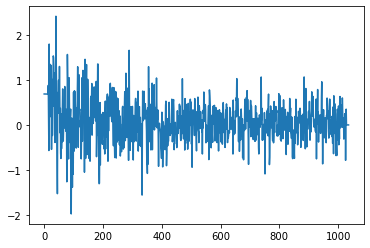

In [98]:
plt.plot(x[4])

## NOTES

Start with detection. One approach was fits file with coordinates. 

Or 

Use this but expand upon it. Find RA and DEC of each shot. And randomly extract.

    delta ra and delta dec. Double check if is there a source there. 
    
For noise sample, no need to run through valentina's code. Only focus on High-z after filtering through Valentina's code.

Once we have noise sample.

Run through valentina's code. Hopefully it detects them all as high-z. Cause neither low-z or star.

Two skycoords. Check coordinates to see if HETDEX detection is there. Compare minimum separation. If the difference is smaller than 3 arcseconds. Then there is a source there, so do not extract there.